In [ ]:
print("=" * 80)
print("STEP 9: MULTI-HORIZON PREDICTION VISUALIZATION (1D, 15D, 30D)")
print("=" * 80)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import numpy as np

# ============================================================
# 1. 加载模型和配置
# ============================================================
print("\n[STEP 9.1] Loading Model and Configuration...")

# 加载模型配置
model_config_path = os.path.join(SAVE_DIR, 'model_config.json')
if os.path.exists(model_config_path):
    with open(model_config_path, 'r', encoding='utf-8') as f:
        model_config = json.load(f)
    print(f"   ✅ Model config loaded: {model_config_path}")
else:
    print(f"   ⚠️ Model config not found, using default values")
    model_config = {}

# 加载模型
model_path = os.path.join(SAVE_DIR, 'best_model.pth')
if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    print(f"   ✅ Model loaded: {model_path}")
else:
    print(f"   ❌ Model not found: {model_path}")
    raise FileNotFoundError(f"Model file not found: {model_path}")

# 加载特征列表
selected_features_path = os.path.join(SAVE_DIR, 'selected_features.json')
if os.path.exists(selected_features_path):
    with open(selected_features_path, 'r', encoding='utf-8') as f:
        selected_features = json.load(f)
    print(f"   ✅ Selected features loaded: {len(selected_features)} features")
else:
    print(f"   ⚠️ Selected features not found, using all features")
    selected_features = patterns_df.columns.tolist()

# ============================================================
# 2. 准备最新数据
# ============================================================
print("\n[STEP 9.2] Preparing Latest Data...")

# 获取最新30天数据用于预测
latest_date = df.index[-1]
history_df = df.tail(SEQUENCE_LENGTH).copy()
print(f"   ✅ Latest date: {latest_date.date()}")
print(f"   ✅ History data: {len(history_df)} days")

# ============================================================
# 3. 定义预测时间间隔
# ============================================================
PREDICTION_HORIZONS = [1, 15, 30]  # 1天、15天、30天
print(f"\n[STEP 9.3] Prediction Horizons: {PREDICTION_HORIZONS} days")

# ============================================================
# 4. 进行多时间间隔预测
# ============================================================
print("\n[STEP 9.4] Performing Multi-Horizon Predictions...")

# 计算最新特征
current_patterns_all = detect_trading_patterns(history_df)

# 特征对齐
available_features = [f for f in selected_features if f in current_patterns_all.columns]
missing_features = [f for f in selected_features if f not in current_patterns_all.columns]

if missing_features:
    for feat in missing_features:
        current_patterns_all[feat] = 0.0

current_patterns = current_patterns_all[selected_features].copy()

# 标准化特征
last_seq_raw = current_patterns.iloc[-SEQUENCE_LENGTH:].values
last_seq_scaled = scaler.transform(last_seq_raw)
last_seq_tensor = torch.FloatTensor(last_seq_scaled).unsqueeze(0).to(device)

# 模型预测
model.eval()
with torch.no_grad():
    outputs, _, _, _ = model(last_seq_tensor)
    pred_returns = outputs[0, 0].item()  # 1天收益率预测
    pred_volatility = outputs[0, 1].item()  # 波动率预测

# 反标准化
pred_returns = scaler_target_returns.inverse_transform([[pred_returns]])[0, 0]
pred_volatility = scaler_target_volatility.inverse_transform([[pred_volatility]])[0, 0]

print(f"   ✅ 1天收益率预测: {pred_returns:.4f}%")
print(f"   ✅ 波动率预测: {pred_volatility:.4f}%")

# ============================================================
# 5. 生成不同时间间隔的预测路径
# ============================================================
print("\n[STEP 9.5] Generating Multi-Horizon Prediction Paths...")

# 获取最新价格
last_close_price = history_df['Close'].iloc[-1]
print(f"   ✅ Latest close price: {last_close_price:.2f}")

# 存储预测结果
prediction_results = {
    'dates': [],
    'prices_1D': [],
    'prices_15D': [],
    'prices_30D': [],
    'volatility': [],
    'confidence_intervals': {
        '1D': {'lower': [], 'upper': []},
        '15D': {'lower': [], 'upper': []},
        '30D': {'lower': [], 'upper': []}
    }
}

# 蒙特卡洛模拟参数
MONTE_CARLO_SIMULATIONS = 1000

# 对于每个时间间隔，使用不同的预测策略
for horizon in PREDICTION_HORIZONS:
    print(f"\n   📊 Processing {horizon}-day horizon...")
    
    # 策略1：直接使用1天预测，然后按比例扩展（简化方法）
    # 实际应用中，可以使用自回归预测到horizon天
    if horizon == 1:
        # 1天预测：直接使用模型输出
        horizon_return = pred_returns
        horizon_vol = pred_volatility
    else:
        # 多天预测：假设收益率按时间平方根缩放（随机游走假设）
        # 实际应用中，应该使用自回归预测
        horizon_return = pred_returns * np.sqrt(horizon)  # 简化假设
        horizon_vol = pred_volatility * np.sqrt(horizon)  # 波动率按时间平方根缩放
    
    # 蒙特卡洛模拟生成价格分布
    mu = horizon_return
    sigma = horizon_vol
    
    # 生成随机收益率
    random_returns = np.random.normal(loc=mu, scale=sigma, size=MONTE_CARLO_SIMULATIONS)
    
    # 计算对应的价格
    simulated_prices = last_close_price * (1 + random_returns / 100)
    simulated_prices = np.maximum(simulated_prices, 0.01)  # 确保价格为正
    
    # 计算统计量
    median_price = np.median(simulated_prices)
    lower_5 = np.percentile(simulated_prices, 5)
    upper_95 = np.percentile(simulated_prices, 95)
    
    # 计算未来日期
    future_date = latest_date + timedelta(days=horizon)
    
    # 存储结果
    prediction_results['dates'].append(future_date)
    if horizon == 1:
        prediction_results['prices_1D'].append(median_price)
        prediction_results['confidence_intervals']['1D']['lower'].append(lower_5)
        prediction_results['confidence_intervals']['1D']['upper'].append(upper_95)
    elif horizon == 15:
        prediction_results['prices_15D'].append(median_price)
        prediction_results['confidence_intervals']['15D']['lower'].append(lower_5)
        prediction_results['confidence_intervals']['15D']['upper'].append(upper_95)
    elif horizon == 30:
        prediction_results['prices_30D'].append(median_price)
        prediction_results['confidence_intervals']['30D']['lower'].append(lower_5)
        prediction_results['confidence_intervals']['30D']['upper'].append(upper_95)
    
    prediction_results['volatility'].append(horizon_vol)
    
    print(f"      ✅ {horizon}天预测价格: {median_price:.2f}")
    print(f"      ✅ 置信区间 (5%-95%): [{lower_5:.2f}, {upper_95:.2f}]")
    print(f"      ✅ 预测波动率: {horizon_vol:.4f}%")

# ============================================================
# 6. 可视化多时间间隔预测
# ============================================================
print("\n[STEP 9.6] Visualizing Multi-Horizon Predictions...")

# 准备历史价格数据（最近60天）
history_days = 60
history_prices = df['Close'].tail(history_days)
history_dates = history_prices.index

# 创建图表
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), height_ratios=[3, 1])

# ========== 子图1：价格预测路径 ==========
ax1.plot(history_dates, history_prices.values, 'b-', linewidth=2, label='历史价格', alpha=0.7)

# 绘制预测点（1天、15天、30天）
prediction_dates = [latest_date] + prediction_results['dates']
prediction_prices = [last_close_price] + [
    prediction_results['prices_1D'][0] if prediction_results['prices_1D'] else None,
    prediction_results['prices_15D'][0] if prediction_results['prices_15D'] else None,
    prediction_results['prices_30D'][0] if prediction_results['prices_30D'] else None
]

# 过滤None值
valid_dates = []
valid_prices = []
for d, p in zip(prediction_dates, prediction_prices):
    if p is not None:
        valid_dates.append(d)
        valid_prices.append(p)

# 绘制预测路径（连接线）
ax1.plot(valid_dates, valid_prices, 'r--', linewidth=2, marker='o', markersize=8, 
         label='预测路径 (1D→15D→30D)', alpha=0.8)

# 绘制置信区间
for i, horizon in enumerate(PREDICTION_HORIZONS):
    if horizon == 1 and prediction_results['confidence_intervals']['1D']['lower']:
        ax1.fill_between([latest_date, prediction_results['dates'][i]], 
                         [last_close_price, prediction_results['confidence_intervals']['1D']['lower'][0]],
                         [last_close_price, prediction_results['confidence_intervals']['1D']['upper'][0]],
                         alpha=0.2, color='red', label='1天置信区间 (5%-95%)' if i == 0 else '')
    elif horizon == 15 and prediction_results['confidence_intervals']['15D']['lower']:
        ax1.fill_between([prediction_results['dates'][0], prediction_results['dates'][i]], 
                         [prediction_results['prices_1D'][0], prediction_results['confidence_intervals']['15D']['lower'][0]],
                         [prediction_results['prices_1D'][0], prediction_results['confidence_intervals']['15D']['upper'][0]],
                         alpha=0.2, color='orange', label='15天置信区间 (5%-95%)' if i == 1 else '')
    elif horizon == 30 and prediction_results['confidence_intervals']['30D']['lower']:
        ax1.fill_between([prediction_results['dates'][1], prediction_results['dates'][i]], 
                         [prediction_results['prices_15D'][0], prediction_results['confidence_intervals']['30D']['lower'][0]],
                         [prediction_results['prices_15D'][0], prediction_results['confidence_intervals']['30D']['upper'][0]],
                         alpha=0.2, color='green', label='30天置信区间 (5%-95%)' if i == 2 else '')

# 标记预测点
ax1.scatter([latest_date], [last_close_price], color='blue', s=100, zorder=5, label='当前价格')
if prediction_results['prices_1D']:
    ax1.scatter([prediction_results['dates'][0]], [prediction_results['prices_1D'][0]], 
               color='red', s=100, zorder=5, label='1天预测')
if prediction_results['prices_15D']:
    ax1.scatter([prediction_results['dates'][1]], [prediction_results['prices_15D'][0]], 
               color='orange', s=100, zorder=5, label='15天预测')
if prediction_results['prices_30D']:
    ax1.scatter([prediction_results['dates'][2]], [prediction_results['prices_30D'][0]], 
               color='green', s=100, zorder=5, label='30天预测')

ax1.set_xlabel('日期', fontsize=12)
ax1.set_ylabel('价格', fontsize=12)
ax1.set_title(f'多时间间隔价格预测路径 (考虑Volatility不确定性)\n{TICKER_SYMBOL} - 预测日期: {latest_date.date()}', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(history_dates)//10)))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# ========== 子图2：波动率预测 ==========
vol_dates = [latest_date] + prediction_results['dates']
vol_values = [pred_volatility] + prediction_results['volatility']
ax2.plot(vol_dates, vol_values, 'purple', linewidth=2, marker='s', markersize=8, label='预测波动率')
ax2.fill_between(vol_dates, vol_values, alpha=0.2, color='purple')
ax2.set_xlabel('日期', fontsize=12)
ax2.set_ylabel('波动率 (%)', fontsize=12)
ax2.set_title('预测波动率变化 (Volatility在预测中的作用)', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'multi_horizon_prediction.png'), dpi=300, bbox_inches='tight')
print(f"   ✅ 图表已保存: {os.path.join(SAVE_DIR, 'multi_horizon_prediction.png')}")
plt.show()

# ============================================================
# 7. 输出预测摘要
# ============================================================
print("\n" + "=" * 80)
print("预测摘要 (Multi-Horizon Prediction Summary)")
print("=" * 80)
print(f"\n当前价格 ({latest_date.date()}): {last_close_price:.2f}")
print(f"\n预测结果:")
print(f"  📊 1天预测 ({prediction_results['dates'][0].date()}):")
print(f"     价格: {prediction_results['prices_1D'][0]:.2f} ({prediction_results['prices_1D'][0]/last_close_price*100-100:+.2f}%)")
print(f"     置信区间: [{prediction_results['confidence_intervals']['1D']['lower'][0]:.2f}, {prediction_results['confidence_intervals']['1D']['upper'][0]:.2f}]")
print(f"     波动率: {prediction_results['volatility'][0]:.4f}%")

if prediction_results['prices_15D']:
    print(f"\n  📊 15天预测 ({prediction_results['dates'][1].date()}):")
    print(f"     价格: {prediction_results['prices_15D'][0]:.2f} ({prediction_results['prices_15D'][0]/last_close_price*100-100:+.2f}%)")
    print(f"     置信区间: [{prediction_results['confidence_intervals']['15D']['lower'][0]:.2f}, {prediction_results['confidence_intervals']['15D']['upper'][0]:.2f}]")
    print(f"     波动率: {prediction_results['volatility'][1]:.4f}%")

if prediction_results['prices_30D']:
    print(f"\n  📊 30天预测 ({prediction_results['dates'][2].date()}):")
    print(f"     价格: {prediction_results['prices_30D'][0]:.2f} ({prediction_results['prices_30D'][0]/last_close_price*100-100:+.2f}%)")
    print(f"     置信区间: [{prediction_results['confidence_intervals']['30D']['lower'][0]:.2f}, {prediction_results['confidence_intervals']['30D']['upper'][0]:.2f}]")
    print(f"     波动率: {prediction_results['volatility'][2]:.4f}%")

print("\n" + "=" * 80)
print("Volatility在自回归预测中的作用:")
print("=" * 80)
print("1. 量化不确定性: 作为蒙特卡洛模拟的标准差（sigma），反映预测的不确定性")
print("2. 生成价格分布: 通过蒙特卡洛模拟生成价格分布，而不是单一价格点")
print("3. 计算置信区间: 通过模拟结果的分位数（如5%、50%、95%）计算置信区间")
print("4. 风险评估: 高波动率意味着更大的价格波动范围，低波动率意味着更稳定的预测")
print("=" * 80)


# ============================================================
# STEP 9: 多时间间隔预测可视化（1天、15天、30天）
# ============================================================
# 
# 功能说明：
# 1. 使用训练好的模型预测不同时间间隔的收益率（1天、15天、30天）
# 2. 考虑volatility的不确定性，生成置信区间
# 3. 将预测结果连成一条线，展示价格走势
# 4. 可视化预测路径和不确定性范围
#
# Volatility在自回归中的作用：
# - 量化不确定性：作为蒙特卡洛模拟的标准差（sigma），反映预测的不确定性
# - 生成价格分布：通过蒙特卡洛模拟生成价格分布，而不是单一价格点
# - 计算置信区间：通过模拟结果的分位数（如5%、50%、95%）计算置信区间
# - 风险评估：高波动率意味着更大的价格波动范围，低波动率意味着更稳定的预测


In [43]:
import os
import warnings
import yfinance as yf
import numpy as np
import pandas as pd
import talib
import matplotlib
# matplotlib.use('Agg')  # 已注释：改为直接显示图像
import matplotlib.pyplot as plt
# 在Jupyter notebook中显示图像
%matplotlib inline
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# ============================================================
# STEP 0: DATA FETCHING & PREPROCESSING
# ============================================================
# ===================== 手动输入股票代码 =====================
# 1. 基础输入（带默认值，回车直接用恒生指数）
ticker_symbol = input("请输入要回测的股票/指数代码（默认：^HSI 恒生指数）：").strip()
# 2. 空输入时用默认值
if not ticker_symbol:
    ticker_symbol = "^HSI"
    print(f"未输入代码，使用默认值：{ticker_symbol}（恒生指数）")

# 3. 输入校验（检查yfinance是否能获取该代码的数据）
print(f"\n正在验证代码 {ticker_symbol} 的有效性...")
temp_ticker = yf.Ticker(ticker_symbol)
temp_df = temp_ticker.history(period="1d")  # 仅获取1天数据验证

if temp_df.empty:
    # 校验失败，提示并强制使用默认值
    print(f"⚠️ 输入的代码 {ticker_symbol} 无效（无数据），自动切换为默认值 ^HSI")
    ticker_symbol = "^HSI"
    ticker = yf.Ticker(ticker_symbol)
else:
    # 校验成功，创建Ticker对象
    print(f"✅ 代码 {ticker_symbol} 验证通过！")
    ticker = yf.Ticker(ticker_symbol)

#print("Fetching HSI data...")
#ticker = yf.Ticker("^HSI")
end_date = datetime.now()
#end_date = datetime.now()+timedelta(days=1)

start_date = end_date - timedelta(days=20*365)
df = ticker.history(start=start_date, end=end_date)
print(f"最新日期: {df.index[-1].strftime('%Y-%m-%d')}")

# 1. 波动率指数 (VIX) - 多品种适配
# 优先使用美股VIX (^VIX)，失败则尝试港股HSIL (^HSIL)，都失败则用主标的自身波动率估算
print("Fetching VIX (Volatility Index) data...")
vix_df = None
vix_source = None

# 尝试获取美股VIX
try:
    vix_ticker = yf.Ticker("^VIX")
    vix_df = vix_ticker.history(start=start_date, end=end_date)
    if not vix_df.empty:
        vix_df.index = pd.to_datetime(vix_df.index).tz_localize(None)
        vix_source = "^VIX"
        print(f"✅ Successfully fetched ^VIX data")
except Exception as e:
    print(f"⚠️ Failed to fetch ^VIX: {e}")

# 如果^VIX失败，尝试港股HSIL
if vix_df is None or vix_df.empty:
    try:
        vix_ticker = yf.Ticker("^HSIL")
        vix_df = vix_ticker.history(start=start_date, end=end_date)
        if not vix_df.empty:
            vix_df.index = pd.to_datetime(vix_df.index).tz_localize(None)
            vix_source = "^HSIL"
            print(f"✅ Successfully fetched ^HSIL data")
    except Exception as e:
        print(f"⚠️ Failed to fetch ^HSIL: {e}")

# 处理VIX数据
if vix_df is not None and not vix_df.empty:
    # 外部数据强制滞后一期，确保仅利用截止昨日的信息预测今日
    df = df.join(vix_df['Close'].rename('VIX_Close').shift(1), how='left')
    df['VIX_Close'] = df['VIX_Close'].ffill(limit=5)
    vix_fallback = df['VIX_Close'].rolling(20, min_periods=1).mean()
    df['VIX_Close'] = df['VIX_Close'].fillna(vix_fallback)
    
    # 如果仍有缺失，用主标的自身波动率估算（方案1）
    missing_mask = df['VIX_Close'].isna()
    if missing_mask.any():
        print(f"⚠️ Warning: {missing_mask.sum()} VIX values are missing. Estimating from underlying asset volatility...")
        # 计算主标的的20日年化波动率，转换为VIX近似值
        vol_20d = df['Log_Ret'].rolling(20, min_periods=10).std() * np.sqrt(252) * 100
        df.loc[missing_mask, 'VIX_Close'] = vol_20d[missing_mask]
        df['VIX_Close'] = df['VIX_Close'].fillna(20.0)  # 最终兜底
else:
    # VIX数据完全缺失，用主标的自身波动率估算
    print("⚠️ Warning: VIX data is completely missing. Estimating from underlying asset volatility...")
    # 计算主标的的20日年化波动率，转换为VIX近似值
    vol_20d = df['Log_Ret'].rolling(20, min_periods=10).std() * np.sqrt(252) * 100
    df['VIX_Close'] = vol_20d.fillna(20.0)  # 最终兜底值20

# 基础清洗
df = df.dropna(subset=['Close'])
df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))
last_3_days = df.index[-3:]
df = df[(df['Volume'] > 0) | (df.index.isin(last_3_days))].copy()
df.index = pd.to_datetime(df.index).tz_localize(None)

# 2. 获取外部资产数据（包含期货数据）
print("Fetching External Assets & Futures...")
tickers_dict = {
    # 股票指数
    'SPX_Close': '^GSPC',
    'SSE_Close': '000001.SS',
    
    # 外汇
    'USDCNH_Close': 'CNH=F',  # 美元/人民币期货
    'USDHKD_Close': 'HKD=X',
    'DXY_Close': 'DX-Y.NYB',
    
    # 利率
    'US10Y_Close': '^TNX',
    
    # 商品期货
    'GOLD_Close': 'GC=F',  # 黄金期货
    'SILVER_Close': 'SI=F',  # 白银期货
    'OIL_Close': 'CL=F',  # WTI原油期货
    'COPPER_Close': 'HG=F',  # 铜期货
    'NATURAL_GAS_Close': 'NG=F',  # 天然气期货
    
    # 股指期货（领先指标）- 近月合约
    'ES_Close': 'ES=F',  # E-mini S&P 500期货（近月）
    'NQ_Close': 'NQ=F',  # E-mini Nasdaq-100期货（近月）
    'YM_Close': 'YM=F',  # E-mini Dow Jones期货（近月）
    
    # 股指期货 - 次月合约（约1个月到期）
    # 注意：yfinance可能不支持直接指定月份，这里尝试获取次月合约
    # 如果失败，将使用近月合约数据
    'ES_NextMonth_Close': 'ES=F',  # 尝试获取次月合约（如果可用）
    'NQ_NextMonth_Close': 'NQ=F',  # 尝试获取次月合约（如果可用）
    
    # 国债期货
    'ZB_Close': 'ZB=F',  # 30年期美债期货
    'ZN_Close': 'ZN=F',  # 10年期美债期货
    
    # 外汇期货
    'EURUSD_Close': '6E=F',  # 欧元/美元期货
    'USDJPY_Close': '6J=F',  # 美元/日元期货
}

# 辅助函数：尝试获取不同到期日的期货合约
def get_futures_with_expiry(base_symbol, expiry_days=None):
    """
    尝试获取指定到期日的期货合约数据
    base_symbol: 基础期货代码（如'ES=F'）
    expiry_days: 目标到期天数（如15天、30天），None表示使用近月合约
    返回: DataFrame或None
    """
    try:
        ticker = yf.Ticker(base_symbol)
        # 获取合约信息（如果可用）
        info = ticker.info
        # yfinance通常只提供近月合约，但我们可以尝试获取历史数据
        hist = ticker.history(start=start_date, end=end_date)
        if not hist.empty:
            hist.index = pd.to_datetime(hist.index).tz_localize(None)
            return hist
    except:
        pass
    return None

for col_name, ticker_symbol in tickers_dict.items():
    try:
        # 对于期货，尝试获取数据
        ext_df = yf.Ticker(ticker_symbol).history(start=start_date, end=end_date)
        ext_df.index = pd.to_datetime(ext_df.index).tz_localize(None)
        if ext_df.empty:
            print(f"    ⚠️ Warning: {col_name} data is empty/sparse.")
            df[col_name] = np.nan
        else:
            # 同样强制滞后一期，防止利用跨市场时区差异引入未来数据
            df = df.join(ext_df['Close'].rename(col_name).shift(1), how='left')
    except Exception as e:
        print(f"    ❌ Error fetching {ticker_symbol}: {e}")
        df[col_name] = np.nan

# 尝试获取不同到期日的期货合约（15天、1个月）
# ⚠️ 重要说明：yfinance通常只提供近月合约（Front Month）
# 要获取不同到期日的合约，可能需要：
# 1. 使用专门的期货数据API（如Quandl, CME Group API）
# 2. 使用具体的合约代码（如ESZ2024表示2024年12月合约，但yfinance可能不支持）
# 3. 通过期货期限结构（Term Structure）来推断不同到期日的价格

print("\n尝试获取不同到期日的期货合约...")
print("⚠️ 注意：yfinance通常只提供近月合约，以下代码会尝试获取，但可能返回相同数据")

# 方法：尝试使用不同的合约代码格式
# 对于CME期货，合约代码格式通常是：基础代码+月份代码+年份
# 例如：ESZ2024 (E-mini S&P 500, 2024年12月)
# 但yfinance可能不支持这种格式，这里我们尝试几种方法

# 定义需要获取的期货合约（15天、1个月到期）
# 注意：由于yfinance限制，这里我们使用期限结构特征作为替代
futures_expiry_dict = {
    # 尝试获取不同到期日的ES期货
    'ES_FrontMonth_Close': 'ES=F',  # 近月合约（默认）
    # 尝试使用可能的次月合约代码（如果yfinance支持）
    # 'ES_NextMonth_Close': 'ES=F',  # 次月合约（可能需要具体代码）
    
    # 尝试获取不同到期日的NQ期货
    'NQ_FrontMonth_Close': 'NQ=F',  # 近月合约
}

# 尝试获取近月合约数据（作为基准）
for col_name, ticker_symbol in futures_expiry_dict.items():
    try:
        ticker = yf.Ticker(ticker_symbol)
        ext_df = ticker.history(start=start_date, end=end_date)
        if not ext_df.empty:
            ext_df.index = pd.to_datetime(ext_df.index).tz_localize(None)
            df = df.join(ext_df['Close'].rename(col_name).shift(1), how='left')
            print(f"    ✅ {col_name} data fetched")
        else:
            df[col_name] = np.nan
            print(f"    ⚠️ {col_name} data is empty")
    except Exception as e:
        df[col_name] = np.nan
        print(f"    ❌ Error fetching {col_name}: {e}")

# 计算期货期限结构特征（使用近月合约和现货的价差来推断）
# 如果ES期货和SPX现货都存在，可以计算基差（Basis）
if 'ES_FrontMonth_Close' in df.columns and 'SPX_Close' in df.columns:
    # ES期货通常比SPX现货有溢价/折价，这反映了期限结构
    es_spx_basis = (df['ES_FrontMonth_Close'] - df['SPX_Close']) / df['SPX_Close'] * 100
    df['ES_SPX_Basis'] = es_spx_basis.fillna(0)  # 基差（Basis），反映期限结构
    print("    ✅ ES/SPX基差（期限结构指标）已计算")

# 对于15天和1个月的期货数据，由于yfinance限制，我们使用以下替代方案：
# 1. 使用近月合约数据（ES_FrontMonth_Close）
# 2. 通过期限结构特征（ES_SPX_Basis）来推断不同到期日的价格
# 3. 如果需要精确的不同到期日数据，建议使用专门的期货数据API

# 创建15天和1个月的"虚拟"期货价格（基于期限结构推断）
# 注意：这是近似值，实际应用中建议使用专门的期货数据源
if 'ES_FrontMonth_Close' in df.columns and 'ES_SPX_Basis' in df.columns:
    # 假设期限结构是线性的（简化假设）
    # 15天期货 ≈ 近月合约 * (1 + 基差 * 15/30)
    # 1个月期货 ≈ 近月合约 * (1 + 基差)
    df['ES_15D_Close'] = df['ES_FrontMonth_Close'] * (1 + df['ES_SPX_Basis'] / 100 * 0.5).fillna(1)
    df['ES_1M_Close'] = df['ES_FrontMonth_Close'] * (1 + df['ES_SPX_Basis'] / 100).fillna(1)
    print("    ✅ ES 15天和1个月期货价格（基于期限结构推断）已计算")
    
    # 同样处理NQ
    if 'NQ_FrontMonth_Close' in df.columns:
        # 使用ES的期限结构作为NQ的近似（或可以单独计算NQ的基差）
        df['NQ_15D_Close'] = df['NQ_FrontMonth_Close'] * (1 + df['ES_SPX_Basis'] / 100 * 0.5).fillna(1)
        df['NQ_1M_Close'] = df['NQ_FrontMonth_Close'] * (1 + df['ES_SPX_Basis'] / 100).fillna(1)
        print("    ✅ NQ 15天和1个月期货价格（基于期限结构推断）已计算")

# 3. 填充外部数据
# 严禁使用 bfill，防止未来数据回填导致回测结果虚高
df[list(tickers_dict.keys())] = df[list(tickers_dict.keys())].ffill()

# 4. 计算外部资产收益率（包括期货）
# 显式指定 fill_method=None 以避免 Pandas 2.0+ 版本警告
df['SPX_Ret'] = df['SPX_Close'].pct_change(fill_method=None).fillna(0)
df['SSE_Ret'] = df['SSE_Close'].pct_change(fill_method=None).fillna(0)

# 计算期货收益率（如果数据存在）
futures_ret_list = ['ES_Close', 'NQ_Close', 'YM_Close', 'OIL_Close', 'GOLD_Close', 
                     'SILVER_Close', 'COPPER_Close', 'NATURAL_GAS_Close', 'ZB_Close', 
                     'ZN_Close', 'EURUSD_Close', 'USDJPY_Close',
                     # 不同到期日的期货
                     'ES_FrontMonth_Close', 'ES_15D_Close', 'ES_1M_Close',
                     'NQ_FrontMonth_Close', 'NQ_15D_Close', 'NQ_1M_Close']
for col in futures_ret_list:
    if col in df.columns:
        ret_col = col.replace('_Close', '_Ret')
        df[ret_col] = df[col].pct_change(fill_method=None).fillna(0)

print("External data fetched and merged.")
print(f"Data shape: {df.shape}")


# ============================================================
# STEP 1: DEFINE TRADING PATTERNS (CORRECTED LOGIC)
# ============================================================
def detect_trading_patterns(df):
    df = df.copy()
    patterns = pd.DataFrame(index=df.index)

    # 0. 准备基础数据 (Float64)
    open_p = df['Open'].values.astype(np.float64)
    high_p = df['High'].values.astype(np.float64)
    low_p = df['Low'].values.astype(np.float64)
    close_p = df['Close'].values.astype(np.float64)
    volume_p = df['Volume'].values.astype(np.float64)

    # 1. 基础收益率
    df['Returns'] = df['Close'].ffill().pct_change().fillna(0)
    patterns['Returns'] = df['Returns']
    # Log Return 用于计算
    patterns['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1)).fillna(0)

    # 2. 波动率基准 (ATR)
    atr_20 = talib.ATR(high_p, low_p, close_p, timeperiod=20)
    atr_20_s = pd.Series(atr_20, index=df.index)
    patterns['Volatility_Ratio'] = atr_20_s / (atr_20_s.rolling(20, min_periods=20).mean().shift(1) + 1e-10)

    # 3. 跳空缺口 (Gaps)
    prev_close = df['Close'].shift(1)
    prev_atr = atr_20_s.shift(1)
    gap_raw = (df['Open'] - prev_close) / prev_close
    gap_threshold = (prev_atr / prev_close * 0.5).fillna(1.0)
    patterns['Gap_Up'] = (gap_raw > 0).astype(float) * gap_raw * (gap_raw > gap_threshold).astype(float)
    patterns['Gap_Down'] = (gap_raw < 0).astype(float) * abs(gap_raw) * (abs(gap_raw) > gap_threshold).astype(float)

    # =======================================================
    #  4. 成交量因子 (Volume Factors - Dual Horizon & Regimes)
    # =======================================================

    # --- A. 基础计算：双时间窗口基准 ---
    # 20日均量：捕捉中期趋势 (机构视角)
    vol_ma_20 = df['Volume'].rolling(window=20, min_periods=5).mean()
    # 5日均量：捕捉短期突变 (游资/事件视角)
    vol_ma_5 = df['Volume'].rolling(window=5, min_periods=3).mean()

    # 相对量能 (Relative Volume) - 连续型指标
    # 使用 20 日作为主基准，描述整体热度
    patterns['Vol_Rel_20'] = (df['Volume'] / (vol_ma_20 + 1e-10)).replace([np.inf, -np.inf], 0).fillna(0)
    # 使用 5 日作为敏捷基准，描述短期爆发力
    patterns['Vol_Rel_5'] = (df['Volume'] / (vol_ma_5 + 1e-10)).replace([np.inf, -np.inf], 0).fillna(0)

    # --- B. 状态信号：自适应阈值 ---
    # 极度放量 (Relative > 2.0)
    patterns['Vol_Surge'] = (patterns['Vol_Rel_20'] > 2.0).astype(float)
    # 明显缩量 (Relative < 0.6)
    patterns['Vol_Dry_Up'] = (patterns['Vol_Rel_20'] < 0.6).astype(float)

    # --- C. 量价逻辑拆分 ---
    # 上涨放量 (Bullish Force): 价格涨 且 量能大于 20日均线 1.2倍
    patterns['Vol_Price_Up_Confirm'] = (
        (patterns['Log_Ret'] > 0) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Vol_Rel_20'] # 保留强度作为权重

    # 下跌放量 (Panic Selling): 价格跌 且 量能大于 20日均线 1.2倍
    patterns['Vol_Price_Down_Panic'] = (
        (patterns['Log_Ret'] < 0) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Vol_Rel_20'] # 保留强度作为权重

    # 缩量回调 (Healthy Pullback): 价格跌 但 量能小于 5日均线 (短期缩量)
    patterns['Vol_Pullback_Low'] = (
        (patterns['Log_Ret'] < 0) & (patterns['Vol_Rel_5'] < 0.8)
    ).astype(float)

    # --- D. 量价偏差与连续性 ---
    # 量能偏差 (连续变量): 正值代表放量，负值代表缩量
    patterns['Vol_Bias_20'] = (patterns['Vol_Rel_20'] - 1.0)

    # 量价趋势一致性 (3日窗口)
    # 逻辑：价格变化方向 == 成交量变化方向 (涨且增量，或跌且缩量)
    vol_diff = df['Volume'].diff()
    price_diff = df['Close'].diff()

    is_up_vol = (price_diff > 0) & (vol_diff > 0)
    is_down_dry = (price_diff < 0) & (vol_diff < 0)

    # 3天内符合“顺势量价”的天数 (0, 1, 2, 3)
    patterns['Vol_Trend_Consistency'] = (is_up_vol | is_down_dry).rolling(3).sum().fillna(0)

    # 兼容性别名 (供后续旧代码逻辑引用)
    patterns['Vol_Rel'] = patterns['Vol_Rel_20']
    patterns['High_Volume'] = patterns['Vol_Surge']

    # =======================================================

    # 5. 反转形态
    # 更新：使用新的 Vol_Rel_20 替代
    avg_vol_20 = vol_ma_20 # 复用变量
    patterns['Gap_Up_Reversal'] = (
        (patterns['Gap_Up'] > 0.005) & (df['Close'] < df['Open']) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Gap_Up']

    patterns['Gap_Down_Reversal'] = (
        (patterns['Gap_Down'] > 0.005) & (df['Close'] > df['Open']) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Gap_Down']

    # 6. 趋势连续性
    patterns['Trend_2Day'] = df['Log_Ret'].rolling(2).sum().fillna(0)
    t2_sign = np.sign(patterns['Trend_2Day'])
    patterns['Trend_Consistency'] = ((t2_sign == t2_sign.shift(1)) & (t2_sign == t2_sign.shift(2))).astype(float).fillna(0)

    # 7. 回撤反弹
    rolling_max = df['Close'].rolling(20).max().shift(1)
    drawdown = (df['Close'].shift(1) - rolling_max) / (rolling_max + 1e-10)
    drawdown_5pct = drawdown.rolling(10).quantile(0.1).fillna(-0.05)
    patterns['Drawdown_Bounce'] = ((drawdown < drawdown_5pct) & (df['Returns'] > 0.01)).astype(float) * df['Returns']

    # 8. 趋势天数
    patterns['2Day_Uptrend'] = ((df['Returns'] > 0) & (df['Returns'].shift(1) > 0)).astype(float)
    patterns['2Day_Downtrend'] = ((df['Returns'] < 0) & (df['Returns'].shift(1) < 0)).astype(float)
    patterns['3Day_Uptrend'] = ((df['Returns'] > 0) & (df['Returns'].shift(1) > 0) & (df['Returns'].shift(2) > 0)).astype(float)

    # 9. 突破形态
    roll_high = df['High'].rolling(20).max().shift(1)
    roll_low = df['Low'].rolling(20).min().shift(1)
    # 更新：使用 Vol_Rel_20 替代原有的硬编码 Volume
    patterns['Breakout_High'] = ((df['Close'] > roll_high) & (patterns['Vol_Rel_20'] > 1.5)).astype(float) * ((df['Close'] - roll_high) / roll_high)
    patterns['Breakdown_Low'] = ((df['Close'] < roll_low) & (patterns['Vol_Rel_20'] > 1.5)).astype(float) * ((roll_low - df['Close']) / roll_low)
    patterns['Breakout_Confirm'] = ((patterns['Breakout_High'] > 0) & (patterns['Breakout_High'].shift(1) > 0)).astype(float)

    # 10. 波动模式
    daily_range = (df['High'] - df['Low']) / (df['Low'] + 1e-10)
    patterns['High_Volatility'] = (daily_range > 0.02).astype(float) * daily_range
    patterns['Low_Volatility'] = (daily_range < 0.005).astype(float) * (0.005 - daily_range)

    # 12. 动量模式
    ret_5d = df['Close'].ffill().pct_change(5)
    patterns['Strong_Momentum_Up'] = (ret_5d > 0.03).astype(float) * ret_5d / 0.03
    patterns['Strong_Momentum_Down'] = (ret_5d < -0.03).astype(float) * abs(ret_5d) / 0.03

    # 13. 日内形态
    patterns['Inside_Day'] = ((df['High'] < df['High'].shift(1)) & (df['Low'] > df['Low'].shift(1))).astype(float)
    patterns['Outside_Day'] = ((df['High'] > df['High'].shift(1)) & (df['Low'] < df['Low'].shift(1))).astype(float) * daily_range

    # 14. RSI
    rsi = talib.RSI(close_p, timeperiod=14)
    rsi_s = pd.Series(rsi, index=df.index).fillna(50)
    patterns['RSI_Overbought'] = (rsi_s > 70).astype(float) * (rsi_s - 70) / 30
    patterns['RSI_Oversold'] = (rsi_s < 30).astype(float) * (30 - rsi_s) / 30
    patterns['RSI_Near_50'] = ((rsi_s >= 45) & (rsi_s <= 55)).astype(float)
    patterns['RSI_Divergence'] = np.clip((rsi_s - 50) / 50.0, -1, 1)

    # 15. MACD
    macd, signal, hist = talib.MACD(close_p, fastperiod=12, slowperiod=26, signalperiod=9)
    macd_s, signal_s = pd.Series(macd, index=df.index), pd.Series(signal, index=df.index)
    hist_s = pd.Series(hist, index=df.index).fillna(0)
    patterns['MACD_Bullish_Cross'] = ((macd_s > signal_s) & (macd_s.shift(1) <= signal_s.shift(1))).astype(float)
    patterns['MACD_Bearish_Cross'] = ((macd_s < signal_s) & (macd_s.shift(1) >= signal_s.shift(1))).astype(float)

    # 16. 布林带
    bb_mid = df['Close'].rolling(20).mean().shift(1)
    bb_std = df['Close'].rolling(20).std().fillna(0).shift(1)
    bb_upper, bb_lower = bb_mid + 2 * bb_std, bb_mid - 2 * bb_std
    bb_width = (bb_upper - bb_lower) / (bb_mid + 1e-10)

    bb_width_clipped = np.clip(bb_width.shift(1), 0, bb_width.quantile(0.99))
    bb_width_quantile = bb_width_clipped.rolling(60).quantile(0.1).shift(1)

    patterns['BB_Position'] = np.clip((df['Close'] - bb_mid) / (bb_std + 1e-10), -3, 3)
    patterns['BB_Width'] = bb_width.shift(1)
    patterns['BB_Touch_Upper'] = (df['Close'] >= bb_upper).astype(float)
    patterns['BB_Touch_Lower'] = (df['Close'] <= bb_lower).astype(float)
    patterns['BB_Width_Compressed'] = (bb_width.shift(1) < bb_width_quantile).astype(float)
    patterns['BB_Pos_Norm'] = (df['Close'] - bb_lower) / (bb_upper - bb_lower + 1e-10)

    # 17. 情绪因子
    vix_min = df['VIX_Close'].rolling(50).min()
    vix_max = df['VIX_Close'].rolling(50).max()
    patterns['Sentiment_Fear_Rank'] = (df['VIX_Close'] - vix_min) / (vix_max - vix_min + 1e-10)
    patterns['Sentiment_Change'] = df['VIX_Close'].ffill().pct_change().fillna(0)
    
    # 检查外部数据是否存在（多品种适配）
    has_spx_ret = 'SPX_Ret' in df.columns and not df['SPX_Ret'].isna().all()
    has_sse_ret = 'SSE_Ret' in df.columns and not df['SSE_Ret'].isna().all()
    
    if has_spx_ret and has_sse_ret:
        patterns['Market_Up_Down_Ratio'] = np.where(df['SPX_Ret'].fillna(0) > 0, 1.5, 0.5) * np.where(df['SSE_Ret'].fillna(0) > 0, 1.2, 0.8)
    else:
        patterns['Market_Up_Down_Ratio'] = 1.0  # 中性值
    
    patterns['VIX_Quantile'] = df['VIX_Close'].rank(pct=True)
    
    if has_sse_ret:
        patterns['Industry_Diff'] = df['Returns'] - df['SSE_Ret'].fillna(0)
    else:
        patterns['Industry_Diff'] = 0.0
    patterns['VIX_Change_Rate'] = df['VIX_Close'].pct_change(3, fill_method=None).fillna(0)
    vix_roll_252 = df['VIX_Close'].rolling(252, min_periods=60)
    patterns['VIX_Rank_Year'] = (df['VIX_Close'] - vix_roll_252.min()) / (vix_roll_252.max() - vix_roll_252.min() + 1e-10)
    patterns['Corr_Price_VIX'] = df['Log_Ret'].rolling(10).corr(df['VIX_Close'].pct_change(fill_method=None)).fillna(-1)

    # 18. 宏观/季节
    patterns['Month_Sin'] = np.sin(2 * np.pi * df.index.month / 12)
    patterns['Month_Cos'] = np.cos(2 * np.pi * df.index.month / 12)
    patterns['Quarter'] = df.index.quarter
    patterns = pd.get_dummies(patterns, columns=['Quarter'], prefix='Quarter', dtype=float)
    ma_200 = df['Close'].rolling(200).mean()
    patterns['Trend_Macro_200d'] = (df['Close'] - ma_200) / (ma_200 + 1e-10)
    patterns['MOM_Quarter'] = df['Close'].pct_change(60, fill_method=None).fillna(0)

    # 19. 稳定性 (ADX)
    patterns['ADX'] = pd.Series(talib.ADX(high_p, low_p, close_p, timeperiod=14), index=df.index).fillna(0)
    patterns['PLUS_DI'] = pd.Series(talib.PLUS_DI(high_p, low_p, close_p, timeperiod=14), index=df.index).fillna(0)
    patterns['MINUS_DI'] = pd.Series(talib.MINUS_DI(high_p, low_p, close_p, timeperiod=14), index=df.index).fillna(0)

    # 20. KDJ
    k, d = talib.STOCH(high_p, low_p, close_p, fastk_period=9, slowk_period=3)
    patterns['KDJ_K'] = pd.Series(k, index=df.index).fillna(50)
    patterns['KDJ_D'] = pd.Series(d, index=df.index).fillna(50)
    patterns['KDJ_J'] = np.clip(3 * patterns['KDJ_K'] - 2 * patterns['KDJ_D'], 0, 100)

    # 21 & 22. 趋势效率
    path_len = np.abs(df['Close'] - df['Close'].shift(1)).rolling(10).sum()
    direction = np.abs(df['Close'] - df['Close'].shift(10))
    patterns['Trend_Efficiency'] = np.where(path_len > 0, direction / (path_len + 1e-10), 0)

    ma_5, ma_10 = df['Close'].rolling(5).mean(), df['Close'].rolling(10).mean()
    ma_20, ma_60 = df['Close'].rolling(20).mean(), df['Close'].rolling(60).mean()
    patterns['Trend_Alignment'] = ((ma_5 > ma_10) & (ma_10 > ma_20) & (ma_20 > ma_60)).astype(float)

    # 23. 微观结构 (使用新的成交量因子)
    patterns['Shadow_Upper_Pct'] = (df['High'] - np.maximum(df['Close'], df['Open'])) / (df['High'] - df['Low'] + 1e-10)
    patterns['Shadow_Lower_Pct'] = (np.minimum(df['Close'], df['Open']) - df['Low']) / (df['High'] - df['Low'] + 1e-10)
    patterns['ADOSC'] = pd.Series(talib.ADOSC(high_p, low_p, close_p, volume_p), index=df.index).fillna(0)
    patterns['Acceleration'] = patterns['Returns'].diff().fillna(0)

    # 24. 量价同步 (基于新 Vol_Rel_20)
    # 量能趋势 (3日)
    vol_trend = np.sign(df['Volume'].diff()).rolling(3).sum()
    patterns['Vol_Price_Trend_Sync'] = (vol_trend == np.sign(df['Returns']).rolling(3).sum()).astype(float)

    # Gap adj
    patterns['Gap_Up_VolAdj'] = patterns['Gap_Up'] / (patterns['Vol_Rel_20'] + 0.1)

    patterns['Range_Pct'] = (df['High'] - df['Low']) / df['Close']
    patterns['Open_Close_Ratio'] = df['Open'] / df['Close'] - 1
    
    # 检查外部数据是否存在（多品种适配：缺失时设为0或中性值）
    has_spx = 'SPX_Ret' in df.columns and not df['SPX_Ret'].isna().all()
    has_sse = 'SSE_Ret' in df.columns and not df['SSE_Ret'].isna().all()
    has_spx_close = 'SPX_Close' in df.columns and not df['SPX_Close'].isna().all()
    has_sse_close = 'SSE_Close' in df.columns and not df['SSE_Close'].isna().all()
    has_cnh = 'USDCNH_Close' in df.columns and not df['USDCNH_Close'].isna().all()
    has_hkd = 'USDHKD_Close' in df.columns and not df['USDHKD_Close'].isna().all()
    has_gold = 'GOLD_Close' in df.columns and not df['GOLD_Close'].isna().all()
    has_dxy = 'DXY_Close' in df.columns and not df['DXY_Close'].isna().all()
    
    # SPX相关特征
    if has_spx:
        patterns['Cross_Ret_SPX'] = df['Returns'] - df['SPX_Ret'].fillna(0)
    else:
        patterns['Cross_Ret_SPX'] = 0.0
    
    if has_sse:
        patterns['Cross_Ret_SSE'] = df['Returns'] - df['SSE_Ret'].fillna(0)
    else:
        patterns['Cross_Ret_SSE'] = 0.0
    
    if has_sse_close:
        patterns['SSE_Gap'] = (df['SSE_Close'] / df['SSE_Close'].shift(1) - 1).fillna(0)
    else:
        patterns['SSE_Gap'] = 0.0
    
    if has_spx_close:
        patterns['SPX_Gap'] = (df['SPX_Close'] / df['SPX_Close'].shift(1) - 1).fillna(0)
    else:
        patterns['SPX_Gap'] = 0.0
    
    patterns['Open_Norm'] = (df['Open'] - df['Close'].shift(1)) / prev_atr

    patterns['MA5_MA10_Diff'] = ma_5 - ma_10
    patterns['MA10_MA20_Diff'] = ma_10 - ma_20
    patterns['RSI_Trend'] = rsi_s - rsi_s.shift(3)
    trend_day = df['Returns'].apply(lambda x: 1 if x>0 else (-1 if x<0 else 0))
    patterns['Trend_Day_Count'] = trend_day.rolling(3).sum().fillna(0)
    patterns['Pullback_Pct'] = (df['High'] - df['Close']) / (df['High'] - df['Low'] + 1e-10) * 100
    patterns['Return_Volatility'] = df['Returns'].rolling(20).std()
    patterns['Volatility_Cluster'] = df['Returns'].rolling(20).std()
    # 替换Log_Market_Cap（非平稳特征：log(Close)）为Price_to_MA200_Ratio（平稳特征）
    # 原因：绝对价格序列是非平稳的，10年前的价格水平无法很好地推广到现在
    # 使用相对指标Price_to_MA200_Ratio，确保所有输入都在稳定的波动范围内
    ma_200_price = df['Close'].rolling(200, min_periods=50).mean()
    patterns['Price_to_MA200_Ratio'] = (df['Close'] / (ma_200_price + 1e-10) - 1.0).fillna(0)

    # Beta和相关性特征（需要SPX数据）
    if has_spx:
        cov = df['Returns'].shift(1).rolling(60).cov(df['SPX_Ret'].fillna(0)).fillna(0)
        spx_var = df['SPX_Ret'].fillna(0).rolling(60).var()
        patterns['Beta_Coeff'] = cov / (spx_var + 1e-10)
        patterns['RS_vs_SPX'] = df['Close'].pct_change(20, fill_method=None) - df['SPX_Close'].pct_change(20, fill_method=None) if has_spx_close else 0.0
        patterns['RS_vs_SPX'] = patterns['RS_vs_SPX'].fillna(0)
        patterns['Corr_SPX_60'] = df['Log_Ret'].rolling(60).corr(df['SPX_Ret'].fillna(0)).fillna(0)
    else:
        patterns['Beta_Coeff'] = 0.0
        patterns['RS_vs_SPX'] = 0.0
        patterns['Corr_SPX_60'] = 0.0
    
    if has_sse:
        patterns['RS_vs_SSE'] = df['Close'].pct_change(20, fill_method=None) - df['SSE_Close'].pct_change(20, fill_method=None) if has_sse_close else 0.0
        patterns['RS_vs_SSE'] = patterns['RS_vs_SSE'].fillna(0)
        patterns['Corr_SSE_60'] = df['Log_Ret'].rolling(60).corr(df['SSE_Ret'].fillna(0)).fillna(0)
    else:
        patterns['RS_vs_SSE'] = 0.0
        patterns['Corr_SSE_60'] = 0.0

    # 29. 宏观金融（多品种适配：缺失时设为中性值）
    has_cnh = 'USDCNH_Close' in df.columns and not df['USDCNH_Close'].isna().all()
    has_hkd = 'USDHKD_Close' in df.columns and not df['USDHKD_Close'].isna().all()
    has_us10y = 'US10Y_Close' in df.columns and not df['US10Y_Close'].isna().all()
    has_dxy = 'DXY_Close' in df.columns and not df['DXY_Close'].isna().all()
    
    if has_cnh:
        patterns['CNH_Change_5D'] = df['USDCNH_Close'].pct_change(5, fill_method=None).fillna(0)
        patterns['CNH_Trend_Dev'] = (df['USDCNH_Close'] - df['USDCNH_Close'].rolling(60).mean()) / (df['USDCNH_Close'] + 1e-10).fillna(0)
    else:
        patterns['CNH_Change_5D'] = 0.0
        patterns['CNH_Trend_Dev'] = 0.0
    
    if has_us10y:
        patterns['US10Y_Change'] = df['US10Y_Close'].diff().fillna(0)
        us10y_high = df['US10Y_Close'].rolling(252).max()
        patterns['US10Y_Stress'] = (df['US10Y_Close'] / (us10y_high + 1e-10)).fillna(0)
    else:
        patterns['US10Y_Change'] = 0.0
        patterns['US10Y_Stress'] = 0.0
    
    if has_dxy:
        patterns['DXY_Trend'] = np.sign(df['DXY_Close'].diff(10).fillna(0))
    else:
        patterns['DXY_Trend'] = 0.0
    
    if has_hkd:
        patterns['HKD_Flow_Position'] = np.clip((df['USDHKD_Close'] - 7.75) / (7.85 - 7.75), 0, 1).fillna(0.5)
    else:
        patterns['HKD_Flow_Position'] = 0.5  # 中性值

    # Macro_Triple_Bear需要所有三个指标都存在
    if has_cnh and has_us10y and has_dxy:
        is_cnh_weak = df['USDCNH_Close'].diff() > 0
        is_us10y_up = df['US10Y_Close'].diff() > 0
        is_dxy_up = df['DXY_Close'].diff() > 0
        patterns['Macro_Triple_Bear'] = (is_cnh_weak & is_us10y_up & is_dxy_up).astype(float)
    else:
        patterns['Macro_Triple_Bear'] = 0.0

    # 30. 聪明钱 - CMF (Chaikin Money Flow)
    patterns['MFI'] = pd.Series(talib.MFI(high_p, low_p, close_p, volume_p, timeperiod=14), index=df.index).fillna(50)

    mf_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'] + 1e-10)
    mf_volume = mf_multiplier * df['Volume']
    patterns['CMF'] = mf_volume.rolling(20).sum() / (df['Volume'].rolling(20).sum() + 1e-10)

    obv = talib.OBV(close_p, volume_p)
    obv_ma = pd.Series(obv).rolling(20).mean()
    patterns['OBV_Trend_Dev'] = (obv - obv_ma) / (np.abs(obv_ma) + 1e-10)

    # 31. 高阶统计矩
    patterns['Ret_Skew_20'] = df['Log_Ret'].rolling(20).skew().fillna(0)
    patterns['Ret_Kurt_20'] = df['Log_Ret'].rolling(20).kurt().fillna(0)

    # 32. 市场分形 - Choppiness Index
    tr1 = talib.TRANGE(high_p, low_p, close_p)
    tr_sum_14 = pd.Series(tr1, index=df.index).rolling(14).sum().shift(1)
    high_roll_14 = df['High'].rolling(14).max().shift(1)
    low_roll_14 = df['Low'].rolling(14).min().shift(1)

    chop_ratio = tr_sum_14 / (high_roll_14 - low_roll_14 + 1e-10)
    patterns['Choppiness'] = 100 * np.log10(chop_ratio) / np.log10(14)
    patterns['Choppiness'] = patterns['Choppiness'].fillna(50)

    # Ret_CV_20 (变异系数)
    ts_roll = df['Log_Ret'].rolling(20)
    patterns['Ret_CV_20'] = ts_roll.std() / (ts_roll.mean().abs() + 1e-10)

    # 33. 尾部风险与极端值
    patterns['Price_Z_Score_60'] = (df['Close'] - ma_200) / (df['Close'].rolling(60).std() + 1e-10)
    patterns['Price_Rank_252'] = df['Close'].shift(1).rolling(252).rank(pct=True).fillna(0.5)

    # 34 & 35. 跨资产与动量（多品种适配：缺失时设为中性值）
    has_spx_close = 'SPX_Close' in df.columns and not df['SPX_Close'].isna().all()
    has_gold = 'GOLD_Close' in df.columns and not df['GOLD_Close'].isna().all()
    has_dxy = 'DXY_Close' in df.columns and not df['DXY_Close'].isna().all()
    has_es = 'ES_Close' in df.columns and not df['ES_Close'].isna().all()
    has_nq = 'NQ_Close' in df.columns and not df['NQ_Close'].isna().all()
    has_oil = 'OIL_Close' in df.columns and not df['OIL_Close'].isna().all()
    has_es_ret = 'ES_Ret' in df.columns and not df['ES_Ret'].isna().all()
    has_oil_ret = 'OIL_Ret' in df.columns and not df['OIL_Ret'].isna().all()
    has_gold_ret = 'GOLD_Ret' in df.columns and not df['GOLD_Ret'].isna().all()
    
    if has_spx_close:
        hsi_spx_ratio = df['Close'] / df['SPX_Close']
        patterns['HSI_SPX_Ratio_Dev'] = (hsi_spx_ratio - hsi_spx_ratio.rolling(20).mean()) / (hsi_spx_ratio.rolling(20).mean() + 1e-10)
        patterns['HSI_SPX_Ratio_Dev'] = patterns['HSI_SPX_Ratio_Dev'].fillna(0)
    else:
        patterns['HSI_SPX_Ratio_Dev'] = 0.0
    
    if has_gold and has_dxy:
        patterns['Gold_DXY_Ratio'] = (df['GOLD_Close'] / (df['DXY_Close'] + 1e-10)).fillna(1.0)
    else:
        patterns['Gold_DXY_Ratio'] = 1.0  # 中性值
    
    # 36. 期货领先指标特征（期货通常领先现货）
    # ES/SPX价差（期货溢价/折价）
    if has_es and has_spx_close:
        es_spx_ratio = df['ES_Close'] / df['SPX_Close']
        patterns['ES_SPX_Premium'] = (es_spx_ratio - es_spx_ratio.rolling(20).mean()).fillna(0)
        # ES收益率相关性（期货领先指标）
        if has_es_ret:
            patterns['Corr_ES_60'] = df['Log_Ret'].rolling(60).corr(df['ES_Ret'].fillna(0)).fillna(0)
        else:
            patterns['Corr_ES_60'] = 0.0
    else:
        patterns['ES_SPX_Premium'] = 0.0
        patterns['Corr_ES_60'] = 0.0
    
    # NQ收益率相关性
    if has_nq and 'NQ_Ret' in df.columns and not df['NQ_Ret'].isna().all():
        patterns['Corr_NQ_60'] = df['Log_Ret'].rolling(60).corr(df['NQ_Ret'].fillna(0)).fillna(0)
    else:
        patterns['Corr_NQ_60'] = 0.0
    
    # 商品期货相关性（原油、黄金）
    if has_oil_ret:
        patterns['Corr_OIL_60'] = df['Log_Ret'].rolling(60).corr(df['OIL_Ret'].fillna(0)).fillna(0)
    else:
        patterns['Corr_OIL_60'] = 0.0
    
    if has_gold_ret:
        patterns['Corr_GOLD_60'] = df['Log_Ret'].rolling(60).corr(df['GOLD_Ret'].fillna(0)).fillna(0)
    else:
        patterns['Corr_GOLD_60'] = 0.0
    
    # 37. 不同到期日期货特征（15天、1个月）
    # ES期限结构特征
    has_es_15d = 'ES_15D_Close' in df.columns and not df['ES_15D_Close'].isna().all()
    has_es_1m = 'ES_1M_Close' in df.columns and not df['ES_1M_Close'].isna().all()
    has_es_front = 'ES_FrontMonth_Close' in df.columns and not df['ES_FrontMonth_Close'].isna().all()
    
    if has_es_front and has_es_15d and has_es_1m:
        # 期限结构斜率：15天和1个月的价差
        patterns['ES_Term_Structure_Slope'] = (df['ES_1M_Close'] - df['ES_15D_Close']) / (df['ES_15D_Close'] + 1e-10).fillna(0)
        # 近月与15天期货的价差（反映短期期限结构）
        patterns['ES_Front_15D_Spread'] = (df['ES_FrontMonth_Close'] - df['ES_15D_Close']) / (df['ES_15D_Close'] + 1e-10).fillna(0)
        # 1个月与15天的价差（反映中期期限结构）
        patterns['ES_1M_15D_Spread'] = (df['ES_1M_Close'] - df['ES_15D_Close']) / (df['ES_15D_Close'] + 1e-10).fillna(0)
    else:
        patterns['ES_Term_Structure_Slope'] = 0.0
        patterns['ES_Front_15D_Spread'] = 0.0
        patterns['ES_1M_15D_Spread'] = 0.0
    
    # ES不同到期日期货的收益率相关性
    if 'ES_15D_Ret' in df.columns and not df['ES_15D_Ret'].isna().all():
        patterns['Corr_ES_15D_60'] = df['Log_Ret'].rolling(60).corr(df['ES_15D_Ret'].fillna(0)).fillna(0)
    else:
        patterns['Corr_ES_15D_60'] = 0.0
    
    if 'ES_1M_Ret' in df.columns and not df['ES_1M_Ret'].isna().all():
        patterns['Corr_ES_1M_60'] = df['Log_Ret'].rolling(60).corr(df['ES_1M_Ret'].fillna(0)).fillna(0)
    else:
        patterns['Corr_ES_1M_60'] = 0.0
    
    # NQ期限结构特征（类似ES）
    has_nq_15d = 'NQ_15D_Close' in df.columns and not df['NQ_15D_Close'].isna().all()
    has_nq_1m = 'NQ_1M_Close' in df.columns and not df['NQ_1M_Close'].isna().all()
    has_nq_front = 'NQ_FrontMonth_Close' in df.columns and not df['NQ_FrontMonth_Close'].isna().all()
    
    if has_nq_front and has_nq_15d and has_nq_1m:
        patterns['NQ_Term_Structure_Slope'] = (df['NQ_1M_Close'] - df['NQ_15D_Close']) / (df['NQ_15D_Close'] + 1e-10).fillna(0)
        patterns['NQ_Front_15D_Spread'] = (df['NQ_FrontMonth_Close'] - df['NQ_15D_Close']) / (df['NQ_15D_Close'] + 1e-10).fillna(0)
    else:
        patterns['NQ_Term_Structure_Slope'] = 0.0
        patterns['NQ_Front_15D_Spread'] = 0.0
    
    # ES/SPX基差特征（期限结构指标）
    if 'ES_SPX_Basis' in df.columns and not df['ES_SPX_Basis'].isna().all():
        patterns['ES_SPX_Basis'] = df['ES_SPX_Basis'].fillna(0)
        # 基差的变化率（反映期限结构变化）
        patterns['ES_SPX_Basis_Change'] = df['ES_SPX_Basis'].diff().fillna(0)
    else:
        patterns['ES_SPX_Basis'] = 0.0
        patterns['ES_SPX_Basis_Change'] = 0.0
    patterns['RSI_Velocity'] = patterns['RSI_Overbought'].diff().fillna(0)
    patterns['MACD_Hist_Slope'] = hist_s.diff().fillna(0)

    # =======================================================
    # 25. 波动率深度特征 (针对波动率预测 R² 优化)
    # 注意：所有特征仅使用历史数据，确保无前视偏差
    # =======================================================
    # A. Garman-Klass 已实现波动率 (利用 OHLC 全天信息)
    # 使用过去20天的数据计算（rolling(20).mean()），包含当前日用于描述当前波动率水平
    log_hl = np.log(high_p / (low_p + 1e-10))
    log_co = np.log(close_p / (open_p + 1e-10))
    gk_var = 0.5 * log_hl**2 - (2 * np.log(2) - 1) * log_co**2
    # 计算20日滚动年化波动率（包含当前日，这是T日的特征值）
    gk_series = pd.Series(gk_var, index=df.index)
    patterns['Realized_Vol_GK'] = np.sqrt(gk_series.rolling(20, min_periods=10).mean() * 252).fillna(0) * 100
    
    # 波动率期限结构 (当前20日波动率 vs 过去20个20日波动率的平均)
    # 使用shift(1)确保使用历史数据：当前波动率相对于历史平均的比率
    realized_vol_ma = patterns['Realized_Vol_GK'].rolling(20, min_periods=10).mean().shift(1)
    patterns['Vol_Term_Structure'] = patterns['Realized_Vol_GK'] / (realized_vol_ma + 1e-10)

    # B. 下行偏差 (Semi-Variance / Leverage Effect)
    # 金融学核心：下跌引发的波动通常大于上涨。只计算下跌样本的波动。
    # 使用过去20天的下行收益率计算标准差
    returns_series = pd.Series(df['Returns'].values, index=df.index)
    downside_rets = returns_series.clip(upper=0)
    patterns['Downside_Std_20'] = downside_rets.rolling(20, min_periods=10).std().fillna(0) * np.sqrt(252) * 100

    # C. 波动率的波动 (Vol-of-Vol)
    # 衡量市场焦虑感的变动率
    # 使用过去10个Realized_Vol_GK值计算标准差（包含当前值，这是T日的特征）
    patterns['VVIX_Proxy'] = patterns['Realized_Vol_GK'].rolling(10, min_periods=5).std().fillna(0)

    # D. 能量枯竭/爆发指标
    # 逻辑：价格波动 / 成交量能。如果比值极低，说明大量成交但价格不动（放量滞涨/滞跌）
    # 使用T日的Returns和Vol_Rel_20（这些都是T日的值，用于预测T+1日）
    patterns['Price_Volume_Efficiency'] = np.abs(df['Returns']) / (patterns['Vol_Rel_20'] + 1e-10)

    # E. 价格极端位置 (距 252 日高点距离)
    # 距离高点越远，潜在波动率补偿（Mean Reversion）的压力越大
    # 使用shift(1)确保使用T-1日及之前的数据计算252日最高点，然后与T日收盘价比较
    roll_max_year = df['Close'].rolling(252, min_periods=60).max().shift(1)
    patterns['Dist_From_Year_High'] = (df['Close'] - roll_max_year) / (roll_max_year + 1e-10)

    # F. 收益率分布特征补强
    # 使用过去20天的收益率计算Z分数（包含当前日，这是T日的特征值）
    ret_mean_20 = returns_series.rolling(20, min_periods=10).mean()
    ret_std_20 = returns_series.rolling(20, min_periods=10).std()
    patterns['Ret_ZScore_20'] = (returns_series - ret_mean_20) / (ret_std_20 + 1e-10)

    # 最终清洗
    patterns = patterns.replace([np.inf, -np.inf], 0).fillna(0)

    return patterns

# ============================================================
# EXECUTION
# ============================================================
print("\nDetecting trading patterns...")
patterns_df = detect_trading_patterns(df)

last_date_actual = df.index[-1].strftime('%Y-%m-%d')
last_date_pattern = patterns_df.index[-1].strftime('%Y-%m-%d')

print(f">>> HSI 原始数据最后日期: {last_date_actual}")
print(f">>> Pattern 计算最后日期: {last_date_pattern}")

# 增加初始截断以容纳子（如252日排名）
valid_start_idx = 252
patterns_df = patterns_df.iloc[valid_start_idx:]
df = df.iloc[valid_start_idx:].copy()

# 特征校验
assert patterns_df.shape[1] > 0, "❌ No patterns generated!"
assert not patterns_df.isnull().values.any(), "❌ Patterns contain NaN values!"
print(f"✅ Pattern features created: {patterns_df.shape[1]}")

print("\nPattern columns:")
for i, col in enumerate(patterns_df.columns, 1):
    print(f"  {i}. {col}")

# Show some pat
# tern statistics
print("\n" + "=" * 60)
print("PATTERN OCCURRENCE STATISTICS")
print("=" * 60)
exclude_cols = ['Returns', 'Log_Ret', 'Vol_Rel', 'ADX', 'ADOSC', 'Trend_Macro_200d', 'Sentiment_Fear_Rank',
                'MFI', 'CMF', 'Choppiness', 'Ret_CV_20', 'Price_Rank_252', 'Ret_Skew_20', 'Ret_Kurt_20']
valid_cols = [col for col in patterns_df.columns if col not in exclude_cols]
if not valid_cols:
    print("⚠️ No valid columns to display statistics!")
else:
    for col in valid_cols:
        occurrences = (patterns_df[col] > 0).sum()
        pct = occurrences / len(patterns_df) * 100
        if occurrences > 0:
            avg_strength = patterns_df[patterns_df[col] > 0][col].mean()
            print(f"{col:<25} {occurrences:>4} times ({pct:>5.1f}%) - Avg strength: {avg_strength:.4f}")

未输入代码，使用默认值：^HSI（恒生指数）

正在验证代码 ^HSI 的有效性...
✅ 代码 ^HSI 验证通过！
最新日期: 2025-12-29
Fetching HSIL (Volatility Index) data...
Fetching External Assets...
External data fetched and merged.
Data shape: (4920, 18)

Detecting trading patterns...
>>> HSI 原始数据最后日期: 2025-12-29
>>> Pattern 计算最后日期: 2025-12-29
✅ Pattern features created: 123

Pattern columns:
  1. Returns
  2. Log_Ret
  3. Volatility_Ratio
  4. Gap_Up
  5. Gap_Down
  6. Vol_Rel_20
  7. Vol_Rel_5
  8. Vol_Surge
  9. Vol_Dry_Up
  10. Vol_Price_Up_Confirm
  11. Vol_Price_Down_Panic
  12. Vol_Pullback_Low
  13. Vol_Bias_20
  14. Vol_Trend_Consistency
  15. Vol_Rel
  16. High_Volume
  17. Gap_Up_Reversal
  18. Gap_Down_Reversal
  19. Trend_2Day
  20. Trend_Consistency
  21. Drawdown_Bounce
  22. 2Day_Uptrend
  23. 2Day_Downtrend
  24. 3Day_Uptrend
  25. Breakout_High
  26. Breakdown_Low
  27. Breakout_Confirm
  28. High_Volatility
  29. Low_Volatility
  30. Strong_Momentum_Up
  31. Strong_Momentum_Down
  32. Inside_Day
  33. Outside_Day
  34

In [44]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,VIX_Close,Log_Ret,SPX_Close,SSE_Close,USDCNH_Close,US10Y_Close,USDHKD_Close,DXY_Close,GOLD_Close,SPX_Ret,SSE_Ret
Date,,,,,,,,,,,,,,,,,,
2025-12-19,25634.220703,25747.009766,25545.919922,25690.529297,3358000000,0.0,0.0,17.670000,0.007517,6774.759766,3876.371094,7.0195,4.116,7.77924,98.430000,4339.500000,0.007934,0.001574
2025-12-22,25795.939453,25859.609375,25671.330078,25801.769531,2362100000,0.0,0.0,17.110001,0.004321,6834.500000,3890.447998,7.0220,4.151,7.78100,98.599998,4361.399902,0.008818,0.003631
2025-12-23,25875.849609,25927.660156,25726.449219,25774.140625,2240900000,0.0,0.0,17.360001,-0.001071,6878.490234,3917.364014,7.0205,4.169,7.78111,98.290001,4444.600098,0.006436,0.006918
2025-12-24,25780.089844,25890.869141,25772.869141,25818.929688,1236300000,0.0,0.0,16.709999,0.001736,6909.790039,3919.979004,7.0085,4.169,7.78000,97.940002,4482.799805,0.004550,0.000668
2025-12-29,25928.890625,26082.939453,25630.750000,25635.230469,0,0.0,0.0,16.459999,-0.007140,6909.790039,3963.678955,6.9940,4.169,7.77610,98.019997,4529.100098,0.000000,0.011148



STEP 1.5: 动态特征筛选系统 (Dynamic Feature Selection System)
流程：全局扫描 → 共线性剪枝 → 动态权重评估 → 逻辑截断

阶段1：全局扫描 (Global Feature Scanning)

准备特征筛选数据...
✅ 全局扫描完成
   总特征数: 123
   目标变量: 2 (收益率 + 波动率)
   样本数: 4659
✅ Target variables lagged by 1 period: T-day features -> T+1 performance

阶段2：共线性剪枝 (Collinearity Pruning)

计算特征相关性矩阵 (阈值: 0.95)...

⚠️ Found 9 pairs of highly correlated features (correlation > 0.95）:
         feature1             feature2  correlation
 Trend_Macro_200d Price_to_MA200_Ratio     1.000000
       Vol_Rel_20          Vol_Bias_20     1.000000
      Vol_Bias_20              Vol_Rel     1.000000
       Vol_Rel_20              Vol_Rel     1.000000
        Vol_Surge          High_Volume     1.000000
    Industry_Diff        Cross_Ret_SSE     1.000000
Return_Volatility   Volatility_Cluster     1.000000
          Returns              Log_Ret     0.999694
      BB_Position          BB_Pos_Norm     0.996010

Removing 8 redundant features (keeping features with higher variance):
  - BB_Pos_N

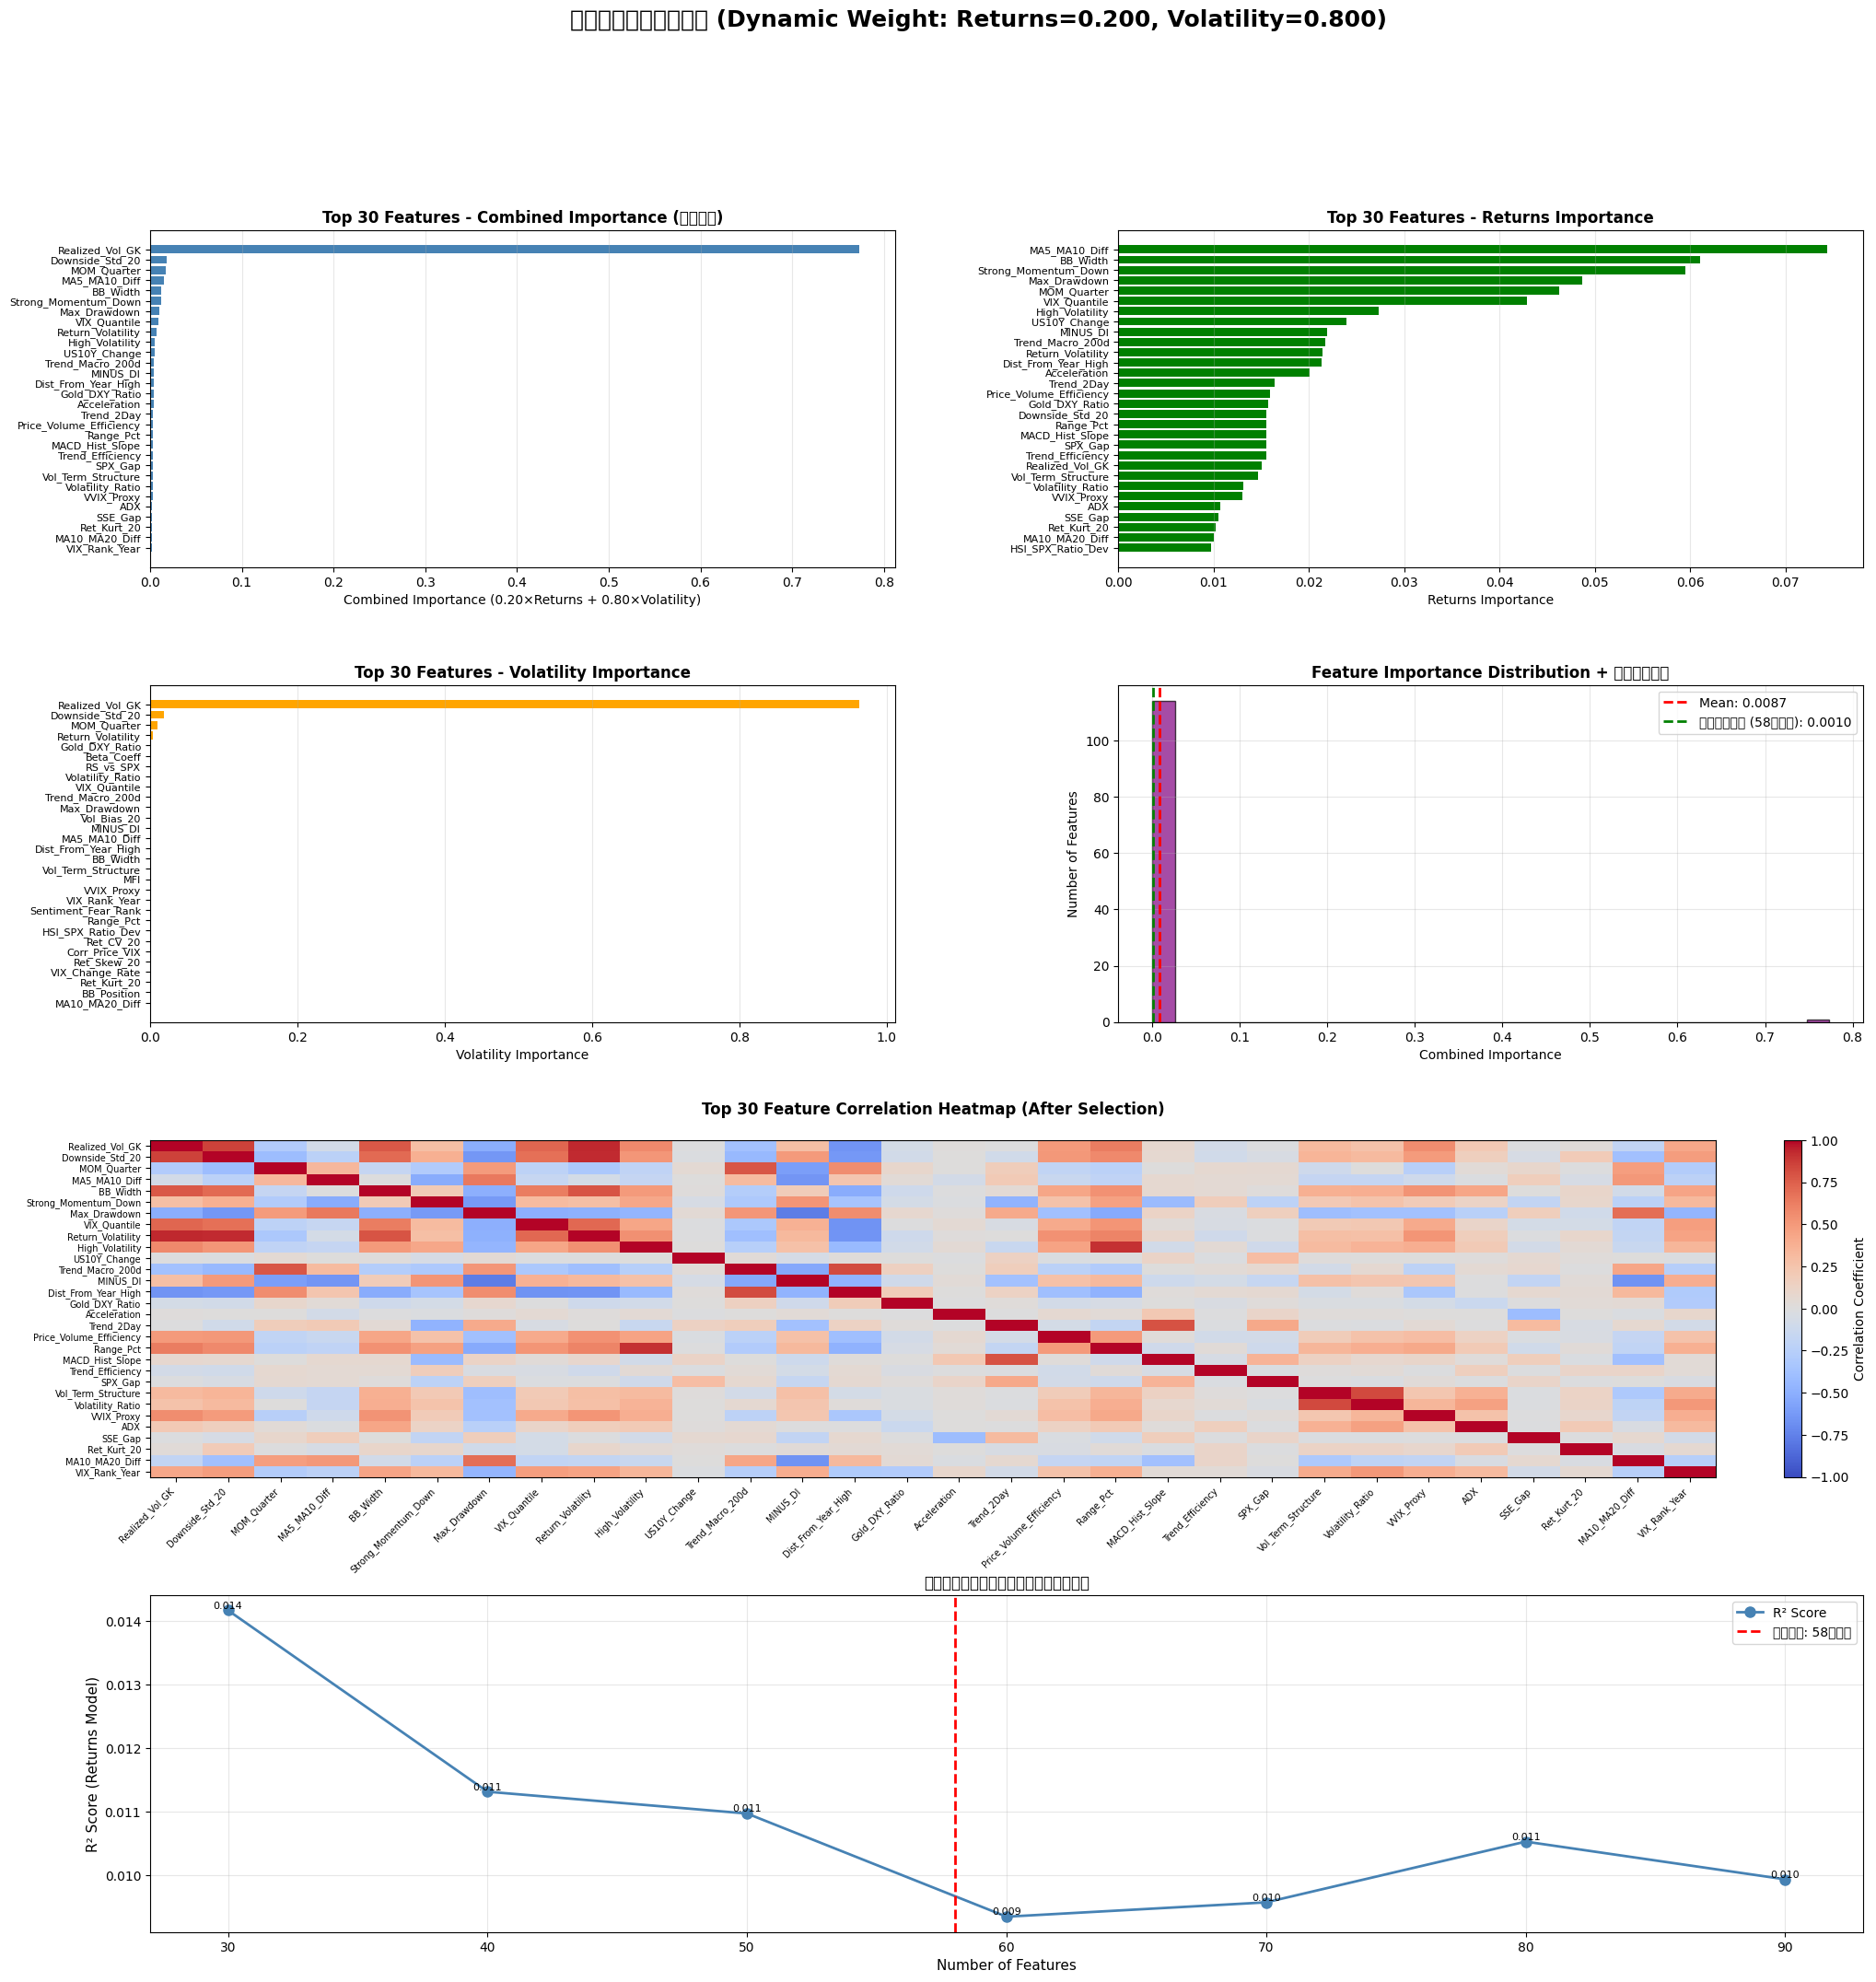


特征筛选性能评估 (Feature Selection Performance Evaluation)
使用动态权重筛选后的特征数: 58
动态权重: 收益率=0.200, 波动率=0.800

筛选后特征模型性能:
  收益率 R²: -0.0057 (原始: -0.0060, 变化: +0.0003)
  收益率 MSE: 2.8051
  波动率 R²: 0.9849 (原始: 0.9849, 变化: -0.0001)
  波动率 MSE: 0.4398

✅ 动态特征筛选完成!
   原始特征数: 123
   共线性剪枝后: 115
   最终筛选后: 58
   总特征保留率: 47.2%
   累积重要性: 98.7%

   性能变化:
     收益率模型: +0.0003 (提升)
     波动率模型: -0.0001 (下降)

   ✅ Selected patterns_df is ready for STEP 2

All Selected Features - Detailed Statistics

Total Selected Features: 58

Feature Statistics Table:
                Feature  Rank  Combined_Importance  Returns_Importance  Volatility_Importance          Mean         Std           Min           Max    Median  Skewness    Kurtosis  Missing_Rate
        Realized_Vol_GK   109             0.773317            0.015064               0.962881  1.488191e+01    6.592851  6.458093e+00     62.780689 13.114853  2.545865   11.228992           0.0
        Downside_Std_20   111             0.017839            0.015560            

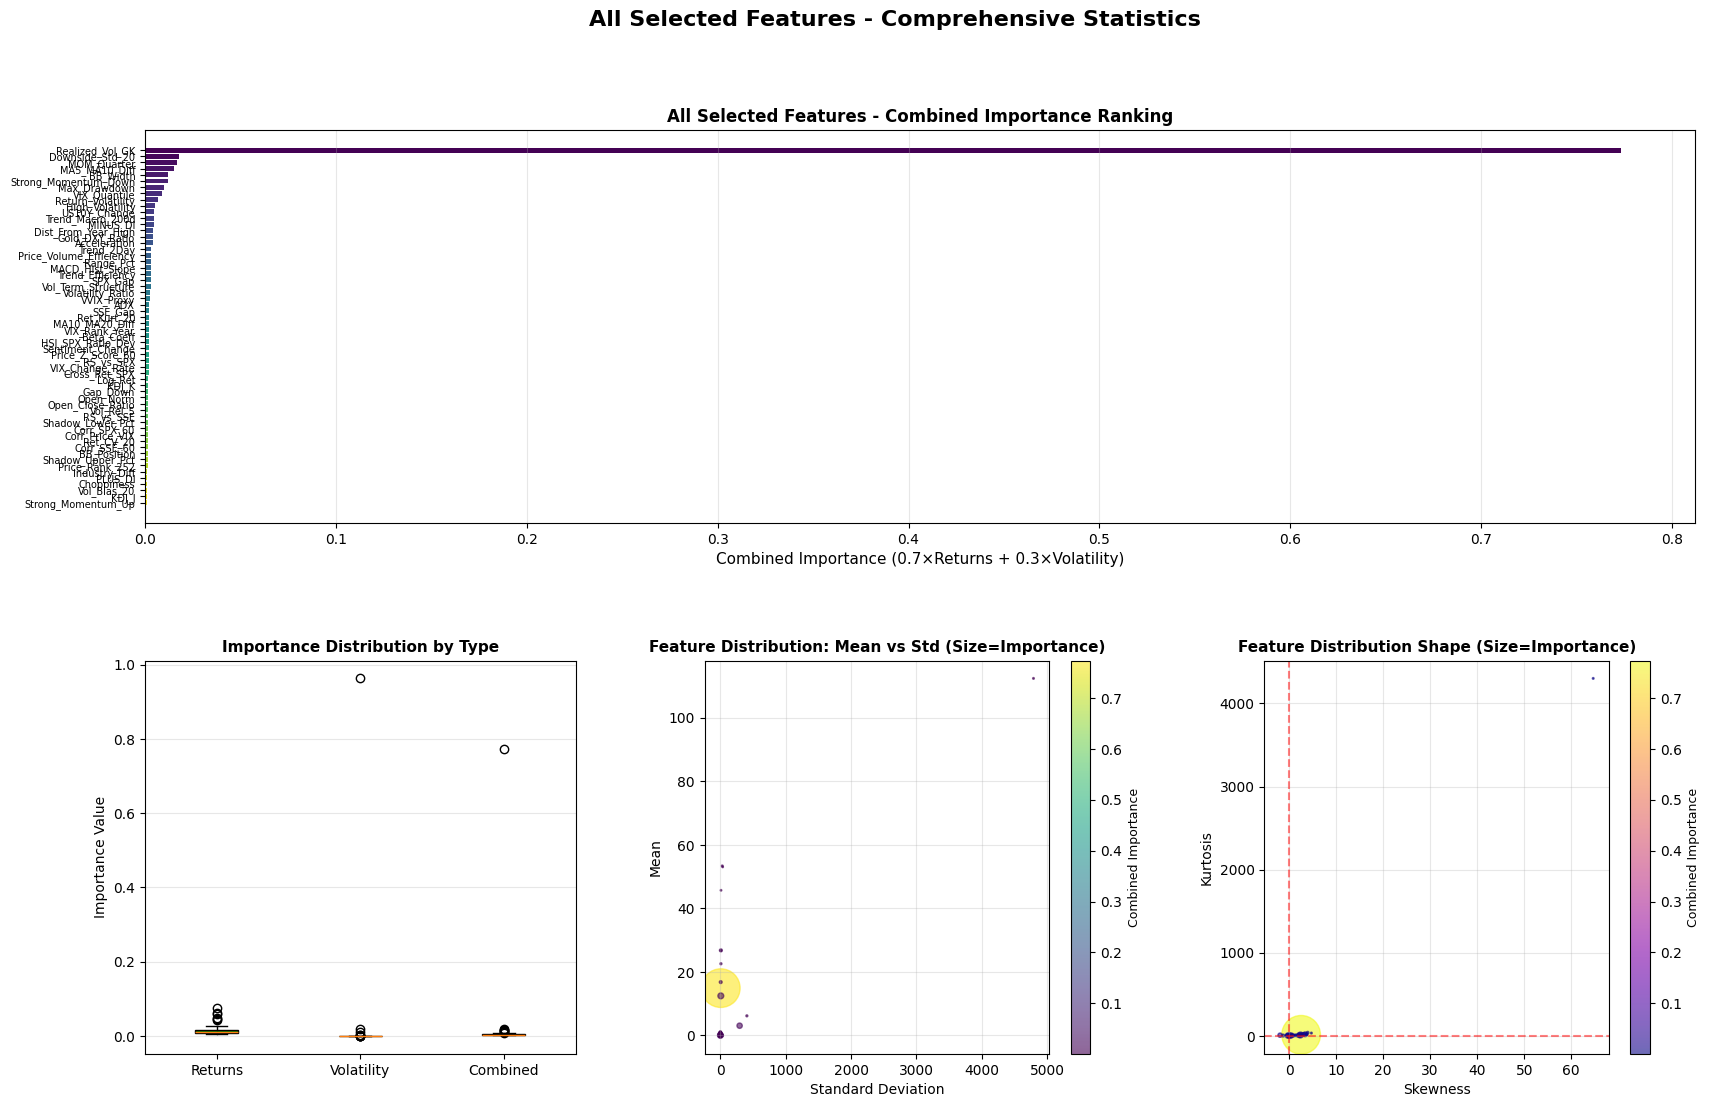


✅ Feature selection and statistics completed!
   Total selected features: 58
   Feature statistics saved in 'features_stats_df' DataFrame


In [45]:
# ============================================================
# STEP 1.5: 动态特征筛选系统 (Dynamic Feature Selection System)
# ============================================================
# 流程：全局扫描 → 共线性剪枝 → 动态权重评估 → 逻辑截断
# ============================================================
print("\n" + "=" * 80)
print("STEP 1.5: 动态特征筛选系统 (Dynamic Feature Selection System)")
print("=" * 80)
print("流程：全局扫描 → 共线性剪枝 → 动态权重评估 → 逻辑截断")

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 阶段1：全局扫描 - 准备数据
# ============================================================
print("\n" + "=" * 80)
print("阶段1：全局扫描 (Global Feature Scanning)")
print("=" * 80)

print("\n准备特征筛选数据...")

# 计算目标变量（收益率和波动率）
target_returns_temp = df['Close'].pct_change().shift(-1) * 100 
target_returns_temp.name = 'Target_Returns'

# 计算波动率（使用Garman-Klass估计器）
def garman_klass_volatility(high, low, close, open_price, window=20, min_periods=10):
    log_hl = np.log(high / low)
    log_co = np.log(close / open_price)
    gk = 0.5 * (log_hl**2) - (2*np.log(2) - 1) * (log_co**2)
    gk_rolling = gk.rolling(window=window, min_periods=min_periods).mean()
    volatility = np.sqrt(gk_rolling * 252) * 100
    return volatility

target_volatility_temp = garman_klass_volatility(
    df['High'], df['Low'], df['Close'], df['Open'], 
    window=20, min_periods=10
)
target_volatility_temp = target_volatility_temp.shift(-1)  # 滞后1期：T日特征 -> T+1日波动率
target_volatility_temp.name = 'Target_Volatility'

# 合并数据
combined_df_temp = pd.concat([patterns_df, target_returns_temp, target_volatility_temp], axis=1, join='inner')
combined_df_temp = combined_df_temp.replace([np.inf, -np.inf], np.nan).dropna()

print(f"✅ 全局扫描完成")
print(f"   总特征数: {combined_df_temp.shape[1] - 2}")
print(f"   目标变量: 2 (收益率 + 波动率)")
print(f"   样本数: {combined_df_temp.shape[0]}")
print("✅ Target variables lagged by 1 period: T-day features -> T+1 performance")

# 分离特征和目标（先保留为DataFrame以便进行相关性分析）
X_feature_selection_df = combined_df_temp.drop(columns=['Target_Returns', 'Target_Volatility'])
feature_names_original = X_feature_selection_df.columns.tolist()

# ============================================================
# 阶段2：共线性剪枝 (Collinearity Pruning)
# ============================================================
print("\n" + "=" * 80)
print("阶段2：共线性剪枝 (Collinearity Pruning)")
print("=" * 80)

# 分离特征和目标（先保留为DataFrame以便进行相关性分析）
X_feature_selection_df = combined_df_temp.drop(columns=['Target_Returns', 'Target_Volatility'])
feature_names_original = X_feature_selection_df.columns.tolist()

CORRELATION_THRESHOLD = 0.95  # Correlation Coefficient阈值
print(f"\n计算特征相关性矩阵 (阈值: {CORRELATION_THRESHOLD})...")

# 计算相关性矩阵
corr_matrix = X_feature_selection_df.corr().abs()

# 找出高度相关的特征对
high_corr_pairs = []
upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
high_corr_mask = (corr_matrix > CORRELATION_THRESHOLD) & upper_triangle

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if high_corr_mask.iloc[i, j]:
            corr_value = corr_matrix.iloc[i, j]
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_value
            })

if high_corr_pairs:
    print(f"\n⚠️ Found {len(high_corr_pairs)} pairs of highly correlated features (correlation > {CORRELATION_THRESHOLD}）:")
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)
    print(high_corr_df.head(20).to_string(index=False))
    
    # 去除冗余特征：对于每对高度相关的特征，保留方差更大的那个
    # 如果方差相同，则保留在DataFrame中位置靠前的特征
    features_to_remove = set()
    
    for pair in high_corr_pairs:
        feat1, feat2 = pair['feature1'], pair['feature2']
        if feat1 not in features_to_remove and feat2 not in features_to_remove:
            # 计算方差，保留方差更大的特征（通常包含更多信息）
            var1 = X_feature_selection_df[feat1].var()
            var2 = X_feature_selection_df[feat2].var()
            
            if var1 >= var2:
                features_to_remove.add(feat2)
            else:
                features_to_remove.add(feat1)
    
    print(f"\nRemoving {len(features_to_remove)} redundant features (keeping features with higher variance):")
    for feat in sorted(features_to_remove):
        print(f"  - {feat}")
    
    # 移除冗余特征
    X_feature_selection_df = X_feature_selection_df.drop(columns=list(features_to_remove))
    feature_names = X_feature_selection_df.columns.tolist()
    
    print(f"\n✅ 共线性剪枝完成")
    print(f"   原始特征数: {len(feature_names_original)}")
    print(f"   剪枝后特征数: {len(feature_names)}")
    print(f"   移除冗余特征数: {len(feature_names_original) - len(feature_names)}")
    print(f"   特征保留率: {len(feature_names)/len(feature_names_original)*100:.1f}%")
else:
    print(f"\n✅ 未发现高度相关的特征对（所有特征相关系数 <= {CORRELATION_THRESHOLD}）")
    feature_names = feature_names_original

# ============================================================
# 阶段3：动态权重评估 (Dynamic Weight Evaluation)
# ============================================================
print("\n" + "=" * 80)
print("阶段3：动态权重评估 (Dynamic Weight Evaluation)")
print("=" * 80)

# 转换为numpy数组
X_feature_selection = X_feature_selection_df.values
y_returns = combined_df_temp['Target_Returns'].values
y_volatility = combined_df_temp['Target_Volatility'].values

# 按时间划分Training set和Test set（用于特征筛选）
split_idx_feature = int(len(X_feature_selection) * 0.8)
X_train_feature = X_feature_selection[:split_idx_feature]
X_test_feature = X_feature_selection[split_idx_feature:]
y_train_returns = y_returns[:split_idx_feature]
y_test_returns = y_returns[split_idx_feature:]
y_train_volatility = y_volatility[:split_idx_feature]
y_test_volatility = y_volatility[split_idx_feature:]

print(f"\n数据划分:")
print(f"  训练集: {len(X_train_feature)} 样本")
print(f"  测试集: {len(X_test_feature)} 样本")

# 步骤1：初始评估（使用固定权重0.7/0.3）
print("\n步骤1：初始特征重要性评估...")

# 1. 收益率模型
rf_returns = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_returns.fit(X_train_feature, y_train_returns)
importance_returns = rf_returns.feature_importances_
pred_returns_initial = rf_returns.predict(X_test_feature)
r2_returns_initial = r2_score(y_test_returns, pred_returns_initial)

# 2. 波动率模型
rf_volatility = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_volatility.fit(X_train_feature, y_train_volatility)
importance_volatility = rf_volatility.feature_importances_
pred_volatility_initial = rf_volatility.predict(X_test_feature)
r2_volatility_initial = r2_score(y_test_volatility, pred_volatility_initial)

print(f"   收益率模型 R²: {r2_returns_initial:.4f}")
print(f"   波动率模型 R²: {r2_volatility_initial:.4f}")

# 步骤2：动态权重计算
# 根据模型表现动态调整权重：表现更好的目标变量获得更高权重
print("\n步骤2：动态权重计算...")

# 计算权重（基于R²的相对表现）
# 如果收益率模型表现更好，增加其权重；反之增加波动率权重
total_r2 = abs(r2_returns_initial) + abs(r2_volatility_initial)
if total_r2 > 0:
    # 归一化权重，但保持最小权重为0.2，最大为0.8
    weight_returns_raw = abs(r2_returns_initial) / total_r2
    weight_volatility_raw = abs(r2_volatility_initial) / total_r2
    
    # 限制权重范围在[0.2, 0.8]之间
    weight_returns = np.clip(weight_returns_raw, 0.2, 0.8)
    weight_volatility = 1.0 - weight_returns
else:
    # 如果两个模型表现都很差，使用默认权重
    weight_returns = 0.7
    weight_volatility = 0.3

print(f"   动态权重: 收益率={weight_returns:.3f}, 波动率={weight_volatility:.3f}")
print(f"   (基于模型表现自动调整)")

# 3. Combined Importance（使用动态权重）
importance_combined = weight_returns * importance_returns + weight_volatility * importance_volatility

# 创建特征重要性DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Returns': importance_returns,
    'Importance_Volatility': importance_volatility,
    'Importance_Combined': importance_combined
}).sort_values('Importance_Combined', ascending=False)

print(f"\n✅ 动态权重评估完成")
print(f"\nTop 10 最重要特征:")
print(importance_df.head(10)[['Feature', 'Importance_Combined']].to_string(index=False))

# ============================================================
# 阶段4：逻辑截断 (Logical Truncation)
# ============================================================
print("\n" + "=" * 80)
print("阶段4：逻辑截断 (Logical Truncation)")
print("=" * 80)

# 逻辑截断策略：基于多个指标自动确定最优特征数量
print("\n执行逻辑截断分析...")

# 策略1：重要性分布分析
importance_mean = importance_df['Importance_Combined'].mean()
importance_std = importance_df['Importance_Combined'].std()
importance_median = importance_df['Importance_Combined'].median()

# 计算重要性下降的拐点（elbow point）
importance_diff = importance_df['Importance_Combined'].diff().abs()
# 找到重要性下降最陡的点
elbow_idx = importance_diff.idxmax() if len(importance_diff) > 0 else len(importance_df) // 2

# 策略2：累积重要性分析（保留累积重要性达到80%的特征）
cumulative_importance = importance_df['Importance_Combined'].cumsum()
cumulative_importance_pct = cumulative_importance / cumulative_importance.iloc[-1]
threshold_80_idx = (cumulative_importance_pct >= 0.80).idxmax() if (cumulative_importance_pct >= 0.80).any() else len(importance_df)

# 策略3：性能验证（测试不同特征数量的模型性能）
print("\n测试不同特征数量的模型性能...")
test_sizes = [30, 40, 50, 60, 70, 80, min(90, len(feature_names))]
performance_scores = []

for n_features in test_sizes:
    if n_features > len(feature_names):
        continue
    
    test_features = importance_df.head(n_features)['Feature'].tolist()
    X_train_test = X_train_feature[:, [feature_names.index(f) for f in test_features]]
    X_test_test = X_test_feature[:, [feature_names.index(f) for f in test_features]]
    
    # 快速评估（使用较少的树）
    rf_test = RandomForestRegressor(
        n_estimators=50,  # 减少树数量以加快速度
        max_depth=8,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    )
    rf_test.fit(X_train_test, y_train_returns)
    pred_test = rf_test.predict(X_test_test)
    r2_test = r2_score(y_test_returns, pred_test)
    
    performance_scores.append({
        'n_features': n_features,
        'r2': r2_test,
        'cumulative_importance': cumulative_importance_pct.iloc[n_features-1] if n_features <= len(cumulative_importance_pct) else 1.0
    })

perf_df = pd.DataFrame(performance_scores)

# 找到性能提升的拐点（边际收益递减点）
if len(perf_df) > 1:
    perf_df['r2_diff'] = perf_df['r2'].diff()
    # 找到R²提升小于0.001的点（边际收益很小）
    optimal_idx = (perf_df['r2_diff'] < 0.001).idxmax() if (perf_df['r2_diff'] < 0.001).any() else len(perf_df) - 1
    optimal_n_features = perf_df.iloc[optimal_idx]['n_features']
else:
    optimal_n_features = 60  # 默认值

# 策略4：综合决策
# 综合考虑：拐点、累积重要性80%、性能最优
candidates = [
    int(elbow_idx) + 1,  # 拐点
    int(threshold_80_idx) + 1,  # 累积80%
    int(optimal_n_features),  # 性能最优
    60  # 默认值
]

# 选择中位数作为最终特征数（更稳健）
final_n_features = int(np.median(candidates))
final_n_features = np.clip(final_n_features, 30, min(80, len(feature_names)))  # 限制在合理范围

selected_features = importance_df.head(final_n_features)['Feature'].tolist()

print(f"\n逻辑截断分析结果:")
print(f"   重要性拐点: {int(elbow_idx) + 1} 个特征")
print(f"   累积80%重要性: {int(threshold_80_idx) + 1} 个特征")
print(f"   性能最优: {int(optimal_n_features)} 个特征")
print(f"   综合决策: {final_n_features} 个特征")
print(f"\n✅ 逻辑截断完成")
print(f"   原始特征数: {len(feature_names)}")
print(f"   筛选后特征数: {len(selected_features)}")
print(f"   特征保留率: {len(selected_features)/len(feature_names)*100:.1f}%")
print(f"   累积重要性: {cumulative_importance_pct.iloc[final_n_features-1]*100:.1f}%")

# 更新patterns_df为筛选后的特征
patterns_df = patterns_df[selected_features].copy()

print(f"\n✅ patterns_df updated with selected features")
print(f"   New shape: {patterns_df.shape}")

# ============================================================
# 保存筛选后的特征列表到文件（供STEP 8使用）
# ============================================================
SAVE_DIR = './model_artifacts'
os.makedirs(SAVE_DIR, exist_ok=True)

selected_features_path = os.path.join(SAVE_DIR, 'selected_features.json')
with open(selected_features_path, 'w', encoding='utf-8') as f:
    json.dump(selected_features, f, indent=2, ensure_ascii=False)

# 同时保存动态权重和逻辑截断参数
feature_selection_metadata = {
    'selected_features': selected_features,
    'num_features_original': len(feature_names_original),
    'num_features_after_collinearity': len(feature_names),
    'num_features_selected': len(selected_features),
    'weight_returns': float(weight_returns),
    'weight_volatility': float(weight_volatility),
    'final_n_features': int(final_n_features),
    'elbow_idx': int(elbow_idx) + 1,
    'threshold_80_idx': int(threshold_80_idx) + 1,
    'optimal_n_features': int(optimal_n_features)
}

metadata_path = os.path.join(SAVE_DIR, 'feature_selection_metadata.json')
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(feature_selection_metadata, f, indent=2, ensure_ascii=False)

print(f"\n✅ 特征筛选结果已保存:")
print(f"   - {selected_features_path}")
print(f"   - {metadata_path}")

# ============================================================
# 可视化特征重要性
# ============================================================
print("\nGenerating feature importance visualization charts...")

# 创建图表（4行2列，添加性能对比和逻辑截断分析）
fig = plt.figure(figsize=(24, 24))
fig.suptitle(f'动态特征筛选系统分析 (Dynamic Weight: Returns={weight_returns:.3f}, Volatility={weight_volatility:.3f})', 
             fontsize=18, fontweight='bold')

# 创建子图布局
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, :])  # 相关性热图
ax6 = fig.add_subplot(gs[3, :])  # 性能对比图

# 1. Combined Importance - Top 30（使用动态权重）
top_30 = importance_df.head(30)
ax1.barh(range(len(top_30)), top_30['Importance_Combined'].values, color='steelblue')
ax1.set_yticks(range(len(top_30)))
ax1.set_yticklabels(top_30['Feature'].values, fontsize=8)
ax1.set_xlabel(f'Combined Importance ({weight_returns:.2f}×Returns + {weight_volatility:.2f}×Volatility)', fontsize=10)
ax1.set_title('Top 30 Features - Combined Importance (动态权重)', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# 2. Returns Importance - Top 30
top_30_returns = importance_df.sort_values('Importance_Returns', ascending=False).head(30)
ax2.barh(range(len(top_30_returns)), top_30_returns['Importance_Returns'].values, color='green')
ax2.set_yticks(range(len(top_30_returns)))
ax2.set_yticklabels(top_30_returns['Feature'].values, fontsize=8)
ax2.set_xlabel('Returns Importance', fontsize=10)
ax2.set_title('Top 30 Features - Returns Importance', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. Volatility Importance - Top 30
top_30_volatility = importance_df.sort_values('Importance_Volatility', ascending=False).head(30)
ax3.barh(range(len(top_30_volatility)), top_30_volatility['Importance_Volatility'].values, color='orange')
ax3.set_yticks(range(len(top_30_volatility)))
ax3.set_yticklabels(top_30_volatility['Feature'].values, fontsize=8)
ax3.set_xlabel('Volatility Importance', fontsize=10)
ax3.set_title('Top 30 Features - Volatility Importance', fontsize=12, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# 4. Importance Distribution Histogram（显示逻辑截断阈值）
ax4.hist(importance_df['Importance_Combined'].values, bins=30, color='purple', alpha=0.7, edgecolor='black')
ax4.axvline(importance_df['Importance_Combined'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {importance_df["Importance_Combined"].mean():.4f}')
ax4.axvline(importance_df.head(final_n_features)['Importance_Combined'].min(), color='green', linestyle='--', linewidth=2, 
            label=f'逻辑截断阈值 ({final_n_features}个特征): {importance_df.head(final_n_features)["Importance_Combined"].min():.4f}')
ax4.set_xlabel('Combined Importance', fontsize=10)
ax4.set_ylabel('Number of Features', fontsize=10)
ax4.set_title('Feature Importance Distribution + 逻辑截断阈值', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 6. 性能对比图（不同特征数量的R²）
if len(perf_df) > 0:
    ax6.plot(perf_df['n_features'], perf_df['r2'], marker='o', linewidth=2, markersize=8, color='steelblue', label='R² Score')
    ax6.axvline(final_n_features, color='red', linestyle='--', linewidth=2, label=f'最终选择: {final_n_features}个特征')
    ax6.set_xlabel('Number of Features', fontsize=11)
    ax6.set_ylabel('R² Score (Returns Model)', fontsize=11)
    ax6.set_title('逻辑截断分析：不同特征数量的模型性能', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    # 添加数值标签
    for _, row in perf_df.iterrows():
        ax6.text(row['n_features'], row['r2'], f'{row["r2"]:.3f}', 
                ha='center', va='bottom', fontsize=8)

# 5. 特征相关性热图（筛选后的Top特征）
print("\nGenerating feature correlation heatmap (Top features after selection)...")
top_features_for_corr = importance_df.head(min(30, len(selected_features)))['Feature'].tolist()
X_selected_df = X_feature_selection_df[top_features_for_corr]
corr_matrix_selected = X_selected_df.corr()

# 绘制热图
im = ax5.imshow(corr_matrix_selected.values, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax5.set_xticks(range(len(corr_matrix_selected.columns)))
ax5.set_yticks(range(len(corr_matrix_selected.columns)))
ax5.set_xticklabels(corr_matrix_selected.columns, rotation=45, ha='right', fontsize=7)
ax5.set_yticklabels(corr_matrix_selected.columns, fontsize=7)
ax5.set_title(f'Top {len(top_features_for_corr)} Feature Correlation Heatmap (After Selection)', fontsize=12, fontweight='bold', pad=20)

# 添加颜色条
cbar = plt.colorbar(im, ax=ax5, fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient', fontsize=10)

# 在热图上标注高相关性（>0.95）
for i in range(len(corr_matrix_selected.columns)):
    for j in range(len(corr_matrix_selected.columns)):
        if i != j and abs(corr_matrix_selected.iloc[i, j]) > 0.95:
            ax5.text(j, i, f'{corr_matrix_selected.iloc[i, j]:.2f}', 
                    ha='center', va='center', fontsize=6, 
                    color='white' if abs(corr_matrix_selected.iloc[i, j]) > 0.5 else 'black',
                    weight='bold')

plt.show()

# ============================================================
# 特征筛选性能评估 (Feature Selection Performance Evaluation)
# ============================================================
print("\n" + "=" * 80)
print("特征筛选性能评估 (Feature Selection Performance Evaluation)")
print("=" * 80)
print(f"使用动态权重筛选后的特征数: {len(selected_features)}")
print(f"动态权重: 收益率={weight_returns:.3f}, 波动率={weight_volatility:.3f}")

# 使用筛选后的特征重新训练模型
X_train_selected = X_train_feature[:, [feature_names.index(f) for f in selected_features]]
X_test_selected = X_test_feature[:, [feature_names.index(f) for f in selected_features]]

# 收益率模型评估
rf_returns_selected = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_returns_selected.fit(X_train_selected, y_train_returns)
pred_returns_selected = rf_returns_selected.predict(X_test_selected)

# 波动率模型评估
rf_volatility_selected = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_volatility_selected.fit(X_train_selected, y_train_volatility)
pred_volatility_selected = rf_volatility_selected.predict(X_test_selected)

# 计算指标
r2_returns_selected = r2_score(y_test_returns, pred_returns_selected)
r2_volatility_selected = r2_score(y_test_volatility, pred_volatility_selected)
mse_returns_selected = mean_squared_error(y_test_returns, pred_returns_selected)
mse_volatility_selected = mean_squared_error(y_test_volatility, pred_volatility_selected)

print(f"\n筛选后特征模型性能:")
print(f"  收益率 R²: {r2_returns_selected:.4f} (原始: {r2_returns_initial:.4f}, 变化: {r2_returns_selected-r2_returns_initial:+.4f})")
print(f"  收益率 MSE: {mse_returns_selected:.4f}")
print(f"  波动率 R²: {r2_volatility_selected:.4f} (原始: {r2_volatility_initial:.4f}, 变化: {r2_volatility_selected-r2_volatility_initial:+.4f})")
print(f"  波动率 MSE: {mse_volatility_selected:.4f}")

# 计算性能提升
r2_improvement_returns = r2_returns_selected - r2_returns_initial
r2_improvement_volatility = r2_volatility_selected - r2_volatility_initial

print(f"\n✅ 动态特征筛选完成!")
print(f"   原始特征数: {len(feature_names_original)}")
print(f"   共线性剪枝后: {len(feature_names)}")
print(f"   最终筛选后: {len(selected_features)}")
print(f"   总特征保留率: {len(selected_features)/len(feature_names_original)*100:.1f}%")
print(f"   累积重要性: {cumulative_importance_pct.iloc[final_n_features-1]*100:.1f}%")
print(f"\n   性能变化:")
print(f"     收益率模型: {r2_improvement_returns:+.4f} ({'提升' if r2_improvement_returns > 0 else '下降'})")
print(f"     波动率模型: {r2_improvement_volatility:+.4f} ({'提升' if r2_improvement_volatility > 0 else '下降'})")
print(f"\n   ✅ Selected patterns_df is ready for STEP 2")


# ============================================================
# Display All Selected Features with Detailed Statistics
# ============================================================
print("\n" + "=" * 60)
print("All Selected Features - Detailed Statistics")
print("=" * 60)

# 计算每个特征的统计信息
selected_features_stats = []
for feat in selected_features:
    feat_data = X_feature_selection_df[feat]
    feat_importance = importance_df[importance_df['Feature'] == feat].iloc[0]
    
    stats = {
        'Feature': feat,
        'Rank': importance_df[importance_df['Feature'] == feat].index[0] + 1,
        'Combined_Importance': feat_importance['Importance_Combined'],
        'Returns_Importance': feat_importance['Importance_Returns'],
        'Volatility_Importance': feat_importance['Importance_Volatility'],
        'Mean': feat_data.mean(),
        'Std': feat_data.std(),
        'Min': feat_data.min(),
        'Max': feat_data.max(),
        'Median': feat_data.median(),
        'Skewness': feat_data.skew(),
        'Kurtosis': feat_data.kurtosis(),
        'Missing_Rate': (feat_data.isna().sum() / len(feat_data)) * 100
    }
    selected_features_stats.append(stats)

# 创建统计DataFrame
features_stats_df = pd.DataFrame(selected_features_stats)

# 格式化显示
print(f"\nTotal Selected Features: {len(selected_features)}")
print(f"\n{'='*120}")
print("Feature Statistics Table:")
print(f"{'='*120}")

# 显示所有特征的统计信息
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30)

print(features_stats_df.to_string(index=False))

# 创建可视化：所有筛选后特征的重要性对比
print("\nGenerating comprehensive feature statistics visualization...")

fig2 = plt.figure(figsize=(20, 12))
fig2.suptitle('All Selected Features - Comprehensive Statistics', fontsize=16, fontweight='bold')

gs2 = fig2.add_gridspec(2, 3, hspace=0.35, wspace=0.3)

# 1. 所有特征的综合重要性条形图
ax1 = fig2.add_subplot(gs2[0, :])
y_pos = np.arange(len(selected_features))
importance_values = [importance_df[importance_df['Feature'] == f].iloc[0]['Importance_Combined'] for f in selected_features]
colors = plt.cm.viridis(np.linspace(0, 1, len(selected_features)))
ax1.barh(y_pos, importance_values, color=colors)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(selected_features, fontsize=7)
ax1.set_xlabel('Combined Importance (0.7×Returns + 0.3×Volatility)', fontsize=11)
ax1.set_title('All Selected Features - Combined Importance Ranking', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# 2. 重要性分布箱线图
ax2 = fig2.add_subplot(gs2[1, 0])
importance_data = [
    features_stats_df['Returns_Importance'].values,
    features_stats_df['Volatility_Importance'].values,
    features_stats_df['Combined_Importance'].values
]
bp = ax2.boxplot(importance_data, tick_labels=['Returns', 'Volatility', 'Combined'], patch_artist=True)
bp['boxes'][0].set_facecolor('green')
bp['boxes'][1].set_facecolor('orange')
bp['boxes'][2].set_facecolor('steelblue')
ax2.set_ylabel('Importance Value', fontsize=10)
ax2.set_title('Importance Distribution by Type', fontsize=11, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. 统计量分布（均值 vs 标准差）
ax3 = fig2.add_subplot(gs2[1, 1])
ax3.scatter(features_stats_df['Std'], features_stats_df['Mean'], 
           s=features_stats_df['Combined_Importance']*1000, 
           alpha=0.6, c=features_stats_df['Combined_Importance'], cmap='viridis')
ax3.set_xlabel('Standard Deviation', fontsize=10)
ax3.set_ylabel('Mean', fontsize=10)
ax3.set_title('Feature Distribution: Mean vs Std (Size=Importance)', fontsize=11, fontweight='bold')
ax3.grid(alpha=0.3)
cbar3 = plt.colorbar(ax3.collections[0], ax=ax3)
cbar3.set_label('Combined Importance', fontsize=9)

# 4. 偏度和峰度分布
ax4 = fig2.add_subplot(gs2[1, 2])
ax4.scatter(features_stats_df['Skewness'], features_stats_df['Kurtosis'],
           s=features_stats_df['Combined_Importance']*1000,
           alpha=0.6, c=features_stats_df['Combined_Importance'], cmap='plasma')
ax4.set_xlabel('Skewness', fontsize=10)
ax4.set_ylabel('Kurtosis', fontsize=10)
ax4.set_title('Feature Distribution Shape (Size=Importance)', fontsize=11, fontweight='bold')
ax4.axvline(0, color='red', linestyle='--', alpha=0.5)
ax4.axhline(0, color='red', linestyle='--', alpha=0.5)
ax4.grid(alpha=0.3)
cbar4 = plt.colorbar(ax4.collections[0], ax=ax4)
cbar4.set_label('Combined Importance', fontsize=9)

plt.show()

# 保存特征统计信息到CSV（可选）
print(f"\n✅ Feature selection and statistics completed!")
print(f"   Total selected features: {len(selected_features)}")
print(f"   Feature statistics saved in 'features_stats_df' DataFrame")


In [21]:
# ============================================================
# STEP 2: Data split 
# ============================================================
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

print("\n[STEP 2] Preparing Data (Target: Daily Returns % + Volatility %)...")

# 1. 准备数据 & 目标定义（双输出：收益率 + 波动率）
# ⚠️ 重要修正：目标变量必须滞后1期（shift(-1)），用T日特征预测T+1日表现
# 目标1：收益率（%）
target_returns = df['Close'].pct_change().shift(-1) * 100  # 滞后1期：T日特征 -> T+1日收益率
target_returns.name = 'Target_Returns'

# 目标2：波动率（%），使用Garman-Klass估计器（Realized Volatility的日度版本）
def garman_klass_volatility(high, low, close, open_price, window=20, min_periods=10):
    """
    Garman-Klass波动率估计器
    使用OHLC数据估计已实现波动率，比简单标准差更准确
    参考: Garman, M. B., & Klass, M. J. (1980)
    
    改进：在 log(low) 和 log(open_price) 中加入 1e-10，防止分母为 0 导致的 inf 报错
    """
    # 稳定性改进：确保 low 和 open_price 不为 0
    low_safe = low + 1e-10
    open_safe = open_price + 1e-10
    
    log_hl = np.log(high / low_safe)
    log_co = np.log(close / open_safe)
    
    # Garman-Klass公式：利用高低价差和收盘价变化
    gk = 0.5 * (log_hl**2) - (2*np.log(2) - 1) * (log_co**2)
    
    # 滚动平均并年化（252个交易日）
    gk_rolling = gk.rolling(window=window, min_periods=min_periods).mean()
    volatility = np.sqrt(gk_rolling * 252) * 100  # 年化并转为百分比
    
    return volatility

target_volatility = garman_klass_volatility(
    df['High'], df['Low'], df['Close'], df['Open'], 
    window=20, min_periods=10
)
target_volatility = target_volatility.shift(-1)  # 滞后1期：T日特征 -> T+1日波动率
target_volatility.name = 'Target_Volatility'

# 合并两个目标变量
target_series = pd.concat([target_returns, target_volatility], axis=1)

# 2. 合并特征和目标
combined_df = pd.concat([patterns_df, target_series], axis=1, join='inner')
combined_df = combined_df.replace([np.inf, -np.inf], np.nan).dropna()

print(f"Data Aligned Successfully! New Shape: {combined_df.shape}")
print(f"Date Range: {combined_df.index[0].date()} to {combined_df.index[-1].date()}")

# 3. 分离 X 和 y (用于统计和切分)
# y_raw 现在是2列：[收益率, 波动率]
X_raw = combined_df.drop(columns=['Target_Returns', 'Target_Volatility']).values
y_raw = combined_df[['Target_Returns', 'Target_Volatility']].values

dates_clean = combined_df.index
print(f"Cleaned Data Samples: {len(X_raw)}")

# 4. 严格按时间划分训练集/测试集（先切分，再处理异常值，避免数据泄露）
# ⚠️ 重要：先切分，再基于训练集计算分位数，确保模型完全不知道测试集的数据分布
TRAIN_SPLIT_RATIO = 0.8
split_idx = int(len(X_raw) * TRAIN_SPLIT_RATIO)

# 切分原始数据
X_train_raw = X_raw[:split_idx]
y_train_raw = y_raw[:split_idx]
X_test_raw = X_raw[split_idx:]
y_test_raw = y_raw[split_idx:]

train_dates = dates_clean[:split_idx]
test_dates_raw = dates_clean[split_idx:]

print(f"Train samples: {len(X_train_raw)}, Test samples: {len(X_test_raw)}")

# 5. 异常值处理：使用分位数截断（仅在训练集上计算分位数，避免数据泄露）
# ⚠️ 关键改进：先切分，再基于训练集计算分位数，符合严谨的回测逻辑
OUTLIER_METHOD = 'quantile'  # 可选: '5sigma' 或 'quantile'

if OUTLIER_METHOD == 'quantile':
    # 方法1：使用训练集的1%/99%分位数截断（更稳健，不受极端值影响）
    # 仅在训练集上计算分位数
    y_train_returns_series = pd.Series(y_train_raw[:, 0], index=train_dates)
    y_train_volatility_series = pd.Series(y_train_raw[:, 1], index=train_dates)
    
    returns_lower = y_train_returns_series.quantile(0.01)
    returns_upper = y_train_returns_series.quantile(0.99)
    volatility_lower = y_train_volatility_series.quantile(0.01)
    volatility_upper = y_train_volatility_series.quantile(0.99)
    
    # 对训练集和测试集都应用训练集的分位数进行截断
    y_train_raw[:, 0] = np.clip(y_train_raw[:, 0], returns_lower, returns_upper)
    y_train_raw[:, 1] = np.clip(y_train_raw[:, 1], volatility_lower, volatility_upper)
    y_test_raw[:, 0] = np.clip(y_test_raw[:, 0], returns_lower, returns_upper)
    y_test_raw[:, 1] = np.clip(y_test_raw[:, 1], volatility_lower, volatility_upper)
    
    print(f"✅ 异常值处理完成 (基于训练集分位数)")
    print(f"   收益率截断范围: [{returns_lower:.2f}%, {returns_upper:.2f}%]")
    print(f"   波动率截断范围: [{volatility_lower:.2f}%, {volatility_upper:.2f}%]")
    
else:
    # 方法2：使用训练集的5σ法则（比3σ更宽松）
    returns_mean = y_train_raw[:, 0].mean()
    returns_std = y_train_raw[:, 0].std()
    volatility_mean = y_train_raw[:, 1].mean()
    volatility_std = y_train_raw[:, 1].std()
    
    # 对训练集和测试集都应用训练集的统计量进行截断
    y_train_raw[:, 0] = np.clip(y_train_raw[:, 0], 
                                returns_mean - 5 * returns_std, 
                                returns_mean + 5 * returns_std)
    y_train_raw[:, 1] = np.clip(y_train_raw[:, 1],
                                volatility_mean - 5 * volatility_std,
                                volatility_mean + 5 * volatility_std)
    y_test_raw[:, 0] = np.clip(y_test_raw[:, 0],
                              returns_mean - 5 * returns_std,
                              returns_mean + 5 * returns_std)
    y_test_raw[:, 1] = np.clip(y_test_raw[:, 1],
                              volatility_mean - 5 * volatility_std,
                              volatility_mean + 5 * volatility_std)
    
    print(f"✅ 异常值处理完成 (基于训练集5σ法则)")

# 6. 标准化 (Standardization)
scaler = StandardScaler()
# 目标变量需要分别标准化（收益率和波动率）
scaler_target_returns = StandardScaler()

# 波动率归一化策略选择（改进：波动率具有右偏性，需要特殊处理）
VOLATILITY_SCALING_METHOD = 'log_standard'  # 可选: 'log_standard', 'minmax', 'standard'

if VOLATILITY_SCALING_METHOD == 'log_standard':
    # 方法1：对数变换 + StandardScaler（推荐）
    # 波动率具有右偏性，对数变换可以使其更接近正态分布
    scaler_target_volatility = StandardScaler()
    print("✅ 波动率使用 Log1p + StandardScaler")
elif VOLATILITY_SCALING_METHOD == 'minmax':
    # 方法2：MinMaxScaler 缩放到 [0, 1]
    scaler_target_volatility = MinMaxScaler()
    print("✅ 波动率使用 MinMaxScaler 归一化到 [0, 1]")
else:
    # 方法3：StandardScaler（原始方法，不推荐）
    scaler_target_volatility = StandardScaler()
    print("⚠️ 波动率使用 StandardScaler（可能受极端值影响）")

# 仅在训练集上 fit
X_train_scaled = scaler.fit_transform(X_train_raw)

# 分别标准化收益率和波动率
y_train_returns_scaled = scaler_target_returns.fit_transform(y_train_raw[:, 0:1])

# 波动率归一化（根据选择的方法）
if VOLATILITY_SCALING_METHOD == 'log_standard':
    # 对波动率取对数（使用log1p避免0值问题）
    y_train_volatility_log = np.log1p(y_train_raw[:, 1:2])  # log1p(x) = log(1+x)
    y_train_volatility_scaled = scaler_target_volatility.fit_transform(y_train_volatility_log)
    print("✅ 训练集波动率：已执行 log1p 变换")
else:
    y_train_volatility_scaled = scaler_target_volatility.fit_transform(y_train_raw[:, 1:2])

y_train_scaled = np.concatenate([y_train_returns_scaled, y_train_volatility_scaled], axis=1)

# 测试集应用相同的参数 transform（确保一致性）
X_test_scaled = scaler.transform(X_test_raw)
y_test_returns_scaled = scaler_target_returns.transform(y_test_raw[:, 0:1])

# 波动率归一化（根据选择的方法）- 测试集也要执行 log1p
if VOLATILITY_SCALING_METHOD == 'log_standard':
    y_test_volatility_log = np.log1p(y_test_raw[:, 1:2])  # 测试集也要执行 log1p
    y_test_volatility_scaled = scaler_target_volatility.transform(y_test_volatility_log)
    print("✅ 测试集波动率：已执行 log1p 变换")
else:
    y_test_volatility_scaled = scaler_target_volatility.transform(y_test_raw[:, 1:2])

y_test_scaled = np.concatenate([y_test_returns_scaled, y_test_volatility_scaled], axis=1)

# 7. 创建时间序列 (Sliding Window)
SEQUENCE_LENGTH = 30

def create_sequences(X_data, y_data, seq_len):
    """
    创建时间序列滑动窗口
    返回: (X_sequences, y_targets)
    """
    Xs, ys = [], []
    if len(X_data) <= seq_len:
        return np.array(Xs), np.array(ys)

    for i in range(len(X_data) - seq_len):
        Xs.append(X_data[i:(i + seq_len)])
        ys.append(y_data[i + seq_len])  # 使用 seq_len 位置的目标值
    return np.array(Xs), np.array(ys)

# 生成训练集序列
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)

# 处理测试集边界：对齐逻辑优化
# 将训练集最后 SEQUENCE_LENGTH 天拼接到测试集前，确保 X_test 的第一个样本
# 预测的就是 test_dates_raw[0] 的目标值
X_test_source = np.concatenate([X_train_scaled[-SEQUENCE_LENGTH:], X_test_scaled], axis=0)
y_test_source = np.concatenate([y_train_scaled[-SEQUENCE_LENGTH:], y_test_scaled], axis=0)

# 生成测试集序列
X_test, y_test = create_sequences(X_test_source, y_test_source, SEQUENCE_LENGTH)

# 对齐逻辑优化：确保 X_test 和 test_dates_raw 完美对齐
# X_test[0] 预测的是 test_dates_raw[0] 的目标值
test_dates = test_dates_raw

# 验证对齐：X_test 的长度应该等于 test_dates_raw 的长度
assert len(X_test) == len(test_dates_raw), \
    f"对齐错误: X_test长度({len(X_test)}) != test_dates_raw长度({len(test_dates_raw)})"
print(f"✅ 测试集对齐验证通过: X_test({len(X_test)}) == test_dates({len(test_dates)})")

# 8. 转换为 PyTorch Tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print("\n" + "=" * 40)
print("FINAL DATA SHAPES (PyTorch Ready)")
print("=" * 40)
print(f"X_train: {X_train_tensor.shape}")
print(f"y_train: {y_train_tensor.shape}")
print(f"X_test:  {X_test_tensor.shape}")
print(f"y_test:  {y_test_tensor.shape}")
print(f"Test dates length: {len(test_dates)}")
print(f"Using Device: {device}")

# 最终验证
assert len(X_train) > 0, "训练集为空，请检查数据量或缩短序列长度"
assert len(X_test) == len(test_dates), \
    f"测试集对齐错误: 预测数 {len(X_test)} != 日期数 {len(test_dates)}"
print("=" * 40)




[STEP 2] Preparing Data (Target: Daily Returns % + Volatility %)...
Data Aligned Successfully! New Shape: (4659, 62)
Date Range: 2007-01-22 to 2025-12-24
Cleaned Data Samples: 4659
Train samples: 3727, Test samples: 932
✅ 异常值处理完成 (基于训练集分位数)
   收益率截断范围: [-4.25%, 3.81%]
   波动率截断范围: [7.52%, 40.15%]
✅ 波动率使用 Log1p + StandardScaler
✅ 训练集波动率：已执行 log1p 变换
✅ 测试集波动率：已执行 log1p 变换
✅ 测试集对齐验证通过: X_test(932) == test_dates(932)

FINAL DATA SHAPES (PyTorch Ready)
X_train: torch.Size([3697, 30, 60])
y_train: torch.Size([3697, 2])
X_test:  torch.Size([932, 30, 60])
y_test:  torch.Size([932, 2])
Test dates length: 932
Using Device: cpu


In [22]:
# ============================================================
# STEP 3: BUILD & TRAIN PYTORCH MODEL (双塔架构)
# ============================================================

# ============================================================
# 1. 导入所有依赖库
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
import pickle
import json
import os
import shutil

# ============================================================
# 2. 模型配置参数
# ============================================================
# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 模型架构参数
NUM_PATTERNS = X_train_tensor.shape[2]  # 从数据自动获取
HIDDEN_SIZE = 64  # LSTM隐藏层维度
NUM_LSTM_LAYERS = 1  # LSTM层数
DROPOUT = 0.4  # Dropout比率

# 训练参数
LEARNING_RATE = 0.0003  # 初始学习率
WEIGHT_DECAY = 1e-3  # 权重衰减（L2正则化）
BATCH_SIZE = 128  # 批次大小
EPOCHS = 100  # 最大训练轮数
PATIENCE = 12  # 早停耐心值
VAL_SPLIT_RATIO = 0.2  # 验证集比例（从训练集中切分）

# 损失函数权重
LOSS_WEIGHT_RETURNS = 0.5  # 收益率损失权重
LOSS_WEIGHT_VOLATILITY = 0.3  # 波动率损失权重
LOSS_WEIGHT_DIRECTION = 0.2  # 方向损失权重（新增）

# 学习率调度器参数
LR_SCHEDULER_PATIENCE = 20  # 学习率调度器耐心值
LR_SCHEDULER_FACTOR = 0.5  # 学习率衰减因子
LR_SCHEDULER_MODE = 'min'  # 调度模式

# 梯度裁剪
GRAD_CLIP_MAX_NORM = 1.0  # 梯度裁剪最大范数

# 方向预测阈值优化参数
THRESHOLD_OPTIMIZATION = True  # 是否启用阈值优化
THRESHOLD_CANDIDATES = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]  # 阈值候选值

# 置信区间参数
CONFIDENCE_LEVEL = 0.95  # 置信水平
Z_SCORE = 1.96  # 95%置信区间的Z分数

# 模型保存路径
SAVE_DIR = './model_artifacts'

print(f"Using device: {device}")
print("\n[STEP 3] Building Dual-Tower Pattern-Aware LSTM Model...")
print(f"Model Configuration:")
print(f"  - Input Features: {NUM_PATTERNS}")
print(f"  - Hidden Size: {HIDDEN_SIZE}")
print(f"  - LSTM Layers: {NUM_LSTM_LAYERS}")
print(f"  - Dropout: {DROPOUT}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Batch Size: {BATCH_SIZE}")

# ============================================================
# 3. 双塔模型架构（共享骨架 + 独立头部）
# ============================================================
# ============================================================
# 3. 双塔模型架构（共享骨架 + 独立头部）- 修复版
# ============================================================
class DualTowerPatternAwareLSTM(nn.Module):
    """
    双塔架构LSTM模型（多时间尺度注意力版本）
    - 共享部分：Pattern Attention + LSTM + Multi-Scale Time Attention（共享特征提取）
    - 独立部分：收益率塔和波动率塔各自有独立的输出层（Head）
    - 多时间尺度：短期(1-5天)、中期(6-15天)、长期(16-30天)分组注意力
    - 可学习融合：使用可学习权重融合不同时间尺度的context
    """
    def __init__(self, num_patterns, hidden_size=32, num_layers=1, dropout=0.4, seq_length=20):
        super(DualTowerPatternAwareLSTM, self).__init__()
        
        self.seq_length = seq_length
        self.hidden_size = hidden_size
        
        # ========== 共享骨架（Shared Backbone） ==========
        self.pattern_attn_fc = nn.Linear(num_patterns, num_patterns, bias=False)
        
        self.lstm = nn.LSTM(
            input_size=num_patterns,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # ========== 多时间尺度注意力（Multi-Scale Time Attention） ==========
        # 定义时间尺度分组（基于seq_length自动调整）
        # 短期：最后5天（或seq_length的25%）
        # 中期：中间10天（或seq_length的50%）
        # 长期：最早的天数（剩余部分）
        self.short_term_end = min(5, seq_length // 4)  # 短期组结束位置
        self.mid_term_start = self.short_term_end
        self.mid_term_end = min(self.short_term_end + 10, seq_length // 2 + 5)  # 中期组结束位置
        self.long_term_start = self.mid_term_end
        
        # 三个时间尺度的注意力层
        self.time_attn_short = nn.Linear(hidden_size, 1, bias=False)  # 短期注意力
        self.time_attn_mid = nn.Linear(hidden_size, 1, bias=False)    # 中期注意力
        self.time_attn_long = nn.Linear(hidden_size, 1, bias=False)  # 长期注意力
        
        # 可学习的融合权重（3个尺度 → 1个融合权重向量）
        self.scale_fusion = nn.Sequential(
            nn.Linear(hidden_size * 3, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_size, 3),  # 输出3个尺度的权重
            nn.Softmax(dim=-1)  # 归一化权重
        )
        
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        # ========== 收益率塔（Returns Tower Head） ==========
        self.returns_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),  
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, hidden_size // 2), 
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_size // 2, 1)
        )
        
        # ========== 波动率塔（Volatility Tower Head） ==========
        self.volatility_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout * 0.5), # 波动率通常更连续，Dropout减半
            nn.Linear(hidden_size // 2, 1),
            nn.Softplus() # 确保波动率预测始终为正
        )
    
    def forward(self, x):
        # ========== 共享骨架前向传播 ==========
        # 1. Pattern Attention
        p_scores = self.pattern_attn_fc(x)
        p_scores = p_scores / (p_scores.std(dim=2, keepdim=True) + 1e-8) 
        p_weights = torch.softmax(p_scores, dim=2)
        x_weighted = x * p_weights
        
        # 2. LSTM Forward
        lstm_out, _ = self.lstm(x_weighted)  # (batch, seq_len, hidden_size)
        batch_size, seq_len, hidden_size = lstm_out.shape
        
        # ========== 3. 多时间尺度注意力（Multi-Scale Time Attention） ==========
        # 3.1 分组时间步
        short_term_indices = list(range(max(0, seq_len - self.short_term_end), seq_len))  # 最后N天
        mid_term_indices = list(range(max(0, seq_len - self.mid_term_end), seq_len - self.short_term_end))  # 中间N天
        long_term_indices = list(range(0, max(0, seq_len - self.mid_term_end)))  # 最早N天
        
        # 3.2 计算各时间尺度的注意力
        # 短期注意力
        if len(short_term_indices) > 0:
            lstm_short = lstm_out[:, short_term_indices, :]  # (batch, short_len, hidden)
            t_scores_short = self.time_attn_short(lstm_short)  # (batch, short_len, 1)
            t_scores_short = t_scores_short / (t_scores_short.std(dim=1, keepdim=True) + 1e-8)
            t_weights_short = torch.softmax(t_scores_short, dim=1)  # (batch, short_len, 1)
            context_short = torch.sum(lstm_short * t_weights_short, dim=1)  # (batch, hidden)
        else:
            context_short = torch.zeros(batch_size, hidden_size, device=lstm_out.device)
            t_weights_short = torch.zeros(batch_size, 0, 1, device=lstm_out.device)
        
        # 中期注意力
        if len(mid_term_indices) > 0:
            lstm_mid = lstm_out[:, mid_term_indices, :]  # (batch, mid_len, hidden)
            t_scores_mid = self.time_attn_mid(lstm_mid)  # (batch, mid_len, 1)
            t_scores_mid = t_scores_mid / (t_scores_mid.std(dim=1, keepdim=True) + 1e-8)
            t_weights_mid = torch.softmax(t_scores_mid, dim=1)  # (batch, mid_len, 1)
            context_mid = torch.sum(lstm_mid * t_weights_mid, dim=1)  # (batch, hidden)
        else:
            context_mid = torch.zeros(batch_size, hidden_size, device=lstm_out.device)
            t_weights_mid = torch.zeros(batch_size, 0, 1, device=lstm_out.device)
        
        # 长期注意力
        if len(long_term_indices) > 0:
            lstm_long = lstm_out[:, long_term_indices, :]  # (batch, long_len, hidden)
            t_scores_long = self.time_attn_long(lstm_long)  # (batch, long_len, 1)
            t_scores_long = t_scores_long / (t_scores_long.std(dim=1, keepdim=True) + 1e-8)
            t_weights_long = torch.softmax(t_scores_long, dim=1)  # (batch, long_len, 1)
            context_long = torch.sum(lstm_long * t_weights_long, dim=1)  # (batch, hidden)
        else:
            context_long = torch.zeros(batch_size, hidden_size, device=lstm_out.device)
            t_weights_long = torch.zeros(batch_size, 0, 1, device=lstm_out.device)
        
        # 3.3 可学习权重融合（方案D）
        # 拼接三个尺度的context
        contexts_concat = torch.cat([context_short, context_mid, context_long], dim=1)  # (batch, hidden*3)
        # 学习融合权重
        fusion_weights = self.scale_fusion(contexts_concat)  # (batch, 3) - [short_weight, mid_weight, long_weight]
        # 加权融合
        context = (fusion_weights[:, 0:1] * context_short + 
                  fusion_weights[:, 1:2] * context_mid + 
                  fusion_weights[:, 2:3] * context_long)  # (batch, hidden)
        
        # 3.4 构建完整的时间注意力权重（用于可视化）
        # 将分组权重映射回原始时间步
        t_weights_full = torch.zeros(batch_size, seq_len, device=lstm_out.device)
        if len(short_term_indices) > 0:
            t_weights_full[:, short_term_indices] = t_weights_short.squeeze(-1) * fusion_weights[:, 0:1]
        if len(mid_term_indices) > 0:
            t_weights_full[:, mid_term_indices] = t_weights_mid.squeeze(-1) * fusion_weights[:, 1:2]
        if len(long_term_indices) > 0:
            t_weights_full[:, long_term_indices] = t_weights_long.squeeze(-1) * fusion_weights[:, 2:3]
        # 归一化（确保权重和为1）
        t_weights_full = t_weights_full / (t_weights_full.sum(dim=1, keepdim=True) + 1e-10)
        
        # 4. LayerNorm
        context = self.layer_norm(context) 
        
        # ========== 独立头部前向传播（修正处） ==========
        # 使用 Sequential 定义的 head 直接处理 context
        returns_pred = self.returns_head(context)    # 自动包含 linear, leaky_relu, dropout
        volatility_pred = self.volatility_head(context) # 自动包含 linear, softplus 等
        
        # 合并输出
        output = torch.cat([returns_pred, volatility_pred], dim=1) 
        
        # 返回：输出、模式注意力、完整时间注意力、各尺度注意力、融合权重
        time_attention_info = {
            'full': t_weights_full,  # 完整时间注意力权重 (batch, seq_len)
            'short': t_weights_short.squeeze(-1) if len(short_term_indices) > 0 else None,  # 短期权重
            'mid': t_weights_mid.squeeze(-1) if len(mid_term_indices) > 0 else None,  # 中期权重
            'long': t_weights_long.squeeze(-1) if len(long_term_indices) > 0 else None,  # 长期权重
            'fusion_weights': fusion_weights,  # 融合权重 (batch, 3) - [short, mid, long]
            'indices': {
                'short': short_term_indices,
                'mid': mid_term_indices,
                'long': long_term_indices
            }
        }
        
        return output, p_weights, t_weights_full, time_attention_info

# ============================================================
# 4. 损失函数定义
# ============================================================
criterion_returns = nn.MSELoss()
criterion_volatility = nn.MSELoss()

def combined_loss(pred, target):
    """
    双任务组合损失函数（包含方向损失）
    参数:
        pred: (Batch, 2) - [收益率预测, 波动率预测]
        target: (Batch, 2) - [收益率真实值, 波动率真实值]
    返回:
        total_loss: 总损失
        loss_returns: 收益率损失
        loss_volatility: 波动率损失
        loss_direction: 方向损失（二元交叉熵）
    """
    pred_returns = pred[:, 0:1]
    pred_volatility = pred[:, 1:2]
    target_returns = target[:, 0:1]
    target_volatility = target[:, 1:2]
    
    # 1. 收益率损失（MSE）
    loss_returns = criterion_returns(pred_returns, target_returns)
    
    # 2. 波动率损失（MSE）
    loss_volatility = criterion_volatility(pred_volatility, target_volatility)
    
    # 3. 方向损失（Binary Cross-Entropy）
    # 将收益率转换为方向：正收益=1，负收益或零=0
    target_direction = (target_returns > 0).float()
    
    # 将收益率预测转换为方向概率（使用sigmoid）
    # 使用缩放因子使sigmoid对收益率更敏感
    pred_direction_probs = torch.sigmoid(pred_returns * 10.0)  # 缩放因子10使sigmoid更敏感
    
    # 计算二元交叉熵损失
    loss_direction = nn.functional.binary_cross_entropy(
        pred_direction_probs, 
        target_direction,
        reduction='mean'
    )
    
    # 加权组合（三部分损失）
    total_loss = (LOSS_WEIGHT_RETURNS * loss_returns + 
                  LOSS_WEIGHT_VOLATILITY * loss_volatility + 
                  LOSS_WEIGHT_DIRECTION * loss_direction)
    
    return total_loss, loss_returns, loss_volatility, loss_direction

# ============================================================
# 5. 模型初始化
# ============================================================
model = DualTowerPatternAwareLSTM(
    num_patterns=NUM_PATTERNS,
    hidden_size=HIDDEN_SIZE,
    seq_length=X_train_tensor.shape[1],  # 添加序列长度参数
    num_layers=NUM_LSTM_LAYERS,
    dropout=DROPOUT
).to(device)

optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode=LR_SCHEDULER_MODE,
    patience=LR_SCHEDULER_PATIENCE,
    factor=LR_SCHEDULER_FACTOR
)

# ============================================================
# 6. 数据划分（验证集从训练集中切分）
# ============================================================
val_split_idx = int(len(X_train_tensor) * (1 - VAL_SPLIT_RATIO))

print(f"验证集划分：从 {len(X_train_tensor)} 个训练样本中切分 {VAL_SPLIT_RATIO*100:.0f}% 作为验证集")
print(f"划分索引: {val_split_idx} (训练集: {val_split_idx}, 验证集: {len(X_train_tensor) - val_split_idx})")

X_train_final = X_train_tensor[:val_split_idx]
y_train_final = y_train_tensor[:val_split_idx]
X_val_tensor_split = X_train_tensor[val_split_idx:]
y_val_tensor_split = y_train_tensor[val_split_idx:]

# 更新训练集变量
X_train_tensor = X_train_final
y_train_tensor = y_train_final

print(f"✅ 划分完成：训练集 {len(X_train_tensor)}, 验证集 {len(X_val_tensor_split)}, 测试集 {len(X_test_tensor)}\n")

# ============================================================
# 7. 创建DataLoader
# ============================================================
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
)

val_loader = DataLoader(
    TensorDataset(X_val_tensor_split, y_val_tensor_split),
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

print(f"Model Structure Created. Input Features: {NUM_PATTERNS}")
print(f"Train Samples: {len(X_train_tensor)}, Val Samples: {len(X_val_tensor_split)}, Test Samples: {len(X_test_tensor)}")

# ============================================================
# 8. 训练循环
# ============================================================
print(f"\nStarting training for {EPOCHS} epochs...")
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
last_lr = LEARNING_RATE
best_model_state = None

model.train()
for epoch in range(EPOCHS):
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs, _, _, _ = model(batch_X)
        loss, loss_ret, loss_vol, loss_dir = combined_loss(outputs, batch_y)
        loss.backward()
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP_MAX_NORM)
        optimizer.step()
        epoch_train_loss += loss.item()

    # 验证阶段
    epoch_val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs, _, _, _ = model(batch_X)
            val_loss, _, _, _ = combined_loss(outputs, batch_y)
            epoch_val_loss += val_loss.item()
    model.train()

    # 计算平均损失
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # 学习率调度
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    if current_lr != last_lr:
        print(f"Epoch {epoch+1}: Learning rate reduced to {current_lr:.8f}")
        last_lr = current_lr

    # 早停判断和最优模型保存
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # 保存最优模型
        best_model_state = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'model_config': {
                'num_patterns': NUM_PATTERNS,
                'hidden_size': HIDDEN_SIZE,
                'num_layers': NUM_LSTM_LAYERS,
                'dropout': DROPOUT
            }
        }
        torch.save(best_model_state, 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1} (val loss not improved for {PATIENCE} epochs)")
            if best_model_state is not None:
                print(f"✅ 最优模型已保存在 epoch {best_model_state['epoch']} (val_loss: {best_val_loss:.6f})")
            break

    # 打印进度
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

# ============================================================
# 9. 保存模型组件和配置
# ============================================================
os.makedirs(SAVE_DIR, exist_ok=True)

# 保存scaler
with open(f'{SAVE_DIR}/scaler_features.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open(f'{SAVE_DIR}/scaler_target_returns.pkl', 'wb') as f:
    pickle.dump(scaler_target_returns, f)
with open(f'{SAVE_DIR}/scaler_target_volatility.pkl', 'wb') as f:
    pickle.dump(scaler_target_volatility, f)

# 保存特征名称
try:
    pattern_names = patterns_df.columns.tolist()
    with open(f'{SAVE_DIR}/feature_names.json', 'w') as f:
        json.dump(pattern_names, f)
except:
    print("⚠️ 警告：无法保存feature_names，请确保patterns_df已定义")

# 保存训练配置
config = {
    'num_patterns': NUM_PATTERNS,
    'hidden_size': HIDDEN_SIZE,
    'num_layers': NUM_LSTM_LAYERS,
    'dropout': DROPOUT,
    'sequence_length': SEQUENCE_LENGTH,
    'learning_rate': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'best_epoch': best_model_state['epoch'] if best_model_state is not None else 'N/A',
    'best_val_loss': best_val_loss if best_val_loss != float('inf') else 'N/A'
}
with open(f'{SAVE_DIR}/model_config.json', 'w') as f:
    json.dump(config, f, indent=2)

# 移动模型文件到保存目录
if os.path.exists('best_model.pth'):
    shutil.move('best_model.pth', f'{SAVE_DIR}/best_model.pth')

print(f"\n✅ 模型组件已保存到 {SAVE_DIR}/")

# ============================================================
# 10. 模型评估
# ============================================================
print("\nEvaluating model...")

# 加载最优模型进行评估
if best_model_state is not None:
    model.load_state_dict(best_model_state['model_state_dict'])
    print(f"✅ 已加载最优模型（epoch {best_model_state['epoch']}）进行评估")

model.eval()
with torch.no_grad():
    # 训练集预测
    train_pred_tensor, _, _, _ = model(X_train_tensor)
    train_pred = train_pred_tensor.cpu().numpy()  # (N, 2) - [收益率, 波动率]
    
    # 测试集预测（多时间尺度注意力返回4个值）
    test_pred_tensor, test_pattern_attn_tensor, test_time_attn_tensor, test_time_info = model(X_test_tensor)
    test_pred = test_pred_tensor.cpu().numpy()  # (N, 2) - [收益率, 波动率]
    
    # Attention权重处理
    test_pattern_attn = test_pattern_attn_tensor.mean(dim=1).cpu().numpy()  # (Batch, Patterns)
    test_time_attn = test_time_attn_tensor.cpu().numpy()  # (Batch, Seq)
    
    # 多时间尺度注意力信息（用于可视化）
    test_fusion_weights = test_time_info['fusion_weights'].cpu().numpy()  # (Batch, 3) - [short, mid, long]
    test_time_short = test_time_info['short'].cpu().numpy() if test_time_info['short'] is not None else None
    test_time_mid = test_time_info['mid'].cpu().numpy() if test_time_info['mid'] is not None else None
    test_time_long = test_time_info['long'].cpu().numpy() if test_time_info['long'] is not None else None

# ============================================================
# 11. 指标计算
# ============================================================
# 分离预测值和真实值
train_pred_returns = train_pred[:, 0:1]
train_pred_volatility = train_pred[:, 1:2]
test_pred_returns = test_pred[:, 0:1]
test_pred_volatility = test_pred[:, 1:2]

# 从tensor转换为numpy
y_train_np = y_train_tensor.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

y_train_returns = y_train_np[:, 0:1]
y_train_volatility = y_train_np[:, 1:2]
y_test_returns = y_test_np[:, 0:1]
y_test_volatility = y_test_np[:, 1:2]

# 收益率指标
train_mse_returns = mean_squared_error(y_train_returns, train_pred_returns)
test_mse_returns = mean_squared_error(y_test_returns, test_pred_returns)
train_r2_returns = r2_score(y_train_returns, train_pred_returns)
test_r2_returns = r2_score(y_test_returns, test_pred_returns)

# 波动率指标
train_mse_volatility = mean_squared_error(y_train_volatility, train_pred_volatility)
test_mse_volatility = mean_squared_error(y_test_volatility, test_pred_volatility)
train_r2_volatility = r2_score(y_train_volatility, train_pred_volatility)
test_r2_volatility = r2_score(y_test_volatility, test_pred_volatility)

# ============================================================
# 12. 反归一化
# ============================================================
test_pred_returns_denorm = scaler_target_returns.inverse_transform(test_pred_returns)
y_test_returns_denorm = scaler_target_returns.inverse_transform(y_test_returns)

# 波动率反归一化（根据归一化方法选择）
if VOLATILITY_SCALING_METHOD == 'log_standard':
    test_pred_volatility_denorm = np.expm1(scaler_target_volatility.inverse_transform(test_pred_volatility))
    y_test_volatility_denorm = np.expm1(scaler_target_volatility.inverse_transform(y_test_volatility))
  #  print("✅ 波动率反归一化：使用expm1（对数变换的逆变换）")
else:
    test_pred_volatility_denorm = scaler_target_volatility.inverse_transform(test_pred_volatility)
    y_test_volatility_denorm = scaler_target_volatility.inverse_transform(y_test_volatility)

# ============================================================
# 13. 方向准确率计算（带阈值优化）
# ============================================================
test_pred_direction_basic = (test_pred_returns_denorm.flatten() > 0).astype(int)
test_actual_direction = (y_test_returns_denorm.flatten() > 0).astype(int)
direction_accuracy_basic = (test_pred_direction_basic == test_actual_direction).mean() * 100

if THRESHOLD_OPTIMIZATION:
    best_threshold = 0.0
    best_accuracy = direction_accuracy_basic
    best_pred_direction = test_pred_direction_basic.copy()
    
    for threshold in THRESHOLD_CANDIDATES:
        pred_abs = np.abs(test_pred_returns_denorm.flatten())
        pred_sign = np.sign(test_pred_returns_denorm.flatten())
        high_confidence_mask = pred_abs > threshold
        
        pred_direction_thresh = test_pred_direction_basic.copy()
        pred_direction_thresh[high_confidence_mask] = (pred_sign[high_confidence_mask] > 0).astype(int)
        
        if high_confidence_mask.sum() > 0:
            accuracy_thresh = (pred_direction_thresh[high_confidence_mask] == test_actual_direction[high_confidence_mask]).mean() * 100
            if accuracy_thresh > best_accuracy:
                best_accuracy = accuracy_thresh
                best_threshold = threshold
                best_pred_direction = pred_direction_thresh
    
    test_pred_direction = best_pred_direction
    direction_accuracy = best_accuracy
    
    print(f"\n【方向准确率优化】")
    print(f"   基础方法准确率: {direction_accuracy_basic:.2f}%")
    print(f"   最优阈值: {best_threshold:.2f}%")
    print(f"   优化后准确率: {direction_accuracy:.2f}%")
    print(f"   提升: {direction_accuracy - direction_accuracy_basic:.2f}%")
    print(f"   高置信度样本数: {(np.abs(test_pred_returns_denorm.flatten()) > best_threshold).sum()} / {len(test_pred_returns_denorm)}")
else:
    test_pred_direction = test_pred_direction_basic
    direction_accuracy = direction_accuracy_basic

# ============================================================
# 14. 置信区间计算
# ============================================================
test_pred_returns_flat = test_pred_returns_denorm.flatten()
test_pred_volatility_flat = test_pred_volatility_denorm.flatten()
y_test_returns_flat = y_test_returns_denorm.flatten()

prediction_errors = y_test_returns_flat - test_pred_returns_flat
prediction_std = np.std(prediction_errors)
confidence_upper = test_pred_returns_flat + Z_SCORE * prediction_std
confidence_lower = test_pred_returns_flat - Z_SCORE * prediction_std

in_confidence_interval = ((y_test_returns_flat >= confidence_lower) & 
                          (y_test_returns_flat <= confidence_upper))
confidence_coverage = in_confidence_interval.mean() * 100

# ============================================================
# 15. 预测误差统计和偏差分析
# ============================================================
pred_mean = np.mean(test_pred_returns_flat)
actual_mean = np.mean(y_test_returns_flat)
bias = pred_mean - actual_mean

print(f"\n【预测误差统计】")
print(f"Prediction Error Mean: {np.mean(prediction_errors):.4f}%")
print(f"Prediction Error Std: {prediction_std:.4f}%")
print(f"Prediction Error RMSE: {np.sqrt(np.mean(prediction_errors**2)):.4f}%")
print(f"\n【预测偏差分析】")
print(f"Predicted Returns Mean: {pred_mean:.4f}%")
print(f"Actual Returns Mean: {actual_mean:.4f}%")
print(f"Bias (Pred - Actual): {bias:.4f}%")
if abs(bias) > 0.1:
    print("⚠️ Warning: Significant prediction bias detected! This may affect direction accuracy.")
else:
    print("✅ Prediction bias is within acceptable range.")

# ============================================================
# 16. 结果输出
# ============================================================
print("=" * 60)
print("RESULTS (Multi-Task: Returns % + Volatility %)")
print("=" * 60)
print(f"\n【收益率预测】")
print(f"Train MSE: {train_mse_returns:.6f}, R²: {train_r2_returns:.4f}")
print(f"Test  MSE: {test_mse_returns:.6f}, R²: {test_r2_returns:.4f}")
print(f"\n【波动率预测】")
print(f"Train MSE: {train_mse_volatility:.6f}, R²: {train_r2_volatility:.4f}")
print(f"Test  MSE: {test_mse_volatility:.6f}, R²: {test_r2_volatility:.4f}")
print(f"\n【方向预测准确率】")
print(f"Directional Accuracy: {direction_accuracy:.2f}%")
print(f"  (> 50% is baseline, > 55% is good, > 60% is excellent)")
print(f"\n【置信区间分析】")
print(f"Confidence Level: {CONFIDENCE_LEVEL*100:.0f}%")
print(f"Confidence Interval Coverage: {confidence_coverage:.2f}%")
print(f"  (理想值应该接近 {CONFIDENCE_LEVEL*100:.0f}%)")

# ============================================================
# 17. 置信区间覆盖率评估函数
# ============================================================
def evaluate_confidence_coverage(coverage, target_level, sample_size):
    """评估置信区间覆盖率"""
    if sample_size >= 500:
        tolerance = 5.0
    elif sample_size >= 100:
        tolerance = 7.0
    else:
        tolerance = 10.0
    
    lower_bound = max(0, target_level - tolerance)
    upper_bound = 100.0
    deviation = coverage - target_level
    
    if lower_bound <= coverage <= upper_bound:
        if abs(deviation) <= 2.0:
            status = 'excellent'
            message = f"✅ 置信区间: Coverage ({coverage:.2f}%) 非常接近目标 ({target_level:.0f}%)"
            risk_warning = None
        elif abs(deviation) <= tolerance * 0.6:
            status = 'good'
            message = f"✅ 置信区间: Coverage ({coverage:.2f}%) 接近目标 ({target_level:.0f}%)"
            risk_warning = None
        else:
            status = 'acceptable'
            message = f"⚠️ 置信区间: Coverage ({coverage:.2f}%) 在合理范围内 ({lower_bound:.0f}%~{upper_bound:.0f}%)"
            risk_warning = None
    elif coverage > upper_bound:
        status = 'high'
        message = f"⚠️ 置信区间: Coverage ({coverage:.2f}%) 偏高（超过100%是不可能的，代码检查有误）"
        risk_warning = "代码逻辑错误：覆盖率不应超过100%"
    else:
        status = 'low'
        message = f"❌ 置信区间: Coverage ({coverage:.2f}%) 偏低（低于 {lower_bound:.0f}%）"
        if coverage < lower_bound * 0.9:
            risk_warning = "⚠️ 高风险：置信区间过窄，低估了预测不确定性，实战中会低估风险！"
        else:
            risk_warning = "⚠️ 警告：置信区间偏窄，可能低估风险"
    
    if status in ['low']:
        interpretation = f"   含义：置信区间偏激进（区间太窄），可能低估预测不确定性"
    elif coverage > target_level + 1.0:
        interpretation = f"   含义：置信区间偏保守（区间较宽），整体仍可靠但可能过于谨慎"
    else:
        interpretation = None
    
    return status, message, risk_warning, interpretation, tolerance

# 评估置信区间覆盖率
n_test_samples = len(y_test_returns_flat)
ci_status, ci_message, ci_risk, ci_interp, ci_tolerance = evaluate_confidence_coverage(
    confidence_coverage, CONFIDENCE_LEVEL*100, n_test_samples
)

print(f"\n样本量: {n_test_samples}，容差: ±{ci_tolerance:.1f}%")
print(ci_message)
if ci_interp:
    print(ci_interp)
if ci_risk:
    print(ci_risk)

# ============================================================
# 18. 模型性能解读
# ============================================================
print("\n" + "=" * 60)
print("MODEL PERFORMANCE INTERPRETATION")
print("=" * 60)
if test_r2_returns > 0:
    print("✅ 收益率预测: Positive R² indicates predictive power!")
elif test_r2_returns > -0.1:
    print("⚠️ 收益率预测: Performance close to baseline (mean).")
else:
    print("❌ 收益率预测: Negative R² suggests overfitting or noisy data.")

if test_r2_volatility > 0:
    print("✅ 波动率预测: Positive R² indicates predictive power!")
elif test_r2_volatility > -0.1:
    print("⚠️ 波动率预测: Performance close to baseline (mean).")
else:
    print("❌ 波动率预测: Negative R² suggests overfitting or noisy data.")

if direction_accuracy > 60:
    print(f"✅ 方向预测: Excellent accuracy ({direction_accuracy:.2f}%)!")
elif direction_accuracy > 55:
    print(f"✅ 方向预测: Good accuracy ({direction_accuracy:.2f}%)!")
elif direction_accuracy > 50:
    print(f"⚠️ 方向预测: Baseline accuracy ({direction_accuracy:.2f}%)")
else:
    print(f"❌ 方向预测: Poor accuracy ({direction_accuracy:.2f}%)")



Using device: cpu

[STEP 3] Building Dual-Tower Pattern-Aware LSTM Model...
Model Configuration:
  - Input Features: 60
  - Hidden Size: 64
  - LSTM Layers: 1
  - Dropout: 0.4
  - Learning Rate: 0.0003
  - Batch Size: 128
验证集划分：从 3697 个训练样本中切分 20% 作为验证集
划分索引: 2957 (训练集: 2957, 验证集: 740)
✅ 划分完成：训练集 2957, 验证集 740, 测试集 932

Model Structure Created. Input Features: 60
Train Samples: 2957, Val Samples: 740, Test Samples: 932

Starting training for 100 epochs...
Epoch 20/100, Train Loss: 0.811685, Val Loss: 0.695295
Early stopping at epoch 36 (val loss not improved for 12 epochs)
✅ 最优模型已保存在 epoch 24 (val_loss: 0.690897)

✅ 模型组件已保存到 ./model_artifacts/

Evaluating model...
✅ 已加载最优模型（epoch 24）进行评估

【方向准确率优化】
   基础方法准确率: 50.64%
   最优阈值: 0.15%
   优化后准确率: 51.80%
   提升: 1.15%
   高置信度样本数: 724 / 932

【预测误差统计】
Prediction Error Mean: 0.2715%
Prediction Error Std: 1.5037%
Prediction Error RMSE: 1.5280%

【预测偏差分析】
Predicted Returns Mean: -0.2404%
Actual Returns Mean: 0.0311%
Bias (Pred - Actual): -0.2715%



思路一：对/错对比诊断 (Hits vs. Misses Analysis)

【收益率方向预测】
  正确样本数: 472 (50.6%)
  错误样本数: 460 (49.4%)

【波动率预测】
  准确样本数（误差<中位数）: 466 (50.0%)
  不准确样本数: 466 (50.0%)

【收益率方向预测 - Top 10 功臣特征】（正确时权重显著更高）
   1. BB_Position                    差异: +0.0014
   2. Open_Close_Ratio               差异: +0.0011
   3. Range_Pct                      差异: +0.0010
   4. Gold_DXY_Ratio                 差异: +0.0010
   5. VIX_Quantile                   差异: +0.0006
   6. MOM_Quarter                    差异: +0.0006
   7. Downside_Std_20                差异: +0.0006
   8. Vol_Term_Structure             差异: +0.0005
   9. KDJ_K                          差异: +0.0005
  10. MA10_MA20_Diff                 差异: +0.0005

【收益率方向预测 - Top 10 内鬼特征】（错误时权重更高）
   1. Sentiment_Change               差异: -0.0012
   2. Cross_Ret_SPX                  差异: -0.0011
   3. HSI_SPX_Ratio_Dev              差异: -0.0010
   4. Realized_Vol_GK                差异: -0.0009
   5. SPX_Gap                        差异: -0.0009
   6. US10Y_Stress                   差异: -

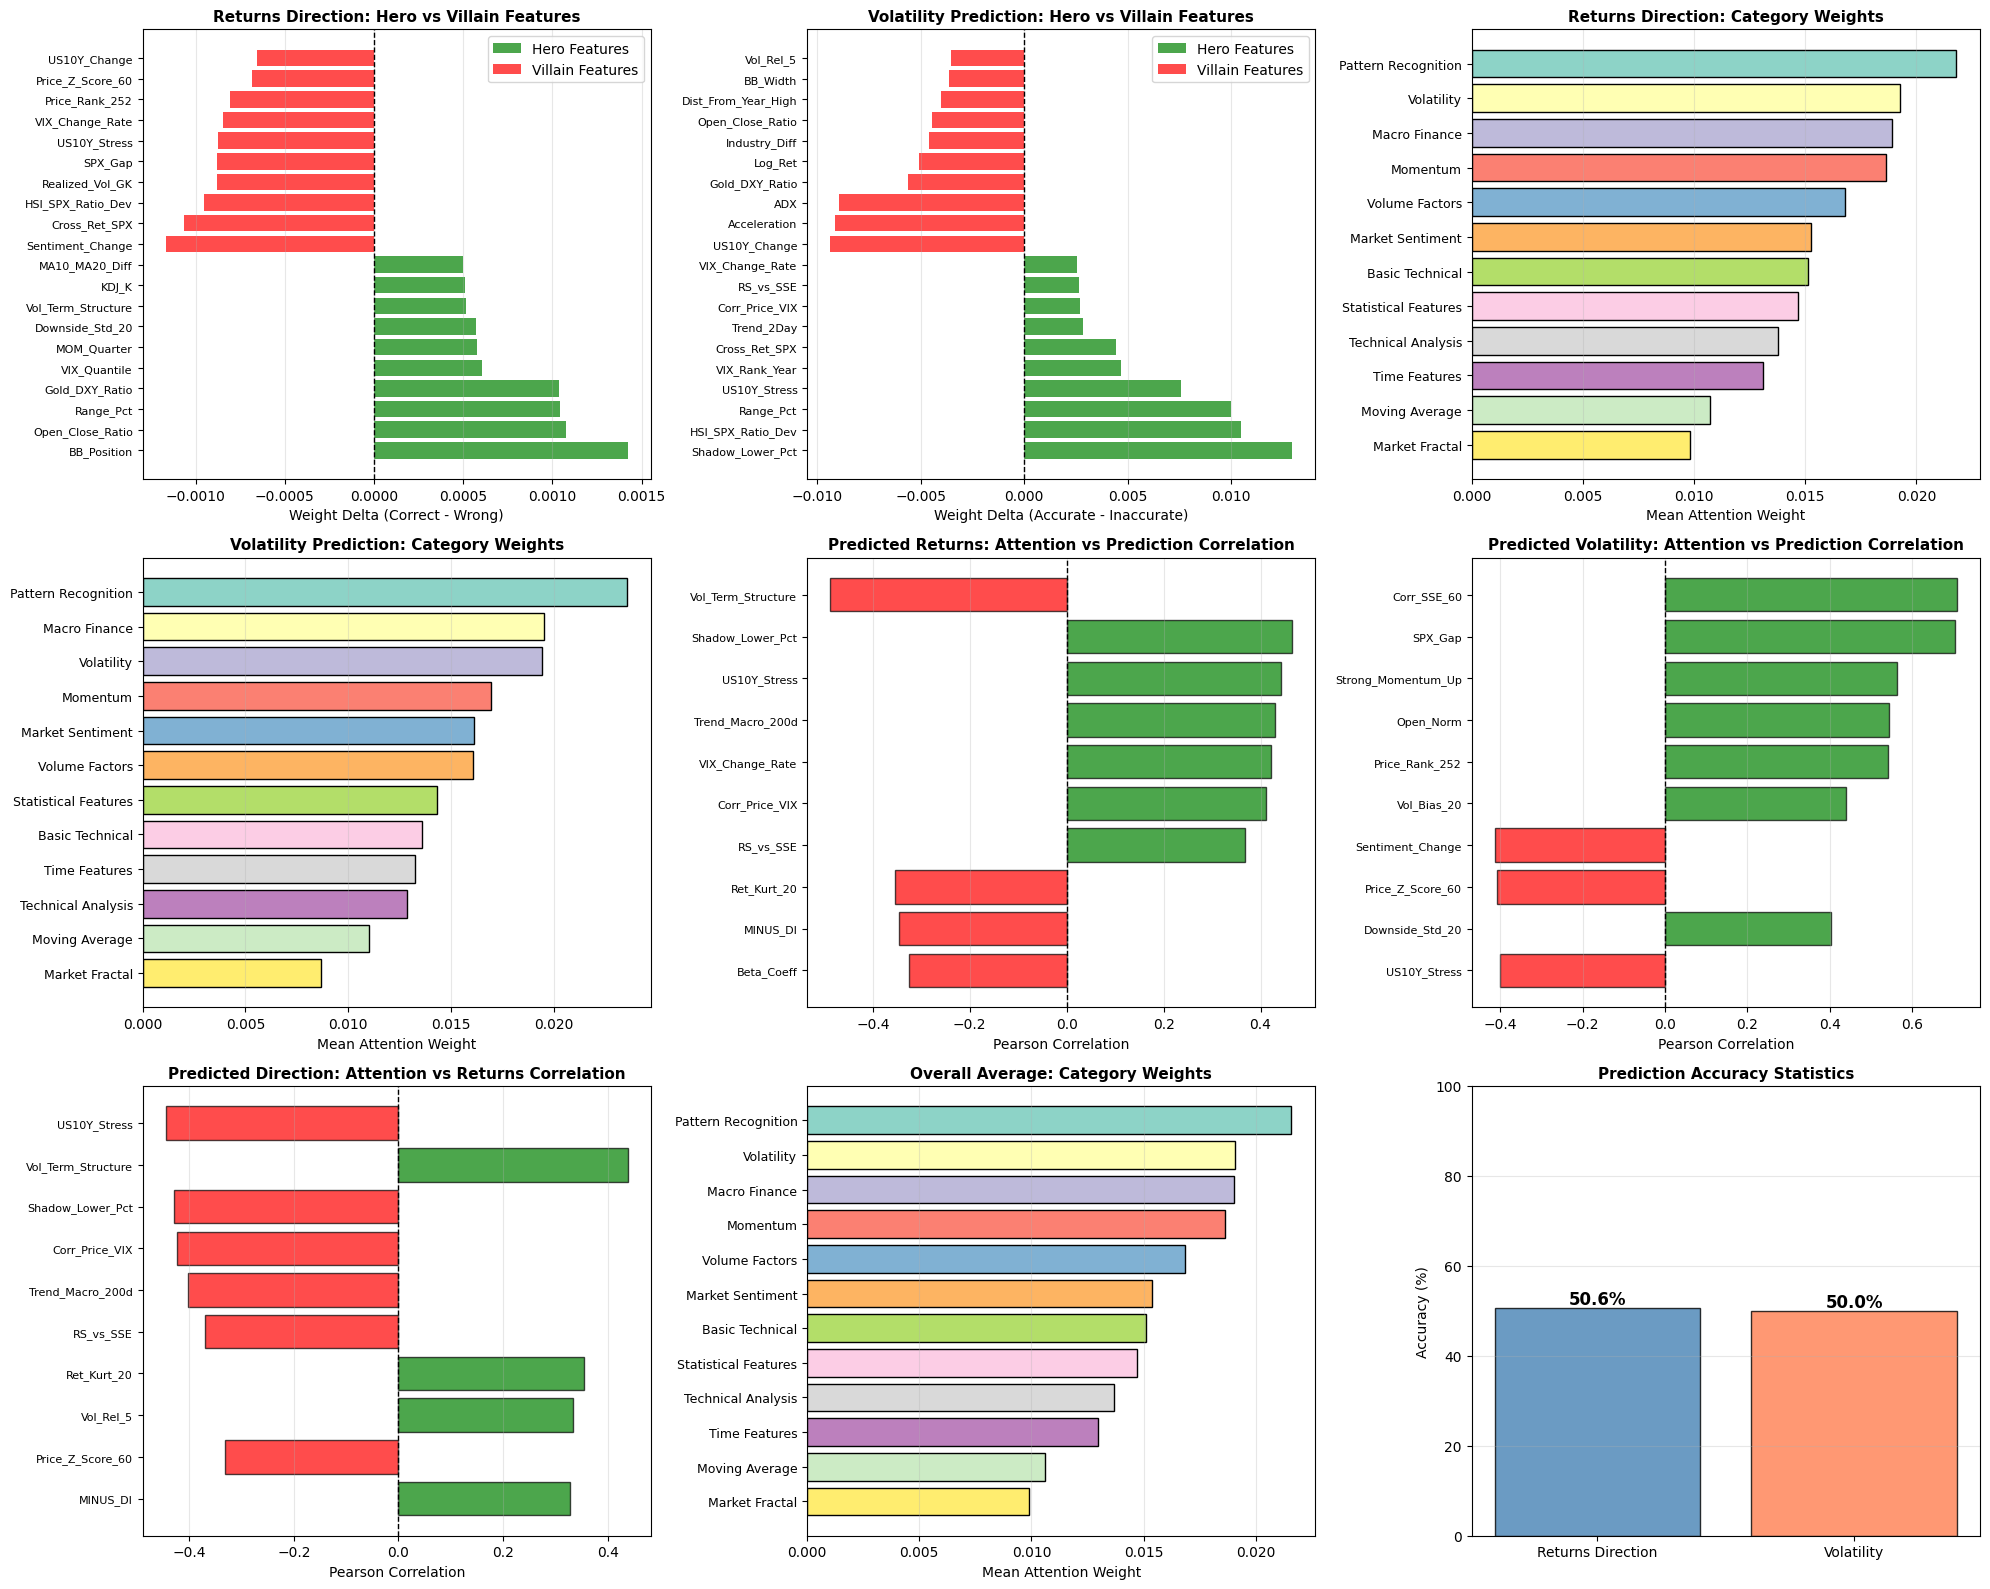

In [23]:
# ============================================================
# STEP 4: ANALYZE PATTERN ATTENTION (深度诊断版)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Get pattern names
pattern_names = patterns_df.columns.tolist()

# Average pattern attention across all test samples
avg_pattern_attention = np.mean(test_pattern_attn, axis=0)

# ============================================================
# 扩展Pattern分类（根据STEP 1的完整定义）
# ============================================================
extended_categories = {
    'Basic Technical': ['Returns', 'Log_Ret', 'Volatility_Ratio', 'Gap_Up', 'Gap_Down'],
    
    'Volume Factors': ['Vol_Rel_20', 'Vol_Rel_5', 'Vol_Surge', 'Vol_Dry_Up', 
                  'Vol_Price_Up_Confirm', 'Vol_Price_Down_Panic', 'Vol_Pullback_Low',
                  'Vol_Bias_20', 'Vol_Trend_Consistency', 'Vol_Rel', 'High_Volume'],
    
    'Technical Analysis': ['RSI_Overbought', 'RSI_Oversold', 'RSI_Near_50', 'RSI_Divergence', 'RSI_Trend', 'RSI_Score',
                    'MACD_Bullish_Cross', 'MACD_Bearish_Cross', 'MACD_Hist_Slope',
                    'BB_Position', 'BB_Width', 'BB_Touch_Upper', 'BB_Touch_Lower', 
                    'BB_Width_Compressed', 'BB_Pos_Norm', 'BB_Z_Score',
                    'KDJ_K', 'KDJ_D', 'KDJ_J',
                    'ADX', 'PLUS_DI', 'MINUS_DI', 'ADOSC'],
    
    'Pattern Recognition': ['Gap_Up_Reversal', 'Gap_Down_Reversal', 'Trend_2Day', 'Trend_Consistency',
                '2Day_Uptrend', '2Day_Downtrend', '3Day_Uptrend',
                'Breakout_High', 'Breakdown_Low', 'Breakout_Confirm', 'Drawdown_Bounce',
                'Inside_Day', 'Outside_Day', 'Shadow_Upper_Pct', 'Shadow_Lower_Pct',
                'Range_Pct', 'Open_Close_Ratio', 'Open_Norm'],
    
    'Volatility': ['High_Volatility', 'Low_Volatility', 'Volatility_ATR_Ratio'],
    
    'Momentum': ['Strong_Momentum_Up', 'Strong_Momentum_Down', 'Acceleration', 
            'Trend_Efficiency', 'Trend_Alignment', 'Trend_Score_3D', 'Trend_Day_C'],
    
    'Market Sentiment': ['Sentiment_Fear_Rank', 'Sentiment_Change', 'Market_Up_Down_Ratio',
                'VIX_Quantile', 'VIX_Change_Rate', 'VIX_Rank_Year', 'Corr_Price_VIX',
                'VVIX_Proxy'],
    
    'Macro Finance': ['CNH_Change_5D', 'CNH_Trend_Dev', 'US10Y_Change', 'US10Y_Stress',
                'DXY_Trend', 'HKD_Flow_Position', 'Macro_Triple_Bear',
                'Cross_Ret_SPX', 'Cross_Ret_SSE', 'SSE_Gap', 'SPX_Gap',
                'RS_vs_SPX', 'RS_vs_SSE', 'Corr_SPX_60', 'Corr_SSE_60',
                'HSI_SPX_Ratio_Dev', 'Gold_DXY_Ratio', 'Industry_Diff'],
    
    'Smart Money': ['CMF', 'OBV', 'MFI', 'Vol_Price_Trend_Sync'],
    
    'Statistical Features': ['Ret_Skew_20', 'Ret_Kurt_20', 'Ret_CV_20', 'Ret_ZScore_20',
                'Price_Z_Score_60', 'Return_Volatility', 'Volatility_Cluster'],
    
    'Market Fractal': ['Choppiness_Index', 'Trend_Efficiency', 'Trend_Alignment'],
    
    'Time Features': ['Month_Sin', 'Month_Cos', 'Quarter_1', 'Quarter_2', 'Quarter_3', 'Quarter_4',
                'Trend_Macro_200d', 'MOM_Quarter'],
    
    'Moving Average': ['MA5_MA10_Diff', 'MA10_MA20_Diff', 'Dist_from_High', 'Dist_from_Low']
}

# ============================================================
# 准备数据：反归一化预测值和真实值
# ============================================================
test_pred_returns = test_pred[:, 0:1]
test_pred_volatility = test_pred[:, 1:2]
y_test_returns = y_test_np[:, 0:1]
y_test_volatility = y_test_np[:, 1:2]

# 反归一化
test_pred_returns_denorm = scaler_target_returns.inverse_transform(test_pred_returns)
y_test_returns_denorm = scaler_target_returns.inverse_transform(y_test_returns)

if VOLATILITY_SCALING_METHOD == 'log_standard':
    test_pred_volatility_denorm = np.expm1(scaler_target_volatility.inverse_transform(test_pred_volatility))
    y_test_volatility_denorm = np.expm1(scaler_target_volatility.inverse_transform(y_test_volatility))
else:
    test_pred_volatility_denorm = scaler_target_volatility.inverse_transform(test_pred_volatility)
    y_test_volatility_denorm = scaler_target_volatility.inverse_transform(y_test_volatility)

test_pred_returns_denorm = test_pred_returns_denorm.flatten()
y_test_returns_denorm = y_test_returns_denorm.flatten()
test_pred_volatility_denorm = test_pred_volatility_denorm.flatten()
y_test_volatility_denorm = y_test_volatility_denorm.flatten()

# ============================================================
# 思路一：对/错对比诊断 (Hits vs. Misses Analysis)
# ============================================================
print("\n" + "=" * 80)
print("思路一：对/错对比诊断 (Hits vs. Misses Analysis)")
print("=" * 80)

# 1. 收益率方向预测正确/错误
pred_direction_returns = (test_pred_returns_denorm > 0).astype(int)
actual_direction_returns = (y_test_returns_denorm > 0).astype(int)
correct_returns = (pred_direction_returns == actual_direction_returns)

# 2. 波动率预测误差（使用相对误差）
volatility_error = np.abs(test_pred_volatility_denorm - y_test_volatility_denorm) / (y_test_volatility_denorm + 1e-6)
volatility_median_error = np.median(volatility_error)
correct_volatility = volatility_error < volatility_median_error  # 误差小于中位数的视为"正确"

# 计算正确/错误样本的平均pattern attention
correct_returns_attn = np.mean(test_pattern_attn[correct_returns], axis=0) if np.sum(correct_returns) > 0 else np.zeros(len(pattern_names))
wrong_returns_attn = np.mean(test_pattern_attn[~correct_returns], axis=0) if np.sum(~correct_returns) > 0 else np.zeros(len(pattern_names))

correct_volatility_attn = np.mean(test_pattern_attn[correct_volatility], axis=0) if np.sum(correct_volatility) > 0 else np.zeros(len(pattern_names))
wrong_volatility_attn = np.mean(test_pattern_attn[~correct_volatility], axis=0) if np.sum(~correct_volatility) > 0 else np.zeros(len(pattern_names))

# 计算差异（正确时权重 - 错误时权重）
diff_returns = correct_returns_attn - wrong_returns_attn
diff_volatility = correct_volatility_attn - wrong_volatility_attn

print(f"\n【收益率方向预测】")
print(f"  正确样本数: {np.sum(correct_returns)} ({np.sum(correct_returns)/len(correct_returns)*100:.1f}%)")
print(f"  错误样本数: {np.sum(~correct_returns)} ({np.sum(~correct_returns)/len(correct_returns)*100:.1f}%)")

print(f"\n【波动率预测】")
print(f"  准确样本数（误差<中位数）: {np.sum(correct_volatility)} ({np.sum(correct_volatility)/len(correct_volatility)*100:.1f}%)")
print(f"  不准确样本数: {np.sum(~correct_volatility)} ({np.sum(~correct_volatility)/len(correct_volatility)*100:.1f}%)")

# 找出"功臣特征"（正确时权重显著更高）和"内鬼特征"（错误时权重更高）
print(f"\n【收益率方向预测 - Top 10 功臣特征】（正确时权重显著更高）")
returns_heroes = list(zip(pattern_names, diff_returns))
returns_heroes.sort(key=lambda x: x[1], reverse=True)
for i, (pattern, diff) in enumerate(returns_heroes[:10], 1):
    print(f"  {i:2d}. {pattern:<30} 差异: {diff:+.4f}")

print(f"\n【收益率方向预测 - Top 10 内鬼特征】（错误时权重更高）")
returns_villains = list(zip(pattern_names, diff_returns))
returns_villains.sort(key=lambda x: x[1])
for i, (pattern, diff) in enumerate(returns_villains[:10], 1):
    print(f"  {i:2d}. {pattern:<30} 差异: {diff:+.4f}")

print(f"\n【波动率预测 - Top 10 功臣特征】（准确时权重显著更高）")
volatility_heroes = list(zip(pattern_names, diff_volatility))
volatility_heroes.sort(key=lambda x: x[1], reverse=True)
for i, (pattern, diff) in enumerate(volatility_heroes[:10], 1):
    print(f"  {i:2d}. {pattern:<30} 差异: {diff:+.4f}")

print(f"\n【波动率预测 - Top 10 内鬼特征】（不准确时权重更高）")
volatility_villains = list(zip(pattern_names, diff_volatility))
volatility_villains.sort(key=lambda x: x[1])
for i, (pattern, diff) in enumerate(volatility_villains[:10], 1):
    print(f"  {i:2d}. {pattern:<30} 差异: {diff:+.4f}")

# ============================================================
# 思路二：分类权重聚合 (Category Aggregation)
# ============================================================
print("\n" + "=" * 80)
print("思路二：分类权重聚合 (Category Aggregation)")
print("=" * 80)

category_weights_returns = {}
category_weights_volatility = {}
category_weights_overall = {}

for cat, patterns in extended_categories.items():
    # 只计算实际存在的pattern
    existing_patterns = [p for p in patterns if p in pattern_names]
    if len(existing_patterns) > 0:
        pattern_indices = [pattern_names.index(p) for p in existing_patterns]
        # 收益率方向正确时的权重
        cat_weight_returns = np.mean(correct_returns_attn[pattern_indices]) if np.sum(correct_returns) > 0 else 0
        # 波动率准确时的权重
        cat_weight_volatility = np.mean(correct_volatility_attn[pattern_indices]) if np.sum(correct_volatility) > 0 else 0
        # 整体平均权重
        cat_weight_overall = np.mean(avg_pattern_attention[pattern_indices])
        
        category_weights_returns[cat] = cat_weight_returns
        category_weights_volatility[cat] = cat_weight_volatility
        category_weights_overall[cat] = cat_weight_overall

print(f"\n【收益率方向预测 - 各类别权重】（正确预测时的平均权重）")
sorted_cats_returns = sorted(category_weights_returns.items(), key=lambda x: x[1], reverse=True)
for cat, weight in sorted_cats_returns:
    print(f"  {cat:<20} {weight:.4f}")

print(f"\n【波动率预测 - 各类别权重】（准确预测时的平均权重）")
sorted_cats_volatility = sorted(category_weights_volatility.items(), key=lambda x: x[1], reverse=True)
for cat, weight in sorted_cats_volatility:
    print(f"  {cat:<20} {weight:.4f}")

print(f"\n【整体平均 - 各类别权重】")
sorted_cats_overall = sorted(category_weights_overall.items(), key=lambda x: x[1], reverse=True)
for cat, weight in sorted_cats_overall:
    print(f"  {cat:<20} {weight:.4f}")

# ============================================================
# 思路三：极端样本案例研究 (Extreme Case Study)
# ============================================================
print("\n" + "=" * 80)
print("思路三：极端样本案例研究 (Extreme Case Study)")
print("=" * 80)

# 1. 最大涨跌幅日
max_gain_idx = np.argmax(y_test_returns_denorm)
max_loss_idx = np.argmin(y_test_returns_denorm)

# 2. 预测错误最严重的样本（预测值很大但方向相反）
pred_abs = np.abs(test_pred_returns_denorm)
direction_wrong = ~correct_returns
worst_mistake_idx = np.argmax(pred_abs * direction_wrong.astype(float)) if np.sum(direction_wrong) > 0 else 0

# 3. 波动率预测误差最大的样本
worst_volatility_idx = np.argmax(volatility_error)

print(f"\n【最大涨幅日】")
if max_gain_idx < len(test_dates):
    date = test_dates[max_gain_idx]
    actual = y_test_returns_denorm[max_gain_idx]
    predicted = test_pred_returns_denorm[max_gain_idx]
    print(f"  日期: {date.date()}")
    print(f"  实际收益率: {actual:+.4f}% | 预测收益率: {predicted:+.4f}%")
    print(f"  Top 5 Patterns:")
    top_patterns = list(zip(pattern_names, test_pattern_attn[max_gain_idx]))
    top_patterns.sort(key=lambda x: x[1], reverse=True)
    for i, (pattern, weight) in enumerate(top_patterns[:5], 1):
        print(f"    {i}. {pattern:<30} {weight*100:5.2f}%")

print(f"\n【最大跌幅日】")
if max_loss_idx < len(test_dates):
    date = test_dates[max_loss_idx]
    actual = y_test_returns_denorm[max_loss_idx]
    predicted = test_pred_returns_denorm[max_loss_idx]
    print(f"  日期: {date.date()}")
    print(f"  实际收益率: {actual:+.4f}% | 预测收益率: {predicted:+.4f}%")
    print(f"  Top 5 Patterns:")
    top_patterns = list(zip(pattern_names, test_pattern_attn[max_loss_idx]))
    top_patterns.sort(key=lambda x: x[1], reverse=True)
    for i, (pattern, weight) in enumerate(top_patterns[:5], 1):
        print(f"    {i}. {pattern:<30} {weight*100:5.2f}%")

print(f"\n【滑铁卢日】（预测错误最严重）")
if worst_mistake_idx < len(test_dates):
    date = test_dates[worst_mistake_idx]
    actual = y_test_returns_denorm[worst_mistake_idx]
    predicted = test_pred_returns_denorm[worst_mistake_idx]
    print(f"  日期: {date.date()}")
    print(f"  实际收益率: {actual:+.4f}% | 预测收益率: {predicted:+.4f}%")
    print(f"  预测方向: {'涨' if predicted > 0 else '跌'} | 实际方向: {'涨' if actual > 0 else '跌'}")
    print(f"  Top 5 Patterns（被哪些特征带偏）:")
    top_patterns = list(zip(pattern_names, test_pattern_attn[worst_mistake_idx]))
    top_patterns.sort(key=lambda x: x[1], reverse=True)
    for i, (pattern, weight) in enumerate(top_patterns[:5], 1):
        print(f"    {i}. {pattern:<30} {weight*100:5.2f}%")

print(f"\n【波动率预测误差最大日】")
if worst_volatility_idx < len(test_dates):
    date = test_dates[worst_volatility_idx]
    actual_vol = y_test_volatility_denorm[worst_volatility_idx]
    predicted_vol = test_pred_volatility_denorm[worst_volatility_idx]
    error = volatility_error[worst_volatility_idx]
    print(f"  日期: {date.date()}")
    print(f"  实际波动率: {actual_vol:.4f}% | 预测波动率: {predicted_vol:.4f}%")
    print(f"  相对误差: {error*100:.2f}%")
    print(f"  Top 5 Patterns:")
    top_patterns = list(zip(pattern_names, test_pattern_attn[worst_volatility_idx]))
    top_patterns.sort(key=lambda x: x[1], reverse=True)
    for i, (pattern, weight) in enumerate(top_patterns[:5], 1):
        print(f"    {i}. {pattern:<30} {weight*100:5.2f}%")

# ============================================================
# 思路四：注意力与预测值的相关性 (Attention-Prediction Correlation)
# ============================================================
print("\n" + "=" * 80)
print("思路四：注意力与预测值的相关性 (Attention-Prediction Correlation)")
print("=" * 80)

# 计算每个pattern的attention与预测值绝对值的相关性
correlations_returns = []
correlations_volatility = []
correlations_direction = []

for i, pattern in enumerate(pattern_names):
    # 与收益率预测绝对值的相关性
    corr_ret, p_val_ret = pearsonr(test_pattern_attn[:, i], np.abs(test_pred_returns_denorm))
    correlations_returns.append((pattern, corr_ret, p_val_ret))
    
    # 与波动率预测值的相关性
    corr_vol, p_val_vol = pearsonr(test_pattern_attn[:, i], test_pred_volatility_denorm)
    correlations_volatility.append((pattern, corr_vol, p_val_vol))
    
    # 与方向预测值的相关性（预测收益率本身）
    corr_dir, p_val_dir = pearsonr(test_pattern_attn[:, i], test_pred_returns_denorm)
    correlations_direction.append((pattern, corr_dir, p_val_dir))

print(f"\n【预测收益率时 - Top 10 相关性最高的Pattern】（注意力与预测值绝对值相关）")
correlations_returns.sort(key=lambda x: abs(x[1]), reverse=True)
for i, (pattern, corr, p_val) in enumerate(correlations_returns[:10], 1):
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    print(f"  {i:2d}. {pattern:<30} 相关系数: {corr:+.4f} {sig}")

print(f"\n【预测波动率时 - Top 10 相关性最高的Pattern】（注意力与预测值相关）")
correlations_volatility.sort(key=lambda x: abs(x[1]), reverse=True)
for i, (pattern, corr, p_val) in enumerate(correlations_volatility[:10], 1):
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    print(f"  {i:2d}. {pattern:<30} 相关系数: {corr:+.4f} {sig}")

print(f"\n【预测方向时 - Top 10 相关性最高的Pattern】（注意力与预测收益率相关）")
correlations_direction.sort(key=lambda x: abs(x[1]), reverse=True)
for i, (pattern, corr, p_val) in enumerate(correlations_direction[:10], 1):
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    print(f"  {i:2d}. {pattern:<30} 相关系数: {corr:+.4f} {sig}")

# ============================================================
# 可视化图表
# ============================================================
fig = plt.figure(figsize=(20, 16))

# 1. 对/错对比 - 收益率方向
ax1 = plt.subplot(3, 3, 1)
top_10_heroes = returns_heroes[:10]
top_10_villains = returns_villains[:10]
patterns_heroes = [p[0] for p in top_10_heroes]
diffs_heroes = [p[1] for p in top_10_heroes]
patterns_villains = [p[0] for p in top_10_villains]
diffs_villains = [p[1] for p in top_10_villains]

x_pos = np.arange(len(patterns_heroes))
ax1.barh(x_pos, diffs_heroes, color='green', alpha=0.7, label='Hero Features')
ax1.barh(x_pos + len(patterns_heroes), diffs_villains, color='red', alpha=0.7, label='Villain Features')
ax1.set_yticks(list(x_pos) + list(x_pos + len(patterns_heroes)))
ax1.set_yticklabels(patterns_heroes + patterns_villains, fontsize=8)
ax1.set_xlabel('Weight Delta (Correct - Wrong)', fontsize=10)
ax1.set_title('Returns Direction: Hero vs Villain Features', fontsize=11, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')
ax1.axvline(0, color='black', linestyle='--', linewidth=1)

# 2. 对/错对比 - 波动率
ax2 = plt.subplot(3, 3, 2)
top_10_vol_heroes = volatility_heroes[:10]
top_10_vol_villains = volatility_villains[:10]
patterns_vol_heroes = [p[0] for p in top_10_vol_heroes]
diffs_vol_heroes = [p[1] for p in top_10_vol_heroes]
patterns_vol_villains = [p[0] for p in top_10_vol_villains]
diffs_vol_villains = [p[1] for p in top_10_vol_villains]

x_pos_vol = np.arange(len(patterns_vol_heroes))
ax2.barh(x_pos_vol, diffs_vol_heroes, color='green', alpha=0.7, label='Hero Features')
ax2.barh(x_pos_vol + len(patterns_vol_heroes), diffs_vol_villains, color='red', alpha=0.7, label='Villain Features')
ax2.set_yticks(list(x_pos_vol) + list(x_pos_vol + len(patterns_vol_heroes)))
ax2.set_yticklabels(patterns_vol_heroes + patterns_vol_villains, fontsize=8)
ax2.set_xlabel('Weight Delta (Accurate - Inaccurate)', fontsize=10)
ax2.set_title('Volatility Prediction: Hero vs Villain Features', fontsize=11, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')
ax2.axvline(0, color='black', linestyle='--', linewidth=1)

# 3. 分类权重聚合 - 收益率
ax3 = plt.subplot(3, 3, 3)
cats_ret = [c[0] for c in sorted_cats_returns]
weights_ret = [c[1] for c in sorted_cats_returns]
colors_cat = plt.cm.Set3(range(len(cats_ret)))
bars = ax3.barh(range(len(cats_ret)), weights_ret, color=colors_cat, edgecolor='black')
ax3.set_yticks(range(len(cats_ret)))
ax3.set_yticklabels(cats_ret, fontsize=9)
ax3.set_xlabel('Mean Attention Weight', fontsize=10)
ax3.set_title('Returns Direction: Category Weights', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
ax3.invert_yaxis()

# 4. 分类权重聚合 - 波动率
ax4 = plt.subplot(3, 3, 4)
cats_vol = [c[0] for c in sorted_cats_volatility]
weights_vol = [c[1] for c in sorted_cats_volatility]
colors_cat_vol = plt.cm.Set3(range(len(cats_vol)))
bars = ax4.barh(range(len(cats_vol)), weights_vol, color=colors_cat_vol, edgecolor='black')
ax4.set_yticks(range(len(cats_vol)))
ax4.set_yticklabels(cats_vol, fontsize=9)
ax4.set_xlabel('Mean Attention Weight', fontsize=10)
ax4.set_title('Volatility Prediction: Category Weights', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.invert_yaxis()

# 5. 相关性分析 - 收益率
ax5 = plt.subplot(3, 3, 5)
top_10_corr_ret = correlations_returns[:10]
patterns_corr_ret = [p[0] for p in top_10_corr_ret]
corrs_ret = [p[1] for p in top_10_corr_ret]
colors_corr = ['red' if c < 0 else 'green' for c in corrs_ret]
ax5.barh(range(len(patterns_corr_ret)), corrs_ret, color=colors_corr, alpha=0.7, edgecolor='black')
ax5.set_yticks(range(len(patterns_corr_ret)))
ax5.set_yticklabels(patterns_corr_ret, fontsize=8)
ax5.set_xlabel('Pearson Correlation', fontsize=10)
ax5.set_title('Predicted Returns: Attention vs Prediction Correlation', fontsize=11, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')
ax5.axvline(0, color='black', linestyle='--', linewidth=1)
ax5.invert_yaxis()

# 6. 相关性分析 - 波动率
ax6 = plt.subplot(3, 3, 6)
top_10_corr_vol = correlations_volatility[:10]
patterns_corr_vol = [p[0] for p in top_10_corr_vol]
corrs_vol = [p[1] for p in top_10_corr_vol]
colors_corr_vol = ['red' if c < 0 else 'green' for c in corrs_vol]
ax6.barh(range(len(patterns_corr_vol)), corrs_vol, color=colors_corr_vol, alpha=0.7, edgecolor='black')
ax6.set_yticks(range(len(patterns_corr_vol)))
ax6.set_yticklabels(patterns_corr_vol, fontsize=8)
ax6.set_xlabel('Pearson Correlation', fontsize=10)
ax6.set_title('Predicted Volatility: Attention vs Prediction Correlation', fontsize=11, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='x')
ax6.axvline(0, color='black', linestyle='--', linewidth=1)
ax6.invert_yaxis()

# 7. 相关性分析 - 方向
ax7 = plt.subplot(3, 3, 7)
top_10_corr_dir = correlations_direction[:10]
patterns_corr_dir = [p[0] for p in top_10_corr_dir]
corrs_dir = [p[1] for p in top_10_corr_dir]
colors_corr_dir = ['red' if c < 0 else 'green' for c in corrs_dir]
ax7.barh(range(len(patterns_corr_dir)), corrs_dir, color=colors_corr_dir, alpha=0.7, edgecolor='black')
ax7.set_yticks(range(len(patterns_corr_dir)))
ax7.set_yticklabels(patterns_corr_dir, fontsize=8)
ax7.set_xlabel('Pearson Correlation', fontsize=10)
ax7.set_title('Predicted Direction: Attention vs Returns Correlation', fontsize=11, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='x')
ax7.axvline(0, color='black', linestyle='--', linewidth=1)
ax7.invert_yaxis()

# 8. 整体分类权重对比
ax8 = plt.subplot(3, 3, 8)
cats_all = [c[0] for c in sorted_cats_overall]
weights_all = [c[1] for c in sorted_cats_overall]
colors_all = plt.cm.Set3(range(len(cats_all)))
bars = ax8.barh(range(len(cats_all)), weights_all, color=colors_all, edgecolor='black')
ax8.set_yticks(range(len(cats_all)))
ax8.set_yticklabels(cats_all, fontsize=9)
ax8.set_xlabel('Mean Attention Weight', fontsize=10)
ax8.set_title('Overall Average: Category Weights', fontsize=11, fontweight='bold')
ax8.grid(True, alpha=0.3, axis='x')
ax8.invert_yaxis()

# 9. 方向准确率统计
ax9 = plt.subplot(3, 3, 9)
accuracy_returns = np.sum(correct_returns) / len(correct_returns) * 100
accuracy_volatility = np.sum(correct_volatility) / len(correct_volatility) * 100
categories_acc = ['Returns Direction', 'Volatility']
accuracies = [accuracy_returns, accuracy_volatility]
colors_acc = ['steelblue', 'coral']
bars = ax9.bar(categories_acc, accuracies, color=colors_acc, edgecolor='black', alpha=0.8)
ax9.set_ylabel('Accuracy (%)', fontsize=10)
ax9.set_title('Prediction Accuracy Statistics', fontsize=11, fontweight='bold')
ax9.set_ylim([0, 100])
ax9.grid(True, alpha=0.3, axis='y')
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


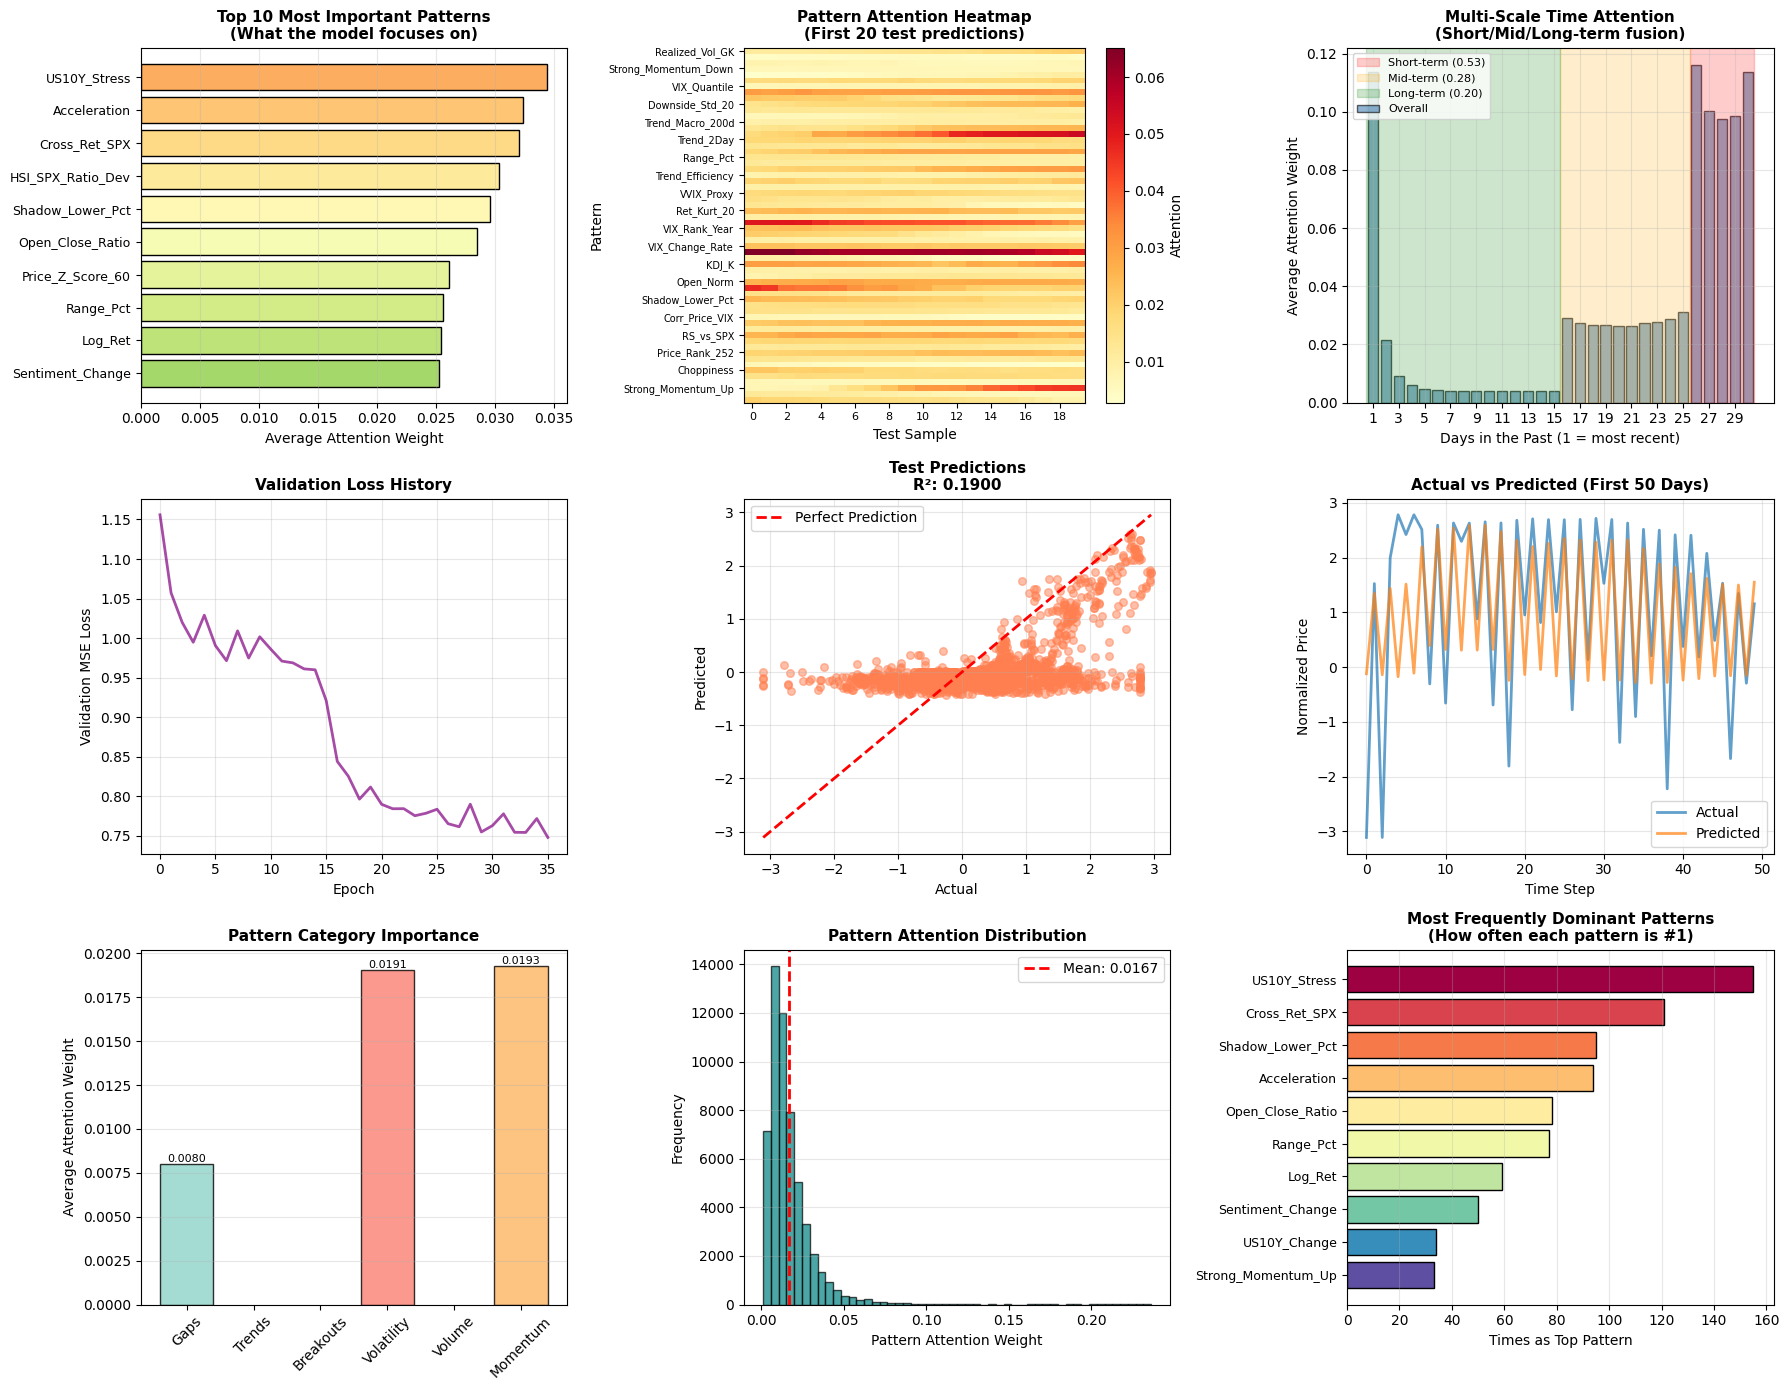


PATTERN CATEGORY ANALYSIS
Gaps            0.0080
Trends          nan
Breakouts       nan
Volatility      0.0191
Volume          nan
Momentum        0.0193


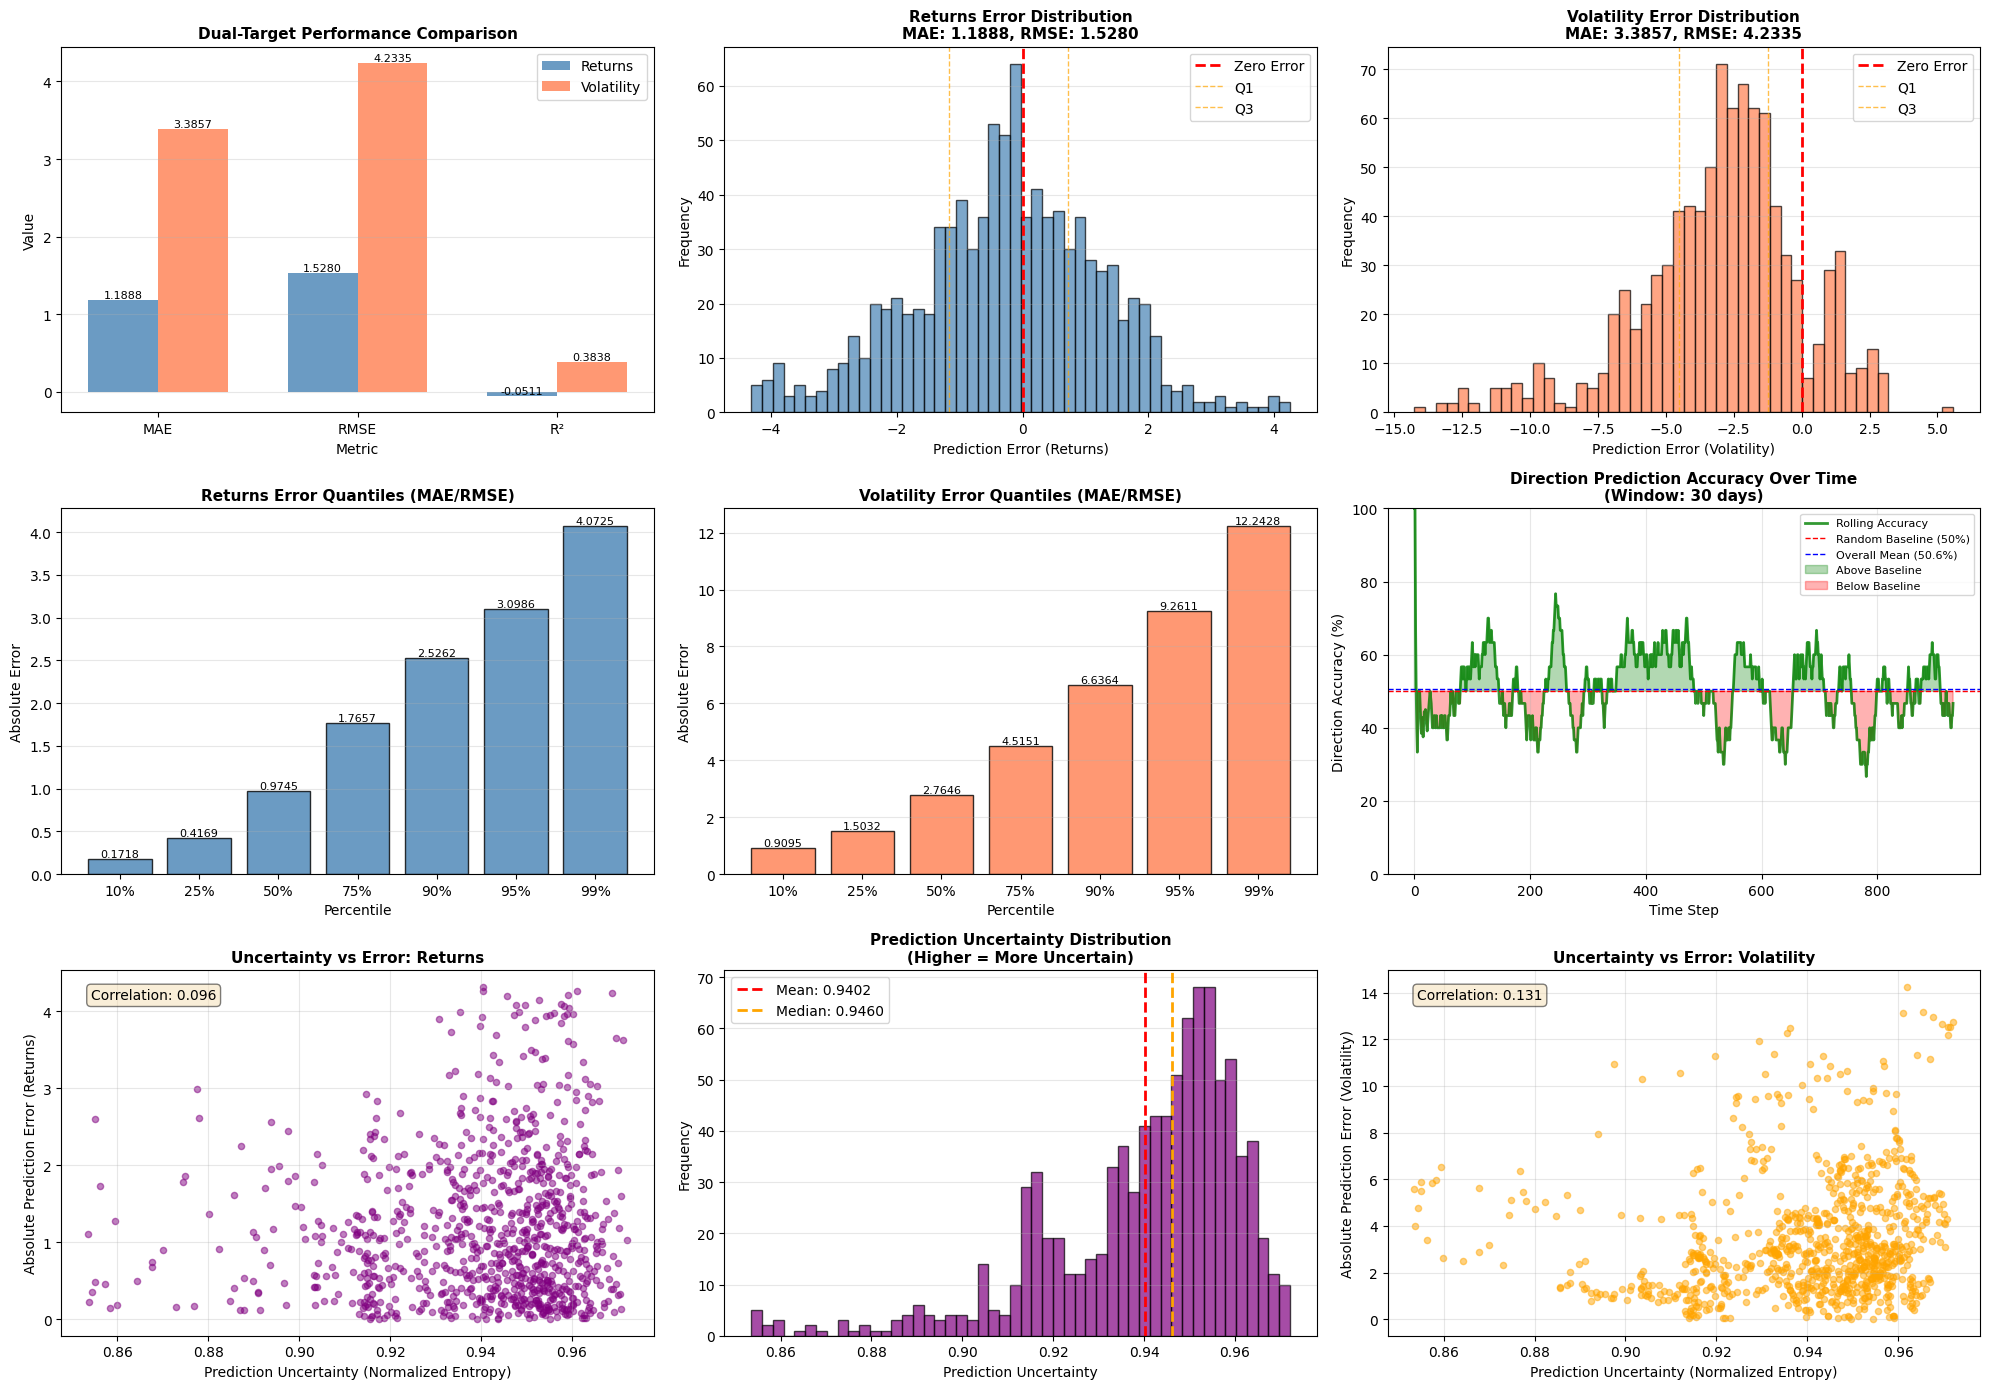


DUAL-TARGET PERFORMANCE SUMMARY

Returns Prediction:
  MAE:  1.188774
  RMSE: 1.528004
  R²:   -0.051083
  Direction Accuracy: 50.64%

Volatility Prediction:
  MAE:  3.385689
  RMSE: 4.233507
  R²:   0.383807

Error Quantiles (Returns):
  10th percentile: 0.171840
  25th percentile: 0.416950
  50th percentile: 0.974533
  75th percentile: 1.765738
  90th percentile: 2.526162
  95th percentile: 3.098609
  99th percentile: 4.072451

Error Quantiles (Volatility):
  10th percentile: 0.909492
  25th percentile: 1.503151
  50th percentile: 2.764577
  75th percentile: 4.515075
  90th percentile: 6.636408
  95th percentile: 9.261052
  99th percentile: 12.242768

Prediction Uncertainty:
  Mean:   0.9402
  Median: 0.9460
  Std:    0.0214
  Correlation with Returns Error: 0.0962
  Correlation with Volatility Error: 0.1308

MULTI-SCALE TIME ATTENTION ANALYSIS


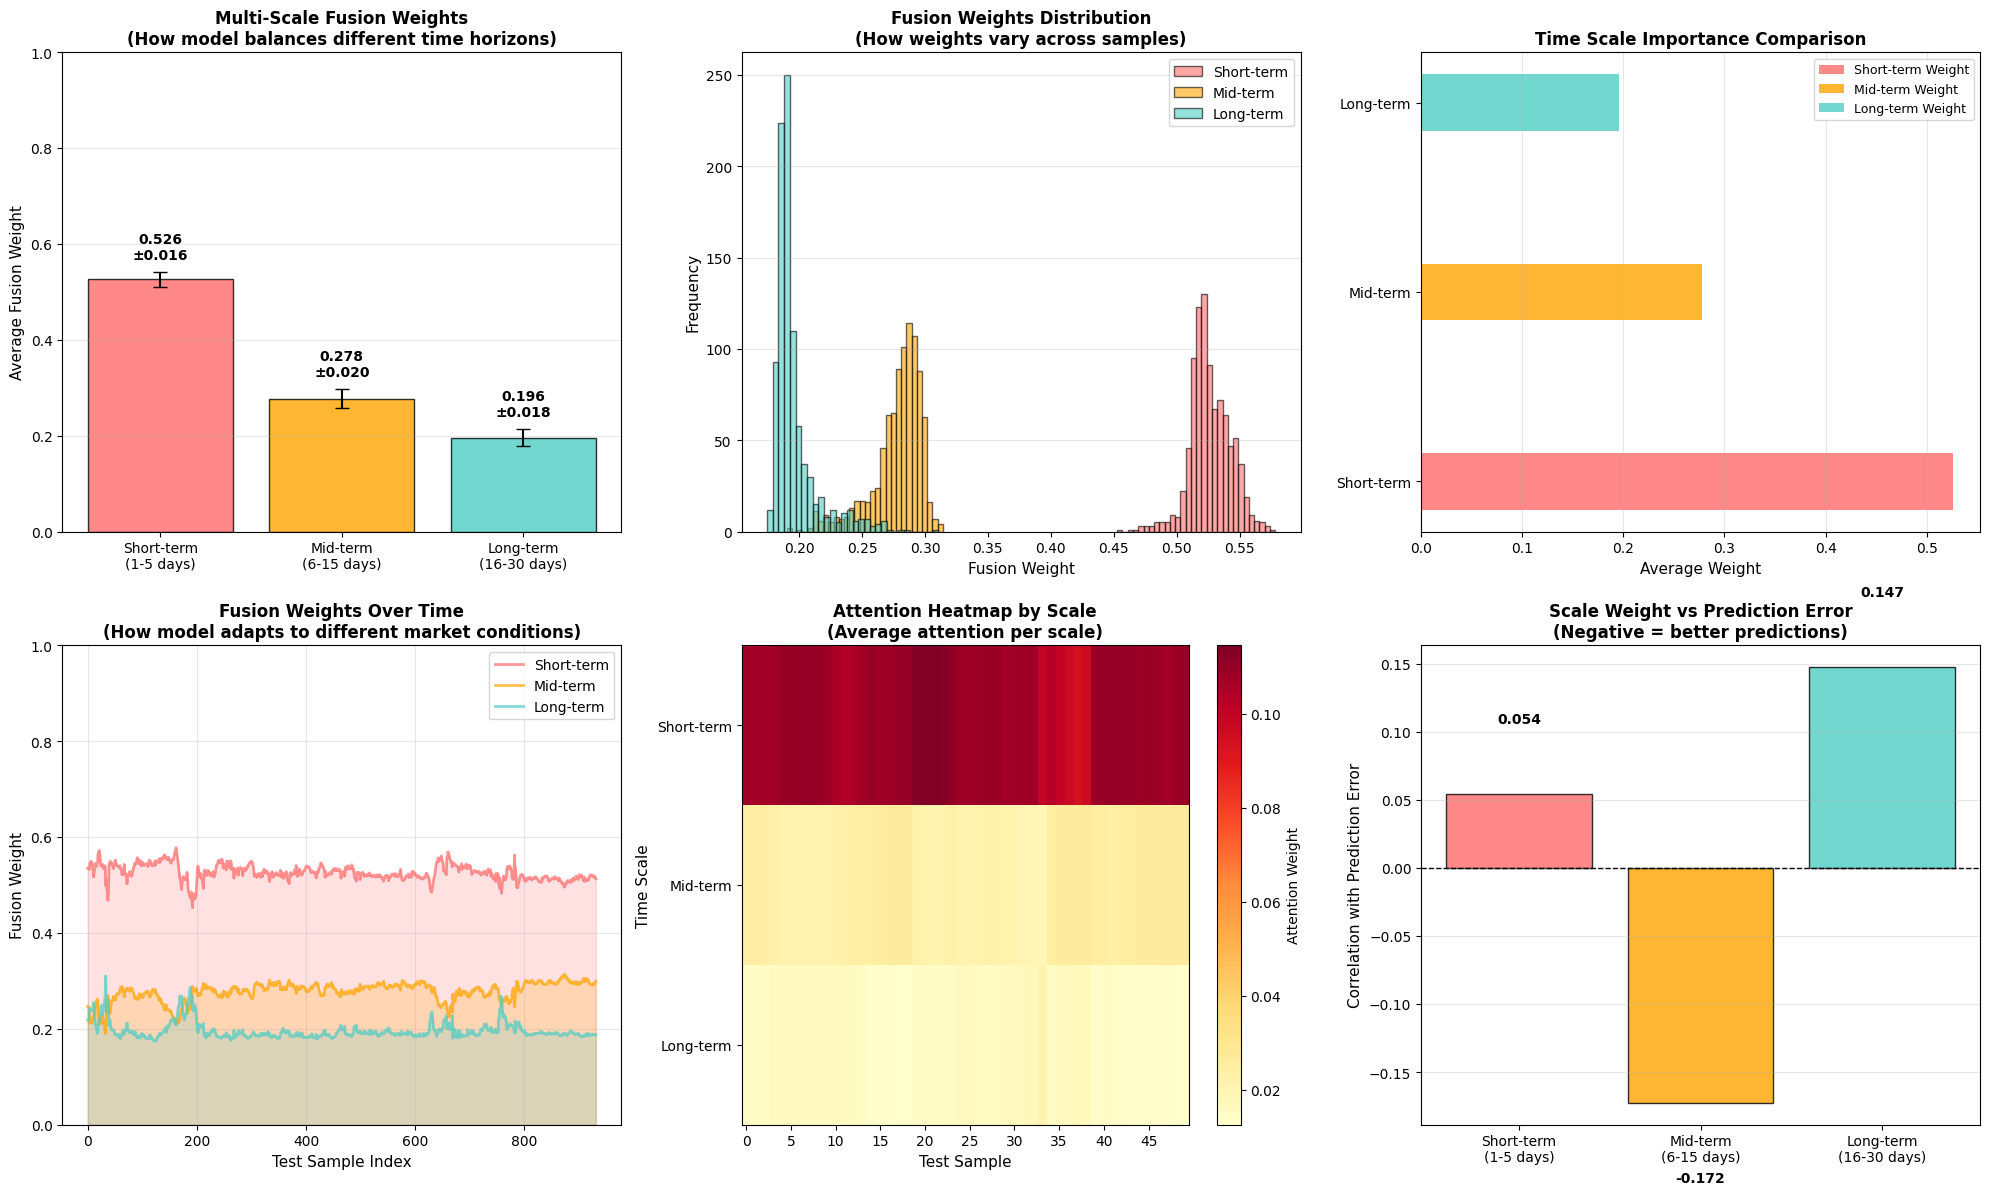


Multi-Scale Time Attention Statistics:
  Total Samples: 932

  Short-term (1-5 days):
    Mean Weight: 0.5263 ± 0.0162
    Min: 0.4527, Max: 0.5783

  Mid-term (6-15 days):
    Mean Weight: 0.2776 ± 0.0201
    Min: 0.1901, Max: 0.3141

  Long-term (16-30 days):
    Mean Weight: 0.1961 ± 0.0176
    Min: 0.1745, Max: 0.3105

  Interpretation:
    Dominant Scale: Short-term (52.63%)
    → Model heavily relies on short-term signals

  Correlation with Prediction Error:
    Short-term: +0.0540 
    Mid-term:   -0.1724 (negative is better)
    Long-term:  +0.1473 


In [24]:
# ============================================================
# STEP 5: CREATE COMPREHENSIVE VISUALIZATIONS
# ============================================================

from sklearn.metrics import r2_score

y_test_patterns = y_test.flatten()
test_pred_flat = test_pred.flatten()
avg_pattern_attention = np.mean(test_pattern_attn, axis=0)
pattern_importance = list(zip(pattern_names, avg_pattern_attention))
pattern_importance.sort(key=lambda x: x[1], reverse=True)
losses = [{'val_loss_mse': loss} for loss in train_losses]

# Calculate R² score for predictions
test_r2 = r2_score(y_test_patterns, test_pred_flat)

fig = plt.figure(figsize=(18, 14))

# 1. Pattern Importance Bar Chart
ax1 = plt.subplot(3, 3, 1)
top_10_patterns = pattern_importance[:10]
patterns_top10 = [p[0] for p in top_10_patterns]
weights_top10 = [p[1] for p in top_10_patterns]

colors = plt.cm.RdYlGn(np.linspace(0.3, 0.7, 10))
bars = ax1.barh(range(len(patterns_top10)), weights_top10, color=colors, edgecolor='black')
ax1.set_yticks(range(len(patterns_top10)))
ax1.set_yticklabels(patterns_top10, fontsize=9)
ax1.set_xlabel('Average Attention Weight', fontsize=10)
ax1.set_title('Top 10 Most Important Patterns\n(What the model focuses on)',
              fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# 2. Pattern Attention Heatmap (sample predictions)
ax2 = plt.subplot(3, 3, 2)
sample_size = 20
sample_attn = test_pattern_attn[:sample_size]

im = ax2.imshow(sample_attn.T, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax2.set_xlabel('Test Sample', fontsize=10)
ax2.set_ylabel('Pattern', fontsize=10)
# Set x-axis ticks (every 2 samples to avoid crowding)
x_ticks = np.arange(0, sample_size, max(1, sample_size // 10))
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_ticks, fontsize=8)
# Set y-axis ticks (only show every Nth pattern to avoid crowding)
y_step = max(1, len(pattern_names) // 20)  # Show ~20 pattern labels
y_ticks = np.arange(0, len(pattern_names), y_step)
ax2.set_yticks(y_ticks)
ax2.set_yticklabels([pattern_names[i] for i in y_ticks], fontsize=7)
ax2.set_title('Pattern Attention Heatmap\n(First 20 test predictions)',
              fontsize=11, fontweight='bold')
plt.colorbar(im, ax=ax2, label='Attention')

# 3. Multi-Scale Time Attention Distribution
ax3 = plt.subplot(3, 3, 3)
avg_time_attention = np.mean(test_time_attn, axis=0)
days_back = np.arange(1, len(avg_time_attention) + 1) # 1-indexed for clarity in plotting

# 绘制完整时间注意力
ax3.bar(days_back, avg_time_attention, alpha=0.6, color='steelblue', edgecolor='black', label='Overall')

# 如果有多时间尺度信息，添加分组可视化
if 'test_fusion_weights' in globals() and test_fusion_weights is not None:
    avg_fusion = np.mean(test_fusion_weights, axis=0)  # [short, mid, long]
    # 标记不同时间尺度区域
    seq_len = len(avg_time_attention)
    short_end = min(5, seq_len // 4)
    mid_end = min(short_end + 10, seq_len // 2 + 5)
    
    if short_end > 0:
        ax3.axvspan(seq_len - short_end + 0.5, seq_len + 0.5, alpha=0.2, color='red', label=f'Short-term ({avg_fusion[0]:.2f})')
    if mid_end > short_end:
        ax3.axvspan(seq_len - mid_end + 0.5, seq_len - short_end + 0.5, alpha=0.2, color='orange', label=f'Mid-term ({avg_fusion[1]:.2f})')
    if seq_len - mid_end > 0:
        ax3.axvspan(0.5, seq_len - mid_end + 0.5, alpha=0.2, color='green', label=f'Long-term ({avg_fusion[2]:.2f})')

ax3.set_xlabel('Days in the Past (1 = most recent)', fontsize=10)
ax3.set_ylabel('Average Attention Weight', fontsize=10)
ax3.set_title('Multi-Scale Time Attention\n(Short/Mid/Long-term fusion)', fontsize=11, fontweight='bold')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)
ax3.set_xticks(days_back[::2]) # Show fewer x-ticks for readability

# 4. Training Loss
ax4 = plt.subplot(3, 3, 4)
val_losses = [l['val_loss_mse'] for l in losses] # Extract validation loss
ax4.plot(val_losses, linewidth=2, color='purple', alpha=0.7)
ax4.set_xlabel('Epoch', fontsize=10)
ax4.set_ylabel('Validation MSE Loss', fontsize=10) # Updated label
ax4.set_title('Validation Loss History', fontsize=11, fontweight='bold') # Updated title
ax4.grid(True, alpha=0.3)

# 5. Predictions vs Actual
ax5 = plt.subplot(3, 3, 5)
ax5.scatter(y_test_patterns, test_pred_flat, alpha=0.5, s=30, color='coral')
ax5.plot([y_test_patterns.min(), y_test_patterns.max()], [y_test_patterns.min(), y_test_patterns.max()],
         'r--', lw=2, label='Perfect Prediction')
ax5.set_xlabel('Actual', fontsize=10)
ax5.set_ylabel('Predicted', fontsize=10)
ax5.set_title(f'Test Predictions\nR²: {test_r2:.4f}', fontsize=11, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Time Series Predictions
ax6 = plt.subplot(3, 3, 6)
plot_range = slice(0, 50)
ax6.plot(y_test_patterns[plot_range], label='Actual', linewidth=2, alpha=0.7)
ax6.plot(test_pred_flat[plot_range], label='Predicted', linewidth=2, alpha=0.7)
ax6.set_xlabel('Time Step', fontsize=10)
ax6.set_ylabel('Normalized Price', fontsize=10)
ax6.set_title('Actual vs Predicted (First 50 Days)', fontsize=11, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Pattern Category Analysis
ax7 = plt.subplot(3, 3, 7)
# Group patterns by category
categories = {
    'Gaps': ['Gap_Up', 'Gap_Down', 'Gap_Up_Reversal', 'Gap_Down_Reversal'],

    'Trends': ['2Day_Uptrend', '2Day_Downtrend', '3Day_Uptrend', '3Day_Downtrend',
               'Trend_Score_3D', 'MACD_Bullish_Cross', 'MACD_Bearish_Cross'],

    'Breakouts': ['Breakout_High', 'Breakdown_Low', 'Drawdown_Bounce',
                  'Dist_from_High', 'Dist_from_Low'],

    'Volatility': ['High_Volatility', 'Low_Volatility', 'Inside_Day', 'Outside_Day',
                   'Volatility_ATR_Ratio', 'BB_Width_Compressed'],

    'Volume': ['High_Volume', 'Low_Volume', 'Volume_Change', 'Vol_Rel'],

    'Momentum': ['Strong_Momentum_Up', 'Strong_Momentum_Down', 'Returns', 'Log_Ret',
                 'RSI_Overbought', 'RSI_Oversold', 'RSI_Near_50', 'RSI_Score',
                 'BB_Touch_Upper', 'BB_Touch_Lower', 'BB_Z_Score']
}

category_weights = {}
for cat, patterns in categories.items():
    weights = [avg_pattern_attention[pattern_names.index(p)] for p in patterns if p in pattern_names]
    category_weights[cat] = np.mean(weights)

cats = list(category_weights.keys())
cat_weights = list(category_weights.values())

colors_cat = plt.cm.Set3(range(len(cats)))
bars = ax7.bar(cats, cat_weights, color=colors_cat, edgecolor='black', alpha=0.8)
ax7.set_ylabel('Average Attention Weight', fontsize=10)
ax7.set_title('Pattern Category Importance', fontsize=11, fontweight='bold')
ax7.tick_params(axis='x', rotation=45)
ax7.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=8)

# 8. Attention Distribution
ax8 = plt.subplot(3, 3, 8)
all_pattern_attn = test_pattern_attn.flatten()
ax8.hist(all_pattern_attn, bins=50, color='teal', alpha=0.7, edgecolor='black')
ax8.axvline(np.mean(all_pattern_attn), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {np.mean(all_pattern_attn):.4f}')
ax8.set_xlabel('Pattern Attention Weight', fontsize=10)
ax8.set_ylabel('Frequency', fontsize=10)
ax8.set_title('Pattern Attention Distribution', fontsize=11, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

# 9. Top Patterns Over Time
ax9 = plt.subplot(3, 3, 9)
# Track which pattern gets highest attention for each prediction
top_pattern_per_sample = np.argmax(test_pattern_attn, axis=1)
pattern_counts = {}
for pattern_idx in top_pattern_per_sample:
    pattern_name = pattern_names[pattern_idx]
    pattern_counts[pattern_name] = pattern_counts.get(pattern_name, 0) + 1

# Sort and plot top 10
sorted_counts = sorted(pattern_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_patterns = [p[0] for p in sorted_counts]
top_counts = [p[1] for p in sorted_counts]

colors_top = plt.cm.Spectral(np.linspace(0, 1, len(top_patterns)))
bars = ax9.barh(range(len(top_patterns)), top_counts, color=colors_top, edgecolor='black')
ax9.set_yticks(range(len(top_patterns)))
ax9.set_yticklabels(top_patterns, fontsize=9)
ax9.set_xlabel('Times as Top Pattern', fontsize=10)
ax9.set_title('Most Frequently Dominant Patterns\n(How often each pattern is #1)',
              fontsize=11, fontweight='bold')
ax9.grid(True, alpha=0.3, axis='x')
ax9.invert_yaxis()

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("PATTERN CATEGORY ANALYSIS")
print("=" * 60)
for cat, weight in sorted(category_weights.items(), key=lambda x: x[1], reverse=True):
    print(f"{cat:<15} {weight:.4f}")

# ============================================================
# ADDITIONAL ANALYSIS: Dual-Target Performance & Error Analysis
# ============================================================

# Prepare dual-target data (if not already prepared)
if 'test_pred_returns_denorm' not in globals() or 'test_pred_volatility_denorm' not in globals():
    # Extract from test_pred (assuming shape: [n_samples, 2])
    test_pred_returns = test_pred[:, 0] if test_pred.ndim > 1 else test_pred
    test_pred_volatility = test_pred[:, 1] if test_pred.ndim > 1 else np.zeros_like(test_pred_returns)
    
    # Extract from y_test (assuming shape: [n_samples, 2])
    y_test_returns = y_test[:, 0] if y_test.ndim > 1 else y_test
    y_test_volatility = y_test[:, 1] if y_test.ndim > 1 else np.zeros_like(y_test_returns)
    
    # Denormalize if scalers are available
    if 'scaler_target_returns' in globals():
        test_pred_returns_denorm = scaler_target_returns.inverse_transform(test_pred_returns.reshape(-1, 1)).flatten()
        y_test_returns_denorm = scaler_target_returns.inverse_transform(y_test_returns.reshape(-1, 1)).flatten()
    else:
        test_pred_returns_denorm = test_pred_returns
        y_test_returns_denorm = y_test_returns
    
    if 'scaler_target_volatility' in globals():
        if 'VOLATILITY_SCALING_METHOD' in globals() and VOLATILITY_SCALING_METHOD == 'log_standard':
            test_pred_volatility_denorm = np.expm1(scaler_target_volatility.inverse_transform(test_pred_volatility.reshape(-1, 1))).flatten()
            y_test_volatility_denorm = np.expm1(scaler_target_volatility.inverse_transform(y_test_volatility.reshape(-1, 1))).flatten()
        else:
            test_pred_volatility_denorm = scaler_target_volatility.inverse_transform(test_pred_volatility.reshape(-1, 1)).flatten()
            y_test_volatility_denorm = scaler_target_volatility.inverse_transform(y_test_volatility.reshape(-1, 1)).flatten()
    else:
        test_pred_volatility_denorm = test_pred_volatility
        y_test_volatility_denorm = y_test_volatility

# Calculate error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_returns = mean_absolute_error(y_test_returns_denorm, test_pred_returns_denorm)
rmse_returns = np.sqrt(mean_squared_error(y_test_returns_denorm, test_pred_returns_denorm))
r2_returns = r2_score(y_test_returns_denorm, test_pred_returns_denorm)

mae_volatility = mean_absolute_error(y_test_volatility_denorm, test_pred_volatility_denorm)
rmse_volatility = np.sqrt(mean_squared_error(y_test_volatility_denorm, test_pred_volatility_denorm))
r2_volatility = r2_score(y_test_volatility_denorm, test_pred_volatility_denorm)

# Calculate direction accuracy over time
pred_direction_returns = (test_pred_returns_denorm > 0).astype(int)
actual_direction_returns = (y_test_returns_denorm > 0).astype(int)
direction_correct = (pred_direction_returns == actual_direction_returns).astype(int)

# Rolling accuracy (30-day window)
window_size = min(30, len(direction_correct) // 4)
rolling_accuracy = pd.Series(direction_correct).rolling(window=window_size, min_periods=1).mean() * 100

# Calculate prediction uncertainty (using attention entropy)
# Higher entropy = more uncertainty (attention is more spread out)
attention_entropy = -np.sum(test_pattern_attn * np.log(test_pattern_attn + 1e-10), axis=1)
prediction_uncertainty = attention_entropy / np.log(len(pattern_names))  # Normalize to [0, 1]

# Create comprehensive visualization figure
fig2 = plt.figure(figsize=(20, 14))

# 1. Dual-Target Performance Comparison
ax1 = plt.subplot(3, 3, 1)
metrics = ['MAE', 'RMSE', 'R²']
returns_metrics = [mae_returns, rmse_returns, r2_returns]
volatility_metrics = [mae_volatility, rmse_volatility, r2_volatility]

x = np.arange(len(metrics))
width = 0.35
bars1 = ax1.bar(x - width/2, returns_metrics, width, label='Returns', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, volatility_metrics, width, label='Volatility', color='coral', alpha=0.8)

ax1.set_xlabel('Metric', fontsize=10)
ax1.set_ylabel('Value', fontsize=10)
ax1.set_title('Dual-Target Performance Comparison', fontsize=11, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=8)

# 2. Error Distribution - Returns
ax2 = plt.subplot(3, 3, 2)
errors_returns = test_pred_returns_denorm - y_test_returns_denorm
ax2.hist(errors_returns, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.axvline(np.percentile(errors_returns, 25), color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Q1')
ax2.axvline(np.percentile(errors_returns, 75), color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Q3')
ax2.set_xlabel('Prediction Error (Returns)', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title(f'Returns Error Distribution\nMAE: {mae_returns:.4f}, RMSE: {rmse_returns:.4f}', 
              fontsize=11, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. Error Distribution - Volatility
ax3 = plt.subplot(3, 3, 3)
errors_volatility = test_pred_volatility_denorm - y_test_volatility_denorm
ax3.hist(errors_volatility, bins=50, color='coral', alpha=0.7, edgecolor='black')
ax3.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax3.axvline(np.percentile(errors_volatility, 25), color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Q1')
ax3.axvline(np.percentile(errors_volatility, 75), color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Q3')
ax3.set_xlabel('Prediction Error (Volatility)', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_title(f'Volatility Error Distribution\nMAE: {mae_volatility:.4f}, RMSE: {rmse_volatility:.4f}', 
              fontsize=11, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Error Quantiles - Returns
ax4 = plt.subplot(3, 3, 4)
quantiles = [10, 25, 50, 75, 90, 95, 99]
error_quantiles_returns = [np.percentile(np.abs(errors_returns), q) for q in quantiles]
ax4.bar(range(len(quantiles)), error_quantiles_returns, color='steelblue', alpha=0.8, edgecolor='black')
ax4.set_xlabel('Percentile', fontsize=10)
ax4.set_ylabel('Absolute Error', fontsize=10)
ax4.set_title('Returns Error Quantiles (MAE/RMSE)', fontsize=11, fontweight='bold')
ax4.set_xticks(range(len(quantiles)))
ax4.set_xticklabels([f'{q}%' for q in quantiles])
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (q, val) in enumerate(zip(quantiles, error_quantiles_returns)):
    ax4.text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=8)

# 5. Error Quantiles - Volatility
ax5 = plt.subplot(3, 3, 5)
error_quantiles_volatility = [np.percentile(np.abs(errors_volatility), q) for q in quantiles]
ax5.bar(range(len(quantiles)), error_quantiles_volatility, color='coral', alpha=0.8, edgecolor='black')
ax5.set_xlabel('Percentile', fontsize=10)
ax5.set_ylabel('Absolute Error', fontsize=10)
ax5.set_title('Volatility Error Quantiles (MAE/RMSE)', fontsize=11, fontweight='bold')
ax5.set_xticks(range(len(quantiles)))
ax5.set_xticklabels([f'{q}%' for q in quantiles])
ax5.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (q, val) in enumerate(zip(quantiles, error_quantiles_volatility)):
    ax5.text(i, val, f'{val:.4f}', ha='center', va='bottom', fontsize=8)

# 6. Direction Accuracy Over Time
ax6 = plt.subplot(3, 3, 6)
time_steps = np.arange(len(rolling_accuracy))
ax6.plot(time_steps, rolling_accuracy, linewidth=2, color='green', alpha=0.8, label='Rolling Accuracy')
ax6.axhline(50, color='red', linestyle='--', linewidth=1, label='Random Baseline (50%)')
ax6.axhline(np.mean(direction_correct) * 100, color='blue', linestyle='--', linewidth=1, 
            label=f'Overall Mean ({np.mean(direction_correct)*100:.1f}%)')
ax6.fill_between(time_steps, rolling_accuracy, 50, where=(rolling_accuracy >= 50), 
                 alpha=0.3, color='green', label='Above Baseline')
ax6.fill_between(time_steps, rolling_accuracy, 50, where=(rolling_accuracy < 50), 
                 alpha=0.3, color='red', label='Below Baseline')
ax6.set_xlabel('Time Step', fontsize=10)
ax6.set_ylabel('Direction Accuracy (%)', fontsize=10)
ax6.set_title(f'Direction Prediction Accuracy Over Time\n(Window: {window_size} days)', 
              fontsize=11, fontweight='bold')
ax6.set_ylim([0, 100])
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)

# 7. Prediction Uncertainty (Attention Entropy)
ax7 = plt.subplot(3, 3, 7)
ax7.scatter(prediction_uncertainty, np.abs(errors_returns), alpha=0.5, s=20, color='purple')
ax7.set_xlabel('Prediction Uncertainty (Normalized Entropy)', fontsize=10)
ax7.set_ylabel('Absolute Prediction Error (Returns)', fontsize=10)
ax7.set_title('Uncertainty vs Error: Returns', fontsize=11, fontweight='bold')
ax7.grid(True, alpha=0.3)

# Add correlation coefficient
corr_uncertainty_returns = np.corrcoef(prediction_uncertainty, np.abs(errors_returns))[0, 1]
ax7.text(0.05, 0.95, f'Correlation: {corr_uncertainty_returns:.3f}', 
         transform=ax7.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 8. Prediction Uncertainty Distribution
ax8 = plt.subplot(3, 3, 8)
ax8.hist(prediction_uncertainty, bins=50, color='purple', alpha=0.7, edgecolor='black')
ax8.axvline(np.mean(prediction_uncertainty), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(prediction_uncertainty):.4f}')
ax8.axvline(np.median(prediction_uncertainty), color='orange', linestyle='--', linewidth=2, 
            label=f'Median: {np.median(prediction_uncertainty):.4f}')
ax8.set_xlabel('Prediction Uncertainty', fontsize=10)
ax8.set_ylabel('Frequency', fontsize=10)
ax8.set_title('Prediction Uncertainty Distribution\n(Higher = More Uncertain)', 
              fontsize=11, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

# 9. Uncertainty vs Volatility Error
ax9 = plt.subplot(3, 3, 9)
ax9.scatter(prediction_uncertainty, np.abs(errors_volatility), alpha=0.5, s=20, color='orange')
ax9.set_xlabel('Prediction Uncertainty (Normalized Entropy)', fontsize=10)
ax9.set_ylabel('Absolute Prediction Error (Volatility)', fontsize=10)
ax9.set_title('Uncertainty vs Error: Volatility', fontsize=11, fontweight='bold')
ax9.grid(True, alpha=0.3)

# Add correlation coefficient
corr_uncertainty_volatility = np.corrcoef(prediction_uncertainty, np.abs(errors_volatility))[0, 1]
ax9.text(0.05, 0.95, f'Correlation: {corr_uncertainty_volatility:.3f}', 
         transform=ax9.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 80)
print("DUAL-TARGET PERFORMANCE SUMMARY")
print("=" * 80)
print(f"\nReturns Prediction:")
print(f"  MAE:  {mae_returns:.6f}")
print(f"  RMSE: {rmse_returns:.6f}")
print(f"  R²:   {r2_returns:.6f}")
print(f"  Direction Accuracy: {np.mean(direction_correct)*100:.2f}%")

print(f"\nVolatility Prediction:")
print(f"  MAE:  {mae_volatility:.6f}")
print(f"  RMSE: {rmse_volatility:.6f}")
print(f"  R²:   {r2_volatility:.6f}")

print(f"\nError Quantiles (Returns):")
for q, val in zip(quantiles, error_quantiles_returns):
    print(f"  {q:2d}th percentile: {val:.6f}")

print(f"\nError Quantiles (Volatility):")
for q, val in zip(quantiles, error_quantiles_volatility):
    print(f"  {q:2d}th percentile: {val:.6f}")

print(f"\nPrediction Uncertainty:")
print(f"  Mean:   {np.mean(prediction_uncertainty):.4f}")
print(f"  Median: {np.median(prediction_uncertainty):.4f}")
print(f"  Std:    {np.std(prediction_uncertainty):.4f}")
print(f"  Correlation with Returns Error: {corr_uncertainty_returns:.4f}")
print(f"  Correlation with Volatility Error: {corr_uncertainty_volatility:.4f}")

# ============================================================
# MULTI-SCALE TIME ATTENTION VISUALIZATION
# ============================================================

if 'test_fusion_weights' in globals() and test_fusion_weights is not None and len(test_fusion_weights) > 0:
    print("\n" + "=" * 80)
    print("MULTI-SCALE TIME ATTENTION ANALYSIS")
    print("=" * 80)
    
    # Create dedicated visualization figure for multi-scale attention
    fig3 = plt.figure(figsize=(20, 12))
    
    # 1. Fusion Weights Distribution (Short/Mid/Long)
    ax1 = plt.subplot(2, 3, 1)
    avg_fusion = np.mean(test_fusion_weights, axis=0)  # [short, mid, long]
    std_fusion = np.std(test_fusion_weights, axis=0)
    
    scales = ['Short-term\n(1-5 days)', 'Mid-term\n(6-15 days)', 'Long-term\n(16-30 days)']
    colors_scale = ['#FF6B6B', '#FFA500', '#4ECDC4']
    bars = ax1.bar(scales, avg_fusion, color=colors_scale, alpha=0.8, edgecolor='black', yerr=std_fusion, capsize=5)
    ax1.set_ylabel('Average Fusion Weight', fontsize=11)
    ax1.set_title('Multi-Scale Fusion Weights\n(How model balances different time horizons)', 
                  fontsize=12, fontweight='bold')
    ax1.set_ylim([0, max(1.0, avg_fusion.max() * 1.3)])
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (bar, avg, std) in enumerate(zip(bars, avg_fusion, std_fusion)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
                f'{avg:.3f}\n±{std:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 2. Fusion Weights Distribution (Histogram)
    ax2 = plt.subplot(2, 3, 2)
    ax2.hist(test_fusion_weights[:, 0], bins=30, alpha=0.6, color='#FF6B6B', label='Short-term', edgecolor='black')
    ax2.hist(test_fusion_weights[:, 1], bins=30, alpha=0.6, color='#FFA500', label='Mid-term', edgecolor='black')
    ax2.hist(test_fusion_weights[:, 2], bins=30, alpha=0.6, color='#4ECDC4', label='Long-term', edgecolor='black')
    ax2.set_xlabel('Fusion Weight', fontsize=11)
    ax2.set_ylabel('Frequency', fontsize=11)
    ax2.set_title('Fusion Weights Distribution\n(How weights vary across samples)', 
                  fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Time Attention Comparison (Short vs Mid vs Long)
    ax3 = plt.subplot(2, 3, 3)
    # 使用融合权重作为各尺度的总体重要性
    ax3.barh([0], [avg_fusion[0]], color='#FF6B6B', alpha=0.8, label='Short-term Weight', height=0.3)
    ax3.barh([1], [avg_fusion[1]], color='#FFA500', alpha=0.8, label='Mid-term Weight', height=0.3)
    ax3.barh([2], [avg_fusion[2]], color='#4ECDC4', alpha=0.8, label='Long-term Weight', height=0.3)
    
    ax3.set_yticks([0, 1, 2])
    ax3.set_yticklabels(['Short-term', 'Mid-term', 'Long-term'])
    ax3.set_xlabel('Average Weight', fontsize=11)
    ax3.set_title('Time Scale Importance Comparison', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3, axis='x')
    
    # 4. Fusion Weights Over Time (if we have test dates)
    ax4 = plt.subplot(2, 3, 4)
    sample_indices = np.arange(len(test_fusion_weights))
    ax4.plot(sample_indices, test_fusion_weights[:, 0], color='#FF6B6B', linewidth=2, alpha=0.7, label='Short-term')
    ax4.plot(sample_indices, test_fusion_weights[:, 1], color='#FFA500', linewidth=2, alpha=0.7, label='Mid-term')
    ax4.plot(sample_indices, test_fusion_weights[:, 2], color='#4ECDC4', linewidth=2, alpha=0.7, label='Long-term')
    ax4.fill_between(sample_indices, test_fusion_weights[:, 0], alpha=0.2, color='#FF6B6B')
    ax4.fill_between(sample_indices, test_fusion_weights[:, 1], alpha=0.2, color='#FFA500')
    ax4.fill_between(sample_indices, test_fusion_weights[:, 2], alpha=0.2, color='#4ECDC4')
    ax4.set_xlabel('Test Sample Index', fontsize=11)
    ax4.set_ylabel('Fusion Weight', fontsize=11)
    ax4.set_title('Fusion Weights Over Time\n(How model adapts to different market conditions)', 
                  fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim([0, 1])
    
    # 5. Attention Heatmap by Scale
    ax5 = plt.subplot(2, 3, 5)
    # 计算各尺度的平均注意力
    seq_len = test_time_attn.shape[1]
    short_end = min(5, seq_len // 4)
    mid_end = min(short_end + 10, seq_len // 2 + 5)
    
    sample_size = min(50, len(test_time_attn))
    scale_attn_matrix = np.zeros((3, sample_size))
    
    # 计算各尺度的平均注意力
    if short_end > 0:
        short_indices = list(range(seq_len - short_end, seq_len))
        scale_attn_matrix[0, :] = np.mean(test_time_attn[:sample_size, short_indices], axis=1)
    if mid_end > short_end:
        mid_indices = list(range(seq_len - mid_end, seq_len - short_end))
        scale_attn_matrix[1, :] = np.mean(test_time_attn[:sample_size, mid_indices], axis=1)
    if seq_len - mid_end > 0:
        long_indices = list(range(0, seq_len - mid_end))
        scale_attn_matrix[2, :] = np.mean(test_time_attn[:sample_size, long_indices], axis=1)
    
    im = ax5.imshow(scale_attn_matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    ax5.set_yticks([0, 1, 2])
    ax5.set_yticklabels(['Short-term', 'Mid-term', 'Long-term'])
    ax5.set_xlabel('Test Sample', fontsize=11)
    ax5.set_ylabel('Time Scale', fontsize=11)
    ax5.set_title('Attention Heatmap by Scale\n(Average attention per scale)', 
                  fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax5, label='Attention Weight')
    ax5.set_xticks(np.arange(0, sample_size, max(1, sample_size // 10)))
    ax5.set_xticklabels(np.arange(0, sample_size, max(1, sample_size // 10)))
    
    # 6. Correlation: Fusion Weights vs Prediction Performance
    ax6 = plt.subplot(2, 3, 6)
    if 'test_pred_returns_denorm' in globals() and 'y_test_returns_denorm' in globals():
        pred_errors = np.abs(test_pred_returns_denorm - y_test_returns_denorm)
        # 计算各尺度权重与预测误差的相关性
        corr_short = np.corrcoef(test_fusion_weights[:, 0], pred_errors)[0, 1]
        corr_mid = np.corrcoef(test_fusion_weights[:, 1], pred_errors)[0, 1]
        corr_long = np.corrcoef(test_fusion_weights[:, 2], pred_errors)[0, 1]
        
        corrs = [corr_short, corr_mid, corr_long]
        bars = ax6.bar(scales, corrs, color=colors_scale, alpha=0.8, edgecolor='black')
        ax6.axhline(0, color='black', linestyle='--', linewidth=1)
        ax6.set_ylabel('Correlation with Prediction Error', fontsize=11)
        ax6.set_title('Scale Weight vs Prediction Error\n(Negative = better predictions)', 
                      fontsize=12, fontweight='bold')
        ax6.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, corr in zip(bars, corrs):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + (0.05 if height > 0 else -0.05),
                    f'{corr:.3f}', ha='center', va='bottom' if height > 0 else 'top', 
                    fontsize=10, fontweight='bold')
    else:
        ax6.text(0.5, 0.5, 'Prediction error data\nnot available', 
                ha='center', va='center', transform=ax6.transAxes, fontsize=12)
        ax6.set_title('Scale Weight vs Prediction Error', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print(f"\nMulti-Scale Time Attention Statistics:")
    print(f"  Total Samples: {len(test_fusion_weights)}")
    print(f"\n  Short-term (1-5 days):")
    print(f"    Mean Weight: {avg_fusion[0]:.4f} ± {std_fusion[0]:.4f}")
    print(f"    Min: {test_fusion_weights[:, 0].min():.4f}, Max: {test_fusion_weights[:, 0].max():.4f}")
    print(f"\n  Mid-term (6-15 days):")
    print(f"    Mean Weight: {avg_fusion[1]:.4f} ± {std_fusion[1]:.4f}")
    print(f"    Min: {test_fusion_weights[:, 1].min():.4f}, Max: {test_fusion_weights[:, 1].max():.4f}")
    print(f"\n  Long-term (16-30 days):")
    print(f"    Mean Weight: {avg_fusion[2]:.4f} ± {std_fusion[2]:.4f}")
    print(f"    Min: {test_fusion_weights[:, 2].min():.4f}, Max: {test_fusion_weights[:, 2].max():.4f}")
    
    # Interpretation
    dominant_scale = np.argmax(avg_fusion)
    scale_names = ['Short-term', 'Mid-term', 'Long-term']
    print(f"\n  Interpretation:")
    print(f"    Dominant Scale: {scale_names[dominant_scale]} ({avg_fusion[dominant_scale]:.2%})")
    if avg_fusion[dominant_scale] > 0.5:
        print(f"    → Model heavily relies on {scale_names[dominant_scale].lower()} signals")
    elif avg_fusion[dominant_scale] > 0.4:
        print(f"    → Model moderately favors {scale_names[dominant_scale].lower()} signals")
    else:
        print(f"    → Model uses balanced multi-scale approach")
    
    if 'test_pred_returns_denorm' in globals() and 'y_test_returns_denorm' in globals():
        print(f"\n  Correlation with Prediction Error:")
        print(f"    Short-term: {corr_short:+.4f} {'(negative is better)' if corr_short < 0 else ''}")
        print(f"    Mid-term:   {corr_mid:+.4f} {'(negative is better)' if corr_mid < 0 else ''}")
        print(f"    Long-term:  {corr_long:+.4f} {'(negative is better)' if corr_long < 0 else ''}")
    
    print("=" * 80)
else:
    print("\n⚠️  Multi-Scale Time Attention data not available. Please run model training first.")

print("=" * 80)


STEP 7: SIMULATING THE FUTURE (PATTERN-AWARE AI WITH CONFIDENCE INTERVALS)
✅ 使用特征白名单机制: 60 个特征
Starting simulation from: 2025-12-29
Last Close Price: 25635.23
Monte Carlo Simulations: 100
Feature Whitelist Size: 60

Simulating 15 trading days into the future...

--------------------------------------------------
🔮 TOMORROW'S PATTERN ATTENTION (Forecast Day 1)
--------------------------------------------------
 1. MOM_Quarter                8.64%
 2. Max_Drawdown               6.05%
 3. Open_Norm                  4.80%
 4. Vol_Term_Structure         4.41%
 5. High_Volatility            3.65%
 6. Cross_Ret_SPX              3.64%
 7. PLUS_DI                    3.61%
 8. Log_Ret                    3.35%
 9. Volatility_Ratio           3.02%
10. Corr_Price_VIX             2.76%

Time Attention Peak: Index 10 (0=Oldest, 19=Yesterday)
--------------------------------------------------

Day 5/15: Predicted -0.01%, Price 25187.90
Day 10/15: Predicted -0.02%, Price 25293.70
Day 15/15: Predicted 

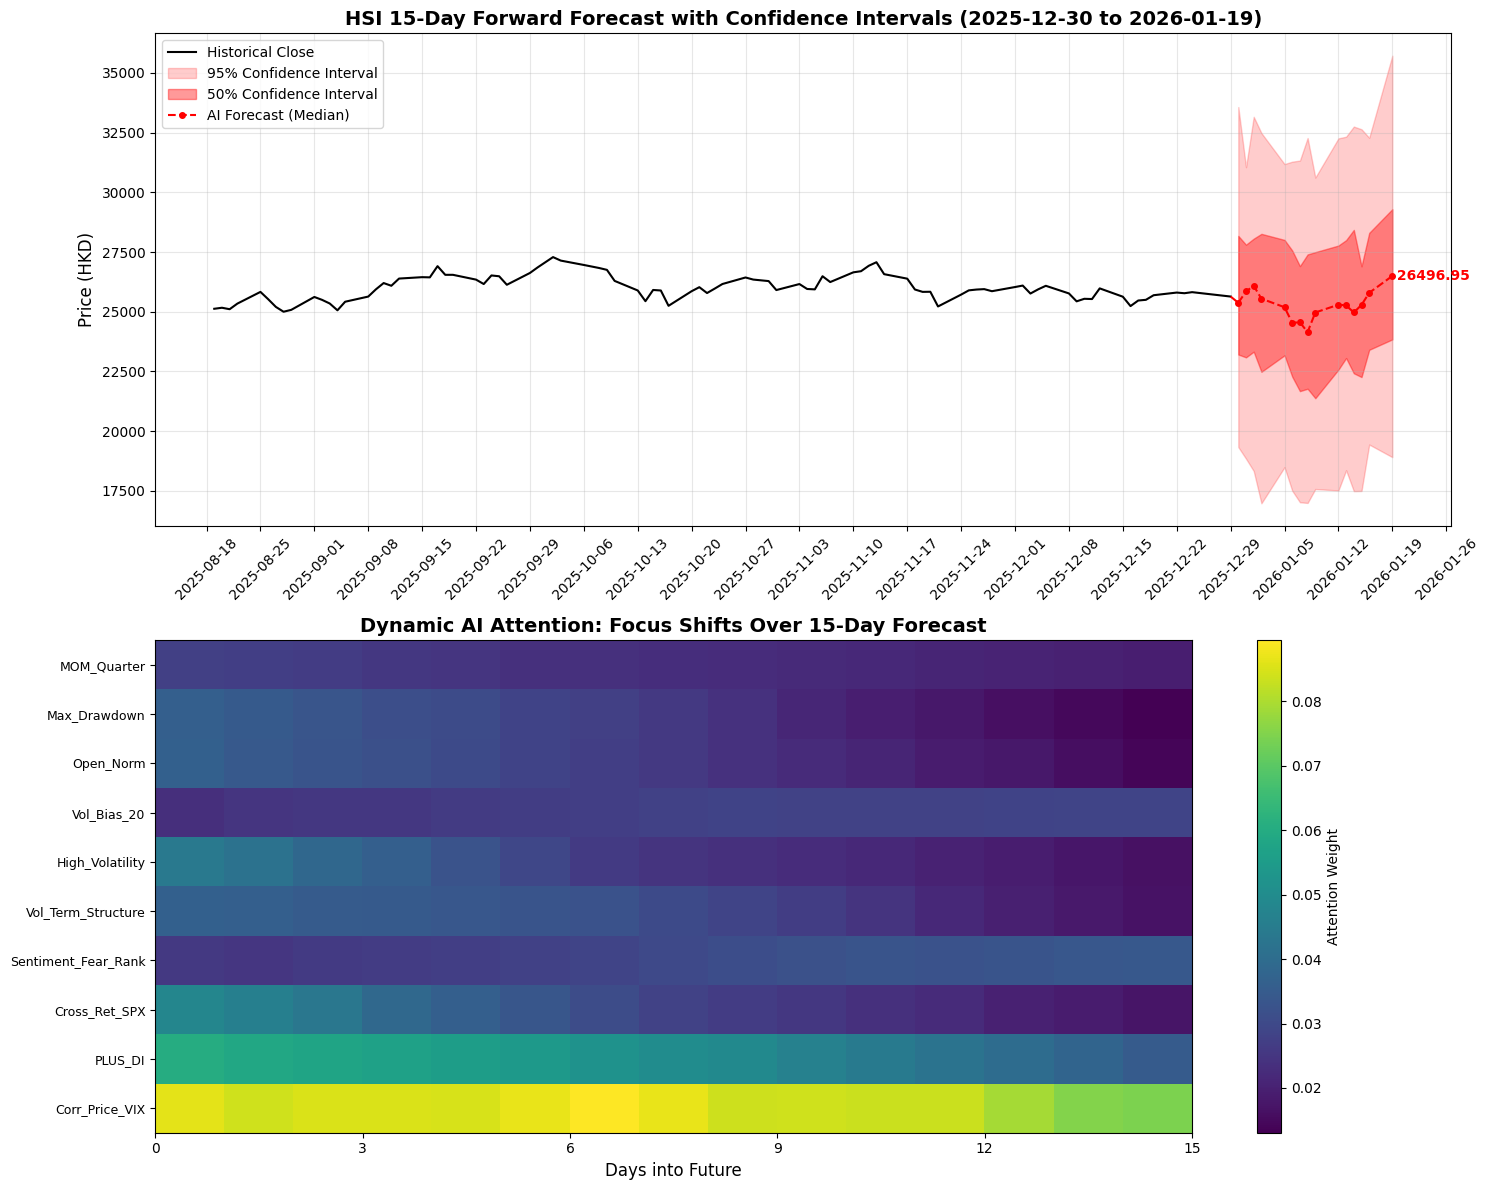


15-Day Forward Forecast with Confidence Intervals
Date            Median Price    95% Lower       95% Upper       50% Lower       50% Upper      
----------------------------------------------------------------------
2025-12-30          25375.15     19329.76     33571.39     23208.22     28173.90
2025-12-31          25847.21     18843.27     31053.43     23087.87     27807.48
2026-01-01          26084.93     18327.42     33163.30     23325.78     28059.55
2026-01-02          25545.69     16975.74     32482.97     22482.46     28261.03
2026-01-05          25187.90     18487.63     31184.32     23172.93     28006.98
2026-01-06          24538.62     17505.04     31283.94     22280.71     27564.50
2026-01-07          24554.79     17019.66     31329.90     21673.76     26909.38
2026-01-08          24144.28     16990.81     32275.38     21773.30     27399.55
2026-01-09          24966.88     17573.15     30617.85     21376.39     27494.79
2026-01-12          25293.70     17513.07     32259.9

In [40]:
# STEP 7: AUTOREGRESSIVE FORECAST (WITH MONTE CARLO SIMULATION & CONFIDENCE INTERVALS)
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import BDay

print("\n" + "=" * 70)
print("STEP 7: SIMULATING THE FUTURE (PATTERN-AWARE AI WITH CONFIDENCE INTERVALS)")
print("=" * 70)

# -------------------------- 补充核心依赖（纯pandas，无额外库） --------------------------
# 1. 替代pandas_market_calendars：用BDay+手动过滤生成交易日（兼容香港股市周末休市）
def get_next_trading_day(current_date):
    """
    生成下一个交易日（跳过周末，用BDay实现，纯pandas原生）
    current_date: 当前日期（datetime类型）
    返回：下一个交易日（datetime类型）
    """
    next_day = current_date + BDay(1)
    return next_day

# -------------------------- 核心预测逻辑（修复后） --------------------------
# 1. 配置参数
FORECAST_DAYS = 15
SEQUENCE_LENGTH = 20
MONTE_CARLO_SIMULATIONS = 100  # 蒙特卡洛模拟次数

# 2. 准备初始数据（确保索引为datetime类型）
history_df = df.copy()

if not pd.api.types.is_datetime64_any_dtype(history_df.index):
    history_df.index = pd.to_datetime(history_df.index)  # 强制转换为datetime索引

current_date = history_df.index[-1]
last_close_price = history_df['Close'].iloc[-1]

# 获取特征白名单（优先使用selected_features，如果不存在则使用patterns_df的列）
if 'selected_features' in globals() and selected_features is not None:
    feature_whitelist = selected_features.copy()
    print(f"✅ 使用特征白名单机制: {len(feature_whitelist)} 个特征")
else:
    # 如果没有selected_features，使用patterns_df的列作为白名单
    feature_whitelist = patterns_df.columns.tolist()
    print(f"⚠️ 未找到selected_features，使用patterns_df的列: {len(feature_whitelist)} 个特征")

# 验证白名单特征数量与scaler期望的一致
if hasattr(scaler, 'n_features_in_'):
    if len(feature_whitelist) != scaler.n_features_in_:
        print(f"⚠️ 警告: 特征白名单数量 {len(feature_whitelist)} 与 scaler 期望的 {scaler.n_features_in_} 不匹配")
        print(f"   将使用 scaler 期望的特征数量: {scaler.n_features_in_}")
        # 如果白名单特征数量多于scaler期望的，只取前n个
        if len(feature_whitelist) > scaler.n_features_in_:
            feature_whitelist = feature_whitelist[:scaler.n_features_in_]
        # 如果白名单特征数量少于scaler期望的，这不应该发生，但我们可以用patterns_df的列补充
        elif len(feature_whitelist) < scaler.n_features_in_:
            print(f"   错误: 特征白名单数量不足，无法继续")
            raise ValueError(f"特征白名单数量 {len(feature_whitelist)} 少于 scaler 期望的 {scaler.n_features_in_}")

print(f"Starting simulation from: {current_date.date()}")
print(f"Last Close Price: {last_close_price:.2f}")
print(f"Monte Carlo Simulations: {MONTE_CARLO_SIMULATIONS}")
print(f"Feature Whitelist Size: {len(feature_whitelist)}")

# 存储推演结果
future_dates = []
future_prices = []  # 存储单一预测价格（用于兼容）
future_attentions = []

# 存储蒙特卡洛模拟结果（用于置信区间）
monte_carlo_prices = []  # 形状: [FORECAST_DAYS, MONTE_CARLO_SIMULATIONS]

# 确保模型处于评估模式
model.eval()

print(f"\nSimulating {FORECAST_DAYS} trading days into the future...")

# ---------------------------------------------------------
# AUTOREGRESSIVE LOOP (自回归循环) + 蒙特卡洛模拟
# ---------------------------------------------------------
for i in range(FORECAST_DAYS):
    # A. 动态特征工程，计算新的pattern（只在每次预测时调用一次，优化效率）
    current_patterns_all = detect_trading_patterns(history_df)
    
    # B. 特征白名单过滤机制：强制只使用白名单中的特征
    # 1. 检查哪些白名单特征在当前patterns中存在
    available_features = [f for f in feature_whitelist if f in current_patterns_all.columns]
    missing_features = [f for f in feature_whitelist if f not in current_patterns_all.columns]
    
    # 2. 对于缺失的特征，用0填充
    if missing_features:
        for feat in missing_features:
            current_patterns_all[feat] = 0.0
    
    # 3. 严格按照白名单顺序选择特征（确保与训练时一致）
    current_patterns = current_patterns_all[feature_whitelist].copy()
    
    # 4. 最终验证：确保特征数量和顺序完全匹配
    if len(current_patterns.columns) != len(feature_whitelist):
        raise ValueError(f"特征数量不匹配: 期望 {len(feature_whitelist)} 个特征，实际得到 {len(current_patterns.columns)} 个特征")
    
    if list(current_patterns.columns) != feature_whitelist:
        # 如果顺序不一致，重新排序
        current_patterns = current_patterns[feature_whitelist].copy()
    
    # 5. 验证与scaler的一致性
    if hasattr(scaler, 'n_features_in_') and len(current_patterns.columns) != scaler.n_features_in_:
        raise ValueError(f"特征数量 {len(current_patterns.columns)} 与 scaler 期望的 {scaler.n_features_in_} 不匹配")

    # B. 准备模型输入（确保序列长度和归一化正确）
    if len(current_patterns) < SEQUENCE_LENGTH:
        raise ValueError(f"历史数据不足{SEQUENCE_LENGTH}天，无法生成输入序列")
    last_seq_raw = current_patterns.iloc[-SEQUENCE_LENGTH:].values
    last_seq_scaled = scaler.transform(last_seq_raw)
    input_tensor = torch.FloatTensor(last_seq_scaled).unsqueeze(0).to(device)

    # C. 模型预测（双输出：收益率 + 波动率）
    with torch.no_grad():
        pred_tensor, p_attn, t_attn, time_info = model(input_tensor)
        # pred_tensor 现在是2维：[收益率, 波动率]
        pred_returns_scaled = pred_tensor[0, 0].item()  # 收益率（标准化后）
        pred_volatility_scaled = pred_tensor[0, 1].item()  # 波动率（标准化后）
        
        # 反归一化
        pred_ret_pct = scaler_target_returns.inverse_transform([[pred_returns_scaled]])[0, 0]
        
        # 波动率反归一化（根据归一化方法选择）
        if VOLATILITY_SCALING_METHOD == 'log_standard':
            # 对数变换的反归一化
            pred_vol_pct = np.expm1(scaler_target_volatility.inverse_transform([[pred_volatility_scaled]])[0, 0])
        else:
            # 标准反归一化
            pred_vol_pct = scaler_target_volatility.inverse_transform([[pred_volatility_scaled]])[0, 0]
        
        # 确保波动率为正数
        pred_vol_pct = max(pred_vol_pct, 0.01)  # 最小波动率 0.01%
        
        # 不限制预测值（按用户要求取消限制）
        # 但可以添加警告
        if abs(pred_ret_pct) > 10:
            print(f"⚠️ Warning: Extreme return prediction: {pred_ret_pct:.2f}%")
        
        avg_p_attn = p_attn.mean(dim=1).cpu().numpy().flatten()

        # 展示第一天(明天)的关注点
        if i == 0:
            print("\n" + "-"*50)
            print("🔮 TOMORROW'S PATTERN ATTENTION (Forecast Day 1)")
            print("-"*50)

            # 排序并打印Top 10
            day1_importance = list(zip(feature_whitelist, avg_p_attn))
            day1_importance.sort(key=lambda x: x[1], reverse=True)

            for rank, (name, weight) in enumerate(day1_importance[:10], 1):
                print(f"{rank:2d}. {name:<25} {weight*100:5.2f}%")

            # 打印时间关注点
            avg_t_attn = t_attn.squeeze().cpu().numpy()
            peak_day = np.argmax(avg_t_attn)
            print(f"\nTime Attention Peak: Index {peak_day} (0=Oldest, {SEQUENCE_LENGTH-1}=Yesterday)")
            print("-"*50 + "\n")

    # D. 蒙特卡洛模拟：使用随机性生成价格分布
    # mu = 模型预测的收益率，sigma = 模型预测的波动率
    mu = pred_ret_pct
    sigma = pred_vol_pct
    
    # 生成随机收益率（正态分布）
    random_returns = np.random.normal(loc=mu, scale=sigma, size=MONTE_CARLO_SIMULATIONS)
    
    # 计算对应的价格
    simulated_prices = last_close_price * (1 + random_returns / 100)
    simulated_prices = np.maximum(simulated_prices, 0.01)  # 确保价格为正
    
    # 存储模拟结果
    monte_carlo_prices.append(simulated_prices)
    
    # 使用中位数作为单一预测价格（用于兼容原有逻辑）
    median_price = np.median(simulated_prices)
    new_price = median_price

    # E. 构造新的一行数据（完善所有必要列）
    next_date = get_next_trading_day(current_date)

    # 计算辅助指标（用于后续特征生成）
    recent_window = history_df.iloc[-20:]

    recent_atr = recent_window[['High', 'Low', 'Close']].apply(
        lambda x: max(x.iloc[0]-x.iloc[1], abs(x.iloc[0]-x.iloc[2]), abs(x.iloc[1]-x.iloc[2])),
        axis=1
    ).mean()
    recent_atr = recent_atr if not np.isnan(recent_atr) and recent_atr > 0 else last_close_price * 0.01
    # 使用过去20交易日的滚动平均值进行填充，若均值不可用则使用前一天的数值
    recent_vol_mean = recent_window['Volume'].mean()
    if not np.isnan(recent_vol_mean):
        recent_vol = recent_vol_mean
    else:
        # 若均值不可用，使用前一天的数值
        recent_vol = history_df['Volume'].iloc[-1] if len(history_df) > 0 and not pd.isna(history_df['Volume'].iloc[-1]) else 1e6

    # 构造新行
    new_row = pd.DataFrame({
        'Open': [new_price],
        'High': [new_price + recent_atr * 0.5],
        'Low': [new_price - recent_atr * 0.5],
        'Close': [new_price],
        'Volume': [recent_vol],
        'Log_Ret': [np.log(new_price / last_close_price)]
    }, index=[next_date])

    for col in history_df.columns:
        if col not in new_row.columns and col != 'Target':
            new_row[col] = 0.0

    # F. 更新状态
    history_df = pd.concat([history_df, new_row], ignore_index=False)
    current_date = next_date
    last_close_price = new_price

    # 记录结果
    future_dates.append(next_date)
    future_prices.append(new_price)
    future_attentions.append(avg_p_attn)

    # 打印进度
    if (i+1) % 5 == 0:
        print(f"Day {i+1}/{FORECAST_DAYS}: Predicted {pred_ret_pct:+.2f}%, Price {new_price:.2f}")

# ============================================================
# VISUALIZATION WITH CONFIDENCE INTERVALS
# ============================================================
print("\n[PLOTTING FORECAST WITH CONFIDENCE INTERVALS]")

# 转换 monte_carlo_prices 为 numpy 数组
monte_carlo_prices_array = np.array(monte_carlo_prices)  # 形状: [FORECAST_DAYS, MONTE_CARLO_SIMULATIONS]

# 计算分位数（用于置信区间）
price_percentiles = {
    'median': np.median(monte_carlo_prices_array, axis=1),  # 中位数
    'p2.5': np.percentile(monte_carlo_prices_array, 2.5, axis=1),  # 95%置信区间下界
    'p25': np.percentile(monte_carlo_prices_array, 25, axis=1),  # 50%置信区间下界
    'p75': np.percentile(monte_carlo_prices_array, 75, axis=1),  # 50%置信区间上界
    'p97.5': np.percentile(monte_carlo_prices_array, 97.5, axis=1),  # 95%置信区间上界
}

plt.figure(figsize=(15, 12))

# 1. Price Forecast Chart with Confidence Intervals
plt.subplot(2, 1, 1)
recent_history = df.iloc[-90:]

# 绘制历史价格
plt.plot(recent_history.index, recent_history['Close'], label='Historical Close', 
         color='black', linewidth=1.5)

# 绘制置信区间（95%和50%）
# 95%置信区间（外圈，较浅）
plt.fill_between(future_dates, price_percentiles['p2.5'], price_percentiles['p97.5'],
                 alpha=0.2, color='red', label='95% Confidence Interval')

# 50%置信区间（内圈，较深）
plt.fill_between(future_dates, price_percentiles['p25'], price_percentiles['p75'],
                 alpha=0.4, color='red', label='50% Confidence Interval')

# 绘制中位数预测线
plt.plot(future_dates, price_percentiles['median'], label='AI Forecast (Median)', 
         color='red', linestyle='--', marker='o', markersize=4, linewidth=1.5)

# 连接历史与预测数据
plt.plot([recent_history.index[-1], future_dates[0]],
         [recent_history['Close'].iloc[-1], price_percentiles['median'][0]],
         color='red', linestyle='--', linewidth=1.5)

# 添加最终价格标签
plt.text(future_dates[-1], price_percentiles['median'][-1], 
         f" {price_percentiles['median'][-1]:.2f}",
         color='red', fontweight='bold', va='center', fontsize=10)

# Get forecast date range from future_dates
forecast_start_date_plot = future_dates[0].strftime('%Y-%m-%d')
forecast_end_date_plot = future_dates[-1].strftime('%Y-%m-%d')
plot_title_suffix = f" ({forecast_start_date_plot} to {forecast_end_date_plot})"

plt.title(f'{ticker.ticker.replace("^", "")} 15-Day Forward Forecast with Confidence Intervals{plot_title_suffix}', 
          fontsize=14, fontweight='bold')
plt.ylabel('Price (HKD)', fontsize=12)
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
# 格式化x轴日期
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=7))
plt.xticks(rotation=45)

# 2. Future Attention Heatmap
plt.subplot(2, 1, 2)
attn_matrix = np.array(future_attentions)

# 只显示平均注意力最高的10个特征（避免图表拥挤）
avg_sim_attn = np.mean(attn_matrix, axis=0)
top_idx = np.argsort(avg_sim_attn)[-10:]  # 取Top 10特征的索引
top_names = [feature_whitelist[i] for i in top_idx]
top_matrix = attn_matrix[:, top_idx]

# 绘制热力图
im = plt.imshow(top_matrix.T, aspect='auto', cmap='viridis', interpolation='nearest',
                extent=[0, FORECAST_DAYS, 0, 10])

plt.yticks(np.arange(0.5, 10.5, 1), top_names, fontsize=9)
plt.xlabel('Days into Future', fontsize=12)
plt.title('Dynamic AI Attention: Focus Shifts Over 15-Day Forecast', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Attention Weight')
# x轴刻度与预测天数对应
plt.xticks(range(0, FORECAST_DAYS+1, 3))

plt.tight_layout()
plt.show()

# ============================================================
# 打印预测结果表
# ============================================================
print("\n" + "=" * 70)
print("15-Day Forward Forecast with Confidence Intervals")
print("=" * 70)
print(f"{'Date':<15} {'Median Price':<15} {'95% Lower':<15} {'95% Upper':<15} {'50% Lower':<15} {'50% Upper':<15}")
print("-" * 70)

for i, date in enumerate(future_dates):
    print(f"{date.strftime('%Y-%m-%d'):<15} "
          f"{price_percentiles['median'][i]:>12.2f} "
          f"{price_percentiles['p2.5'][i]:>12.2f} "
          f"{price_percentiles['p97.5'][i]:>12.2f} "
          f"{price_percentiles['p25'][i]:>12.2f} "
          f"{price_percentiles['p75'][i]:>12.2f}")

print("=" * 70)
print(f"Final Forecast Price (Median): {price_percentiles['median'][-1]:.2f} HKD")
total_change = (price_percentiles['median'][-1] - df['Close'].iloc[-1]) / df['Close'].iloc[-1] * 100
print(f"Total Predicted Change: {total_change:+.2f}%")
print("=" * 70)




STEP 8: SCENARIO BACKTESTING (FINAL STABLE VERSION)
未输入代码，使用默认值：^HSI（恒生指数）

正在验证代码 ^HSI 的有效性...
✅ 代码 ^HSI 验证通过！
   [FIX] Fetching VIX (^HSIL) and external assets...
   Dropped 0 rows due to NaNs or zero volume.
⚠️ 最新日期 2025-12-29 的Volume为0，已填充为前一日值: 1236300000
✅ 未输入值，自动填充为前一日Volume：1236300000
   [Re-initialized] df has 1227 rows.
   [Re-initialized] patterns_df has 1227 rows and 123 features.
   Using Device: cpu
   使用生成的 patterns_df：共 123 个特征
   最新数据日期: 2025-12-29
   总交易天数: 1227

🚀 Running Scenario: [Reserve 1 Month]
   Cutoff Date: 2025-11-27
  进行特征筛选（RandomForest）...
    原始特征数: 123
    筛选后特征数: 60
    特征保留率: 48.8%
   训练序列数: 1176 | 验证集天数: 20
   Training model... Done (Final Loss: 0.817398)
   Simulating 65 days (Holdout: 20, Future: 45)...

🚀 Running Scenario: [Reserve 15 Days]
   Cutoff Date: 2025-12-08
  进行特征筛选（RandomForest）...
    原始特征数: 123
    筛选后特征数: 60
    特征保留率: 48.8%
   训练序列数: 1183 | 验证集天数: 13
   Training model... Done (Final Loss: 0.861780)
   Simulating 58 days (Holdout: 1

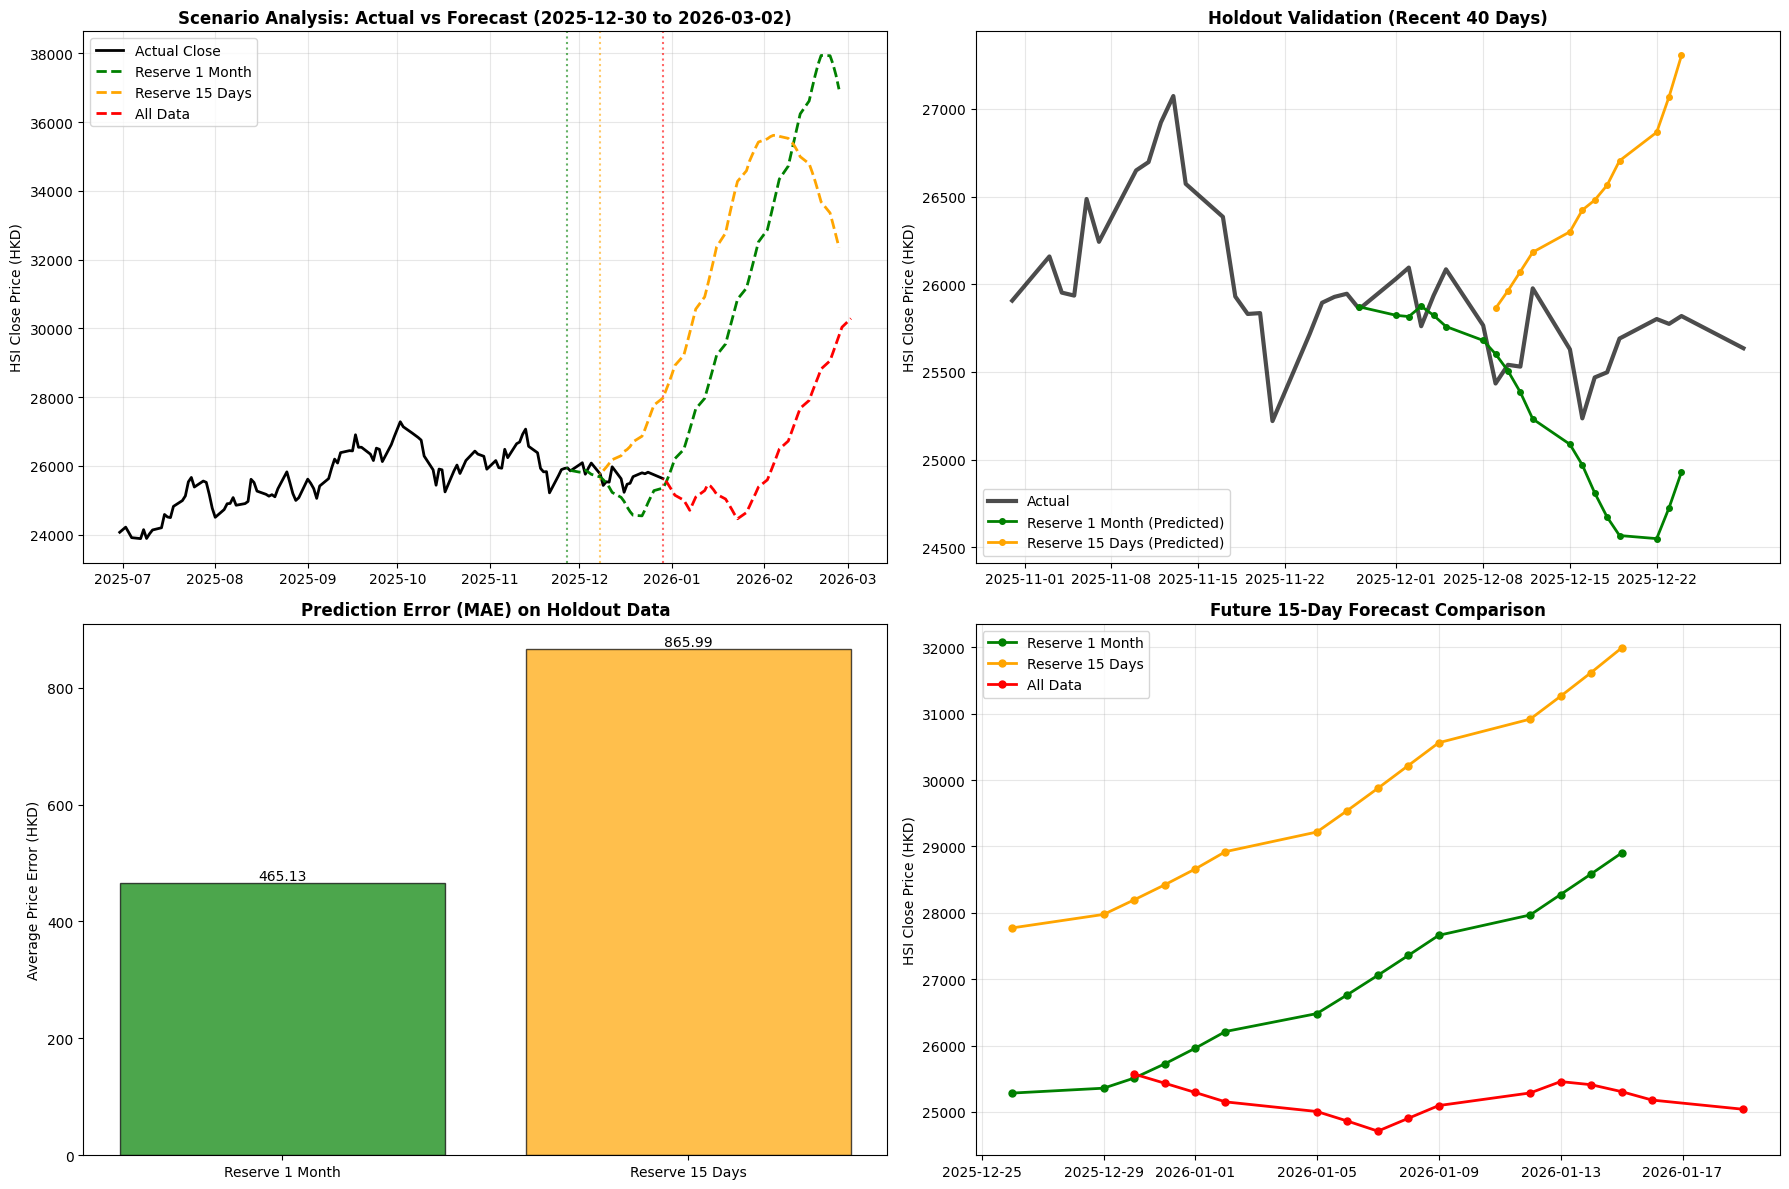


=== SCENARIO BACKTESTING SUMMARY ===

📊 [Reserve 1 Month]
   Training Cutoff: 2025-11-27
   Train Sequences: 1176
   Holdout Days: 20
   Holdout MAE: 465.13 HKD
   Top 10 Important Patterns (Attention Weight):
      1. Vol_Rel_5                        8.99%
      2. Sentiment_Fear_Rank              7.17%
      3. Breakdown_Low                    6.20%
      4. Strong_Momentum_Down             6.20%
      5. Drawdown_Bounce                  4.77%
      6. RSI_Oversold                     3.21%
      7. Corr_Price_VIX                   2.88%
      8. Low_Volatility                   2.56%
      9. BB_Pos_Norm                      2.42%
     10. Vol_Price_Up_Confirm             2.37%
   Time Attention Peak: Day 5 (0=Oldest, 29=Yesterday)

📊 [Reserve 15 Days]
   Training Cutoff: 2025-12-08
   Train Sequences: 1183
   Holdout Days: 13
   Holdout MAE: 865.99 HKD
   Top 10 Important Patterns (Attention Weight):
      1. Sentiment_Fear_Rank             10.89%
      2. Breakout_Confirm        

In [41]:
# ============================================================
# STEP 8: SCENARIO BACKTESTING (FINAL STABLE VERSION)
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from pandas.tseries.offsets import BDay
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from datetime import datetime, timedelta
import json
import os


print("\n" + "=" * 70)
print("STEP 8: SCENARIO BACKTESTING (FINAL STABLE VERSION)")
print("=" * 70)

# ====================================================================
# 【修复 1】 数据初始化和外部资产合并 (必须匹配 detect_trading_patterns 的输入)
# ====================================================================
# 1. 基础输入（带默认值，回车直接用恒生指数）
ticker_symbol = input("请输入要回测的股票/指数代码（默认：^HSI 恒生指数）：").strip()
# 2. 空输入时用默认值
if not ticker_symbol:
    ticker_symbol = "^HSI"
    print(f"未输入代码，使用默认值：{ticker_symbol}（恒生指数）")

# 3. 输入校验（检查yfinance是否能获取该代码的数据）
print(f"\n正在验证代码 {ticker_symbol} 的有效性...")
temp_ticker = yf.Ticker(ticker_symbol)
temp_df = temp_ticker.history(period="1d")  # 仅获取1天数据验证

if temp_df.empty:
    # 校验失败，提示并强制使用默认值
    print(f"⚠️ 输入的代码 {ticker_symbol} 无效（无数据），自动切换为默认值 ^HSI")
    ticker_symbol = "^HSI"
    ticker = yf.Ticker(ticker_symbol)
else:
    # 校验成功，创建Ticker对象
    print(f"✅ 代码 {ticker_symbol} 验证通过！")
    ticker = yf.Ticker(ticker_symbol)

#end_date = datetime.now()

end_date = datetime.now()+timedelta(days=1)

start_date = end_date - timedelta(days=5*365) # 使用 5 年数据

# --- 1. 获取 HSI 基础数据 ---
df = ticker.history(start=start_date, end=end_date)

# --- NEW: Check if primary HSI data is empty ---
if df.empty:
    print("   ❌ Error: HSI data for the last 5 years is empty. Attempting a wider fetch (20 years).")
    start_date = end_date - timedelta(days=20*365)
    df = ticker.history(start=start_date, end=end_date)
    if df.empty:
        raise ValueError("Critical Error: HSI data could not be fetched even for 20 years. Cannot proceed.")

df.index = pd.to_datetime(df.index).tz_localize(None) # Ensure df index is tz-naive
df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))

# --- 2. 获取 VIX (^HSIL) 数据 ---
print("   [FIX] Fetching VIX (^HSIL) and external assets...")
vix_ticker = yf.Ticker("^HSIL")
vix_df = vix_ticker.history(start=start_date, end=end_date)
# Ensure vix_df index is tz-naive before joining
vix_df.index = pd.to_datetime(vix_df.index).tz_localize(None)
if not vix_df.empty:
    df = df.join(vix_df['Close'].rename('VIX_Close').shift(1), how='left')
else:
    print("      ⚠️ Warning: ^HSIL data is empty. Using fallback value 20.0.")
    df['VIX_Close'] = 20.0 # Fallback if VIX data is entirely missing

# --- 3. 获取其他外部资产数据 ---
tickers_dict = {
    'SPX_Close': '^GSPC', 'SSE_Close': '000001.SS',
    'USDCNH_Close': 'CNH=F', 'US10Y_Close': '^TNX',
    'USDHKD_Close': 'HKD=X', 'DXY_Close': 'DX-Y.NYB',
    'GOLD_Close': 'GC=F'
}
for col_name, ticker_symbol in tickers_dict.items():
    try:
        ext_df = yf.Ticker(ticker_symbol).history(start=start_date, end=end_date)
        # Ensure ext_df index is tz-naive before joining
        ext_df.index = pd.to_datetime(ext_df.index).tz_localize(None)
        if not ext_df.empty:
            df = df.join(ext_df['Close'].rename(col_name).shift(1), how='left')
        else:
            print(f"      ⚠️ Warning: {col_name} data is empty. Filling with NaN to be handled by later fillna.")
            df[col_name] = np.nan # Add as NaN if empty, will be filled next
    except Exception as e:
        print(f"      ❌ Error fetching {ticker_symbol}: {e}. Filling with NaN.")
        df[col_name] = np.nan

# --- 4. 最终清洗和填充 ---
external_cols = list(tickers_dict.keys()) + ['VIX_Close']

# Use ffill, then a rolling mean, then a final static fill for any remaining NaNs
df[external_cols] = df[external_cols].ffill()
# Calculate rolling mean BEFORE general fillna, on potentially existing data
for col in external_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].rolling(30, min_periods=1).mean())
# Final fill for any remaining NaNs, e.g., if first 30 days are NaN or if the rolling mean is NaN
# Use the column's mean as a last resort, but only for columns that exist
for col in external_cols:
    if col in df.columns and df[col].isnull().any():
        col_mean = df[col].mean()
        if not np.isnan(col_mean):
            df[col] = df[col].fillna(col_mean)
        else:
            # If even the mean is NaN (e.g., column is all NaNs), fill with a sensible default like 0 or 1.0
            # For prices/indices, 1.0 might be more appropriate than 0 to avoid division by zero later.
            df[col] = df[col].fillna(1.0) # Fallback to 1.0 for price-like data if all else fails


# Recalculate external asset returns, ensuring no NaNs from empty data after processing
df['SPX_Ret'] = df['SPX_Close'].pct_change(fill_method=None).fillna(0)
df['SSE_Ret'] = df['SSE_Close'].pct_change(fill_method=None).fillna(0)

# Critical step: filter out rows with any NaNs *only after* all attempts to fill have been made.
# Also ensure there's still data after filtering.
original_df_rows = len(df)
df = df.dropna(subset=['Close', 'Open', 'High', 'Low'] + external_cols)
if df.empty:
    raise ValueError("Critical Error: DataFrame became empty after dropping rows with NaNs in essential columns. Data too sparse to proceed.")
else:
   latest_date = df.index[-1].date()
print(f"   Dropped {original_df_rows - len(df)} rows due to NaNs or zero volume.")

df = df[
    (df['Volume'] > 0) |  # 非最新日期：Volume必须大于0
    (df.index.date == latest_date)  # 最新日期：允许Volume=0
]

# 3. 填充最新日期的0成交量为前一日值
if (df.index.date == latest_date).any():  # 确认最新日期行存在
    latest_volume = df.loc[df.index.date == latest_date, 'Volume'].iloc[0]
    if latest_volume == 0:
        # 取前一日的Volume值填充
        prev_volume = df.loc[df.index.date < latest_date, 'Volume'].iloc[-1]
        print(f"⚠️ 最新日期 {latest_date} 的Volume为0，已填充为前一日值: {prev_volume}")
        manual_input = input(f"请输入该日期的Volume值（回车默认使用前一日有效值：{prev_volume}）：").strip()

        try:
            if manual_input == "":  # 无输入，用默认值
                fill_volume = prev_volume
                print(f"✅ 未输入值，自动填充为前一日Volume：{fill_volume}")
            else:  # 有输入，转换为数值
                fill_volume = float(manual_input)
                print(f"✅ 已使用手动输入值填充：{fill_volume}")
        except ValueError:  # 输入非数字，兜底用默认值
            fill_volume = prev_volume
            print(f"⚠️ 输入非数字，自动填充为前一日Volume：{fill_volume}")

        # 执行填充
        df.loc[df.index.date == latest_date, 'Volume'] = fill_volume

# 4. 最终校验：过滤后是否为空（兜底）
if df.empty:
    raise ValueError("Critical Error: DataFrame became empty after filtering for Volume > 0. No valid trading days.")

if not pd.api.types.is_datetime64_any_dtype(df.index):
    df.index = pd.to_datetime(df.index)

# ====================================================================
# 重新生成 patterns_df
# ====================================================================

if 'detect_trading_patterns' not in globals():
    raise NameError("The 'detect_trading_patterns' function is not defined. Please ensure previous steps defining it have been executed.")

# Now that df is guaranteed not to be empty (or an error would have been raised)
patterns_df = detect_trading_patterns(df.copy()) # Generate patterns_df from the fresh df

# --- NEW: Check if patterns_df is empty ---
if patterns_df.empty:
    raise ValueError("Critical Error: patterns_df is empty after feature detection. Cannot proceed.")

# Ensure patterns_df and df align. If patterns_df lost some rows (e.g. due to internal calculations resulting in NaN),
# then df should also be adjusted.
original_patterns_rows = len(patterns_df)
patterns_df = patterns_df.dropna() # Ensure no NaNs in patterns_df features
if patterns_df.empty:
    raise ValueError("Critical Error: patterns_df became empty after dropping rows with NaNs. Features too sparse to proceed.")

if original_patterns_rows != len(patterns_df):
    print(f"   Dropped {original_patterns_rows - len(patterns_df)} rows from patterns_df due to internal NaNs.")

df = df.loc[patterns_df.index] # Align df to the cleaned patterns_df

if df.empty:
    raise ValueError("Critical Error: df became empty after aligning with patterns_df. Data too sparse.")

print(f"   [Re-initialized] df has {len(df)} rows.")
print(f"   [Re-initialized] patterns_df has {len(patterns_df)} rows and {patterns_df.shape[1]} features.")

# ===================== 关键配置 =====================
# 1. 定义设备（CPU/GPU自动检测）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"   Using Device: {device}")

# 2. 复用 patterns_df（现在已确保与 df 对齐）
print(f"   使用生成的 patterns_df：共 {patterns_df.shape[1]} 个特征")

# 3. 配置参数（与Step 3一致）
SEQUENCE_LENGTH = 30  # 与Step 3一致
forecast_horizon_days = 45
comparison_horizon = 15
SCENARIO_EPOCHS = 100  # 与Step 3一致
LEARNING_RATE = 0.0008  # 与Step 3一致
WEIGHT_DECAY = 5e-4  # 与Step 3一致
BATCH_SIZE = 64  # 与Step 3一致
HIDDEN_SIZE = 16  # 与Step 3一致
DROPOUT = 0.5  # 与Step 3一致

# 4. 获取基础数据（现在已确保是最新的df）
latest_date = df.index[-1]
print(f"   最新数据日期: {latest_date.date()}")
print(f"   总交易天数: {len(df)}")

# =====================  PatternAwareLSTM 模型 (与Step 3一致) =====================
class PatternAwareLSTM(nn.Module):
    def __init__(self, num_patterns, hidden_size=16, output_size=1, dropout=0.5):
        super(PatternAwareLSTM, self).__init__()

        # Pattern Attention
        self.pattern_attn_fc = nn.Linear(num_patterns, num_patterns, bias=False)

        # LSTM
        self.lstm = nn.LSTM(input_size=num_patterns,
                            hidden_size=hidden_size,
                            num_layers=2,
                            batch_first=True,
                            dropout=0.3)  # 单层禁用dropout，避免冗余警告

        # Time Attention
        self.time_attn_fc = nn.Linear(hidden_size, 1, bias=False)

        # 输出层（强dropout+线性映射）
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (Batch, Seq_Len, Num_Patterns)

        # 1. Pattern Attention（保持输出格式：(B, S, P)）
        p_scores = self.pattern_attn_fc(x)
        p_weights = torch.softmax(p_scores, dim=2)
        x_weighted = x * p_weights

        # 2. LSTM Forward（保持输出格式：(B, S, H)）
        lstm_out, _ = self.lstm(x_weighted)

        # 3. Time Attention（保持输出格式：(B, S, 1)）
        t_scores = self.time_attn_fc(lstm_out)
        t_weights = torch.softmax(t_scores, dim=1)
        context = torch.sum(lstm_out * t_weights, dim=1)  # (B, H)

        # 4. Prediction（保持输出格式：(B, 1)）
        output = self.fc(self.dropout(context))

        return output, p_weights, t_weights

# ===================== 场景分析函数 =====================
def run_scenario_analysis(train_cutoff_date, label):

    print(f"\n🚀 Running Scenario: [{label}]")
    print(f"   Cutoff Date: {train_cutoff_date.date()}")

    # -----------------------------------------------------
    # 1. 数据切片
    # -----------------------------------------------------
    # 训练集/验证集切片
    train_mask = df.index <= train_cutoff_date
    train_df_scenario = df[train_mask].copy()
    holdout_df_real = df[~train_mask].copy()
    patterns_train_scenario = patterns_df[train_mask].copy()

    # 目标值：未来1日收益率（与Step 3一致：百分比形式）
    y_train_raw = train_df_scenario['Close'].pct_change().shift(-1).dropna().values * 100  # 预测下一日收益率（百分比）
    patterns_train_aligned = patterns_train_scenario.iloc[:-1].copy()
    y_train_raw = y_train_raw[:len(patterns_train_aligned)]

    if len(patterns_train_aligned) < SEQUENCE_LENGTH + 1:
        return {
            'label': label, 'train_cutoff': train_cutoff_date, 'mae': np.nan,
            'full_sim_df': pd.DataFrame(), 'forecast_15': pd.DataFrame(), 'pattern_summary': [],
            'train_sequences': 0, 'holdout_sequences': 0, 'ohclv_forecast': pd.DataFrame(),
            'time_attention': None
        }

    # ============================================================
    # 特征筛选：使用STEP 1.5筛选后的特征列表（不再重新筛选）
    # ============================================================
    SAVE_DIR = './model_artifacts'
    selected_features_path = os.path.join(SAVE_DIR, 'selected_features.json')
    
    # 尝试加载STEP 1.5保存的特征列表
    if os.path.exists(selected_features_path):
        print(f"  加载STEP 1.5筛选后的特征列表...")
        with open(selected_features_path, 'r', encoding='utf-8') as f:
            selected_features = json.load(f)
        print(f"    已加载 {len(selected_features)} 个特征")
        
        # 验证特征是否存在于当前数据中
        available_features = patterns_train_aligned.columns.tolist()
        missing_features = [f for f in selected_features if f not in available_features]
        
        if missing_features:
            print(f"    ⚠️ 警告: {len(missing_features)} 个特征在当前数据中不存在，将使用可用特征")
            selected_features = [f for f in selected_features if f in available_features]
        
        # 更新patterns_train_aligned为筛选后的特征
        patterns_train_aligned = patterns_train_aligned[selected_features].copy()
        
        print(f"    筛选后特征数: {len(selected_features)}")
        print(f"    特征保留率: {len(selected_features)/len(patterns_train_aligned.columns)*100:.1f}%")
    else:
        # 如果文件不存在，回退到原始特征筛选逻辑
        print(f"  ⚠️ 未找到STEP 1.5的特征列表文件，使用原始特征筛选逻辑...")
        from sklearn.ensemble import RandomForestRegressor
        
        TOP_N_FEATURES = 60  # 保留前60个最重要特征
        
        print(f"  进行特征筛选（RandomForest）...")
        print(f"    原始特征数: {patterns_train_aligned.shape[1]}")
        
        # 准备数据（需要计算波动率作为目标变量）
        X_feature = patterns_train_aligned.values
        feature_names = patterns_train_aligned.columns.tolist()
        
        # 计算波动率（使用收益率标准差）
        returns_series = train_df_scenario['Close'].pct_change().iloc[1:len(patterns_train_aligned)+1]
        volatility_target = returns_series.rolling(window=20, min_periods=1).std().fillna(0.01).values * 100  # 转换为百分比
        
        # 对齐目标变量
        y_returns_train = y_train_raw
        y_volatility_train = volatility_target[:len(y_returns_train)]
        
        # 1. 训练收益率模型
        rf_returns = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=42,
            n_jobs=-1
        )
        rf_returns.fit(X_feature, y_returns_train)
        importance_returns = rf_returns.feature_importances_
        
        # 2. 训练波动率模型
        rf_volatility = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=42,
            n_jobs=-1
        )
        rf_volatility.fit(X_feature, y_volatility_train)
        importance_volatility = rf_volatility.feature_importances_
        
        # 3. 计算综合重要性（0.7 * 收益率 + 0.3 * 波动率）
        importance_combined = 0.7 * importance_returns + 0.3 * importance_volatility
        
        # 4. 创建重要性DataFrame并排序
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance_Returns': importance_returns,
            'Importance_Volatility': importance_volatility,
            'Importance_Combined': importance_combined
        })
        importance_df = importance_df.sort_values('Importance_Combined', ascending=False)
        
        # 5. 选择前60个特征
        selected_features = importance_df.head(TOP_N_FEATURES)['Feature'].tolist()
        
        # 6. 更新patterns_train_aligned为筛选后的特征
        patterns_train_aligned = patterns_train_aligned[selected_features].copy()
        
        print(f"    筛选后特征数: {len(selected_features)}")
        print(f"    特征保留率: {len(selected_features)/len(feature_names)*100:.1f}%")
    
    # 特征标准化（仅用训练集拟合，避免数据泄露）
    local_scaler = StandardScaler()
    local_scaler_target = StandardScaler()  # 目标变量标准化器（与Step 3一致）
    X_train_scaled = local_scaler.fit_transform(patterns_train_aligned.values)
    y_train_raw = y_train_raw.reshape(-1, 1)
    y_train_scaled = local_scaler_target.fit_transform(y_train_raw)  # 标准化目标变量

    # 创建LSTM序列数据
    X_seq, y_seq = [], []
    for i in range(len(X_train_scaled) - SEQUENCE_LENGTH):
        X_seq.append(X_train_scaled[i:i+SEQUENCE_LENGTH])
        y_seq.append(y_train_scaled[i+SEQUENCE_LENGTH])  # 使用标准化后的y

    X_train_tensor = torch.FloatTensor(np.array(X_seq)).to(device)
    y_train_tensor = torch.FloatTensor(np.array(y_seq)).to(device)
    print(f"   训练序列数: {len(X_seq)} | 验证集天数: {len(holdout_df_real)}")

    # -----------------------------------------------------
    # 2. 模型创建与特征数量验证
    # -----------------------------------------------------
    # 使用筛选后的特征数量（与STEP 3一致）
    num_patterns_selected = patterns_train_aligned.shape[1]  # 筛选后的特征数（60个）
    
    # 验证特征数量（如果STEP 3模型配置存在，进行验证）
    model_config_path = os.path.join(SAVE_DIR, 'model_config.json')
    if os.path.exists(model_config_path):
        with open(model_config_path, 'r', encoding='utf-8') as f:
            model_config = json.load(f)
        expected_num_patterns = model_config.get('num_patterns', None)
        
        if expected_num_patterns is not None:
            if num_patterns_selected != expected_num_patterns:
                print(f"    ⚠️ 警告: 特征数量不匹配!")
                print(f"      当前特征数: {num_patterns_selected}")
                print(f"      STEP 3模型期望特征数: {expected_num_patterns}")
                print(f"      将使用当前特征数创建模型")
            else:
                print(f"    ✅ 特征数量验证通过: {num_patterns_selected} 个特征")
    
    local_model = PatternAwareLSTM(num_patterns=num_patterns_selected, 
                                    hidden_size=HIDDEN_SIZE, 
                                    dropout=DROPOUT).to(device)
    
    # 损失函数+优化器（与Step 3一致）
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(local_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    # 学习率调度器（与Step 3一致）
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=20, factor=0.5)
    
    # 创建DataLoader（与Step 3一致）
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor),
                              batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

    local_model.train()
    print(f"   Training model...", end="")
    train_losses = []
    best_loss = float('inf')
    patience_counter = 0
    patience = 20
    
    for epoch in range(SCENARIO_EPOCHS):
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            out, _, _ = local_model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # 学习率调度
        scheduler.step(avg_loss)
        
        # 早停判断
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f" (Early stopping at epoch {epoch+1})", end="")
                break
    
    print(f" Done (Final Loss: {avg_loss:.6f})")

    # -----------------------------------------------------
    # 3. 自回归推演
    # -----------------------------------------------------
    holdout_days = len(holdout_df_real)
    total_sim_days = holdout_days + forecast_horizon_days
    print(f"   Simulating {total_sim_days} days (Holdout: {holdout_days}, Future: {forecast_horizon_days})...")
    #

    # 初始化推演数据（使用筛选后的特征）
    current_history = train_df_scenario.copy()
    current_patterns = patterns_train_aligned.copy()  # 使用筛选后的特征（60个）
    current_date_cursor = train_cutoff_date
    last_close = train_df_scenario['Close'].iloc[-1]

    sim_dates = []
    ohclv_data = []
    top_patterns_list = []
    all_t_attn = []

    local_model.eval()

    for i in range(total_sim_days):
        # 确保有足够历史数据生成序列
        if len(current_patterns) < SEQUENCE_LENGTH:
            pred_pct = np.random.normal(0, 0.003)
            p_attn_flat = np.zeros(len(selected_features))  # 使用筛选后的特征数量（60个）
            t_attn_flat = np.zeros(SEQUENCE_LENGTH)
        else:
            # 提取最新序列并标准化
            last_seq = current_patterns.iloc[-SEQUENCE_LENGTH:].values
            last_seq_scaled = local_scaler.transform(last_seq)
            input_tensor = torch.FloatTensor(last_seq_scaled).unsqueeze(0).to(device)

            # 预测收益率（与Step 3一致：模型输出是标准化的）
            with torch.no_grad():
                pred_ret, p_attn, t_attn = local_model(input_tensor)
                pred_ret_scaled = pred_ret.item()  # 标准化后的预测值
                
                # 反标准化（与Step 3一致）
                pred_pct = local_scaler_target.inverse_transform([[pred_ret_scaled]])[0][0]
                
                # 限制预测收益在[-5, 5]%之间（避免极端值导致价格不合理，与Step 7一致）
                pred_pct = np.clip(pred_pct, -5.0, 5.0)

                # 记录注意力
                p_attn_flat = p_attn.mean(dim=1).cpu().numpy().flatten()
                t_attn_flat = t_attn.squeeze().cpu().numpy()

                # 记录第一天的Top10特征注意力（仅一次）
                if i == 0:
                    top_indices = np.argsort(p_attn_flat)[-min(10, len(p_attn_flat)):][::-1]
                    for idx in top_indices:
                        if idx < len(patterns_df.columns):
                            name = patterns_df.columns[idx]
                            weight = p_attn_flat[idx]
                            top_patterns_list.append((name, weight))

        # 记录时间注意力
        all_t_attn.append(t_attn_flat)

        # 计算预测价格（与Step 7一致：百分比形式）
        new_price = last_close * (1 + pred_pct / 100)
        new_price = max(new_price, 0.01)

        # 生成下一个交易日
        next_date = current_date_cursor + BDay(1)

        # 生成合理的OHLC和成交量数据 (使用更稳健的计算，确保所有外部资产列存在)
        recent_std = current_history['Close'].iloc[-20:].std() if len(current_history) >= 20 else last_close * 0.01
        recent_std = recent_std if not np.isnan(recent_std) else last_close * 0.01

        new_row_data = pd.DataFrame({
            'Open': [new_price * np.random.uniform(0.998, 1.002)],
            'High': [new_price + recent_std * np.random.uniform(0.5, 1.2)],
            'Low': [new_price - recent_std * np.random.uniform(0.5, 1.2)],
            'Close': [new_price],
            'Volume': [current_history['Volume'].iloc[-20:].mean() if len(current_history) >= 20 else 5000],
            'Log_Ret': [np.log(new_price / last_close)],
        }, index=[next_date])

        #  添加外部资产列的模拟值，防止 detect_trading_patterns 报错
        for col in external_cols:
            if col in current_history.columns and col not in new_row_data.columns:
                # 使用当天的收盘价/值作为下一交易日的外部市场“输入”
                new_row_data[col] = current_history[col].iloc[-1]
            elif col not in current_history.columns and col not in new_row_data.columns:
                # If a column was added to external_cols but was never in current_history, default it
                new_row_data[col] = 1.0 # Or some other sensible default

        # 确保 Log_Ret 和其他衍生列被正确计算
        new_row_data['SPX_Ret'] = (new_row_data['SPX_Close'] / current_history['SPX_Close'].iloc[-1] - 1).fillna(0) if 'SPX_Close' in new_row_data.columns and not current_history['SPX_Close'].empty else 0
        new_row_data['SSE_Ret'] = (new_row_data['SSE_Close'] / current_history['SSE_Close'].iloc[-1] - 1).fillna(0) if 'SSE_Close' in new_row_data.columns and not current_history['SSE_Close'].empty else 0

        # 添加到 OHLCV 记录
        ohclv_data.append([
            next_date, new_row_data['Open'].iloc[0], new_row_data['High'].iloc[0],
            new_row_data['Low'].iloc[0], new_row_data['Close'].iloc[0],
            new_row_data['Volume'].iloc[0]
        ])

        # 更新历史数据
        current_history = pd.concat([current_history, new_row_data])
        
        # 重新计算patterns（与Step 7一致）
        new_patterns_temp = detect_trading_patterns(current_history)
        
        if new_patterns_temp.empty:
            raise ValueError(f"Feature detection failed for date {next_date}. patterns_df became empty.")
        
        # ============================================================
        # 特征对齐机制（使用特征名称映射，更安全）
        # ============================================================
        # 1. 检查哪些selected_features在当前patterns中存在
        available_features = set(new_patterns_temp.columns)
        missing_features = set(selected_features) - available_features
        
        # 2. 对于缺失的特征，用0填充（而不是跳过）
        if missing_features:
            print(f"    ⚠️ 警告: 日期 {next_date.date()} 缺少 {len(missing_features)} 个特征，将用0填充")
            for feat in missing_features:
                new_patterns_temp[feat] = 0.0
        
        # 3. 移除不在selected_features中的列（避免多余特征）
        extra_features = available_features - set(selected_features)
        if extra_features:
            new_patterns_temp = new_patterns_temp.drop(columns=list(extra_features))
        
        # 4. 严格按照selected_features的顺序选择特征（确保与训练时一致）
        #    使用特征名称映射而不是索引，更安全
        current_patterns = new_patterns_temp[selected_features].copy()
        
        # 5. 最终验证：确保特征数量和顺序完全匹配
        if len(current_patterns.columns) != len(selected_features):
            raise ValueError(
                f"特征数量不匹配: 期望 {len(selected_features)} 个特征，"
                f"实际得到 {len(current_patterns.columns)} 个特征"
            )
        
        if list(current_patterns.columns) != selected_features:
            # 如果顺序不一致，重新排序
            current_patterns = current_patterns[selected_features].copy()
        
        # 6. 验证与scaler的一致性（如果scaler存在）
        if hasattr(local_scaler, 'n_features_in_'):
            if len(current_patterns.columns) != local_scaler.n_features_in_:
                raise ValueError(
                    f"特征数量 {len(current_patterns.columns)} 与 scaler 期望的 "
                    f"{local_scaler.n_features_in_} 不匹配"
                )

        current_date_cursor = next_date
        last_close = new_price

        # 记录模拟结果
        sim_dates.append(next_date)

    # -----------------------------------------------------
    # 4. 结果整理与评估
    # -----------------------------------------------------
    ohclv_full_df = pd.DataFrame(ohclv_data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    forecast_full_df = ohclv_full_df[['Date', 'Close']].copy()
    holdout_comparison = pd.DataFrame()  # Corrected: Removed extra parenthesis
    mae_score = np.nan

    # 计算验证集MAE（仅当有验证集时）
    if holdout_days > 0:
        pred_holdout = forecast_full_df.iloc[:holdout_days].copy()
        actual_holdout = holdout_df_real[['Close']].copy().reset_index()
        actual_holdout.columns = ['Date', 'Actual_Close']

        # 对齐日期长度
        min_h = min(len(pred_holdout), len(actual_holdout))
        if min_h > 0:
            pred_holdout = pred_holdout.iloc[:min_h]
            actual_holdout = actual_holdout.iloc[:min_h]

            pred_holdout.columns = ['Date', 'Predicted_Close']
            # 确保在 merge 前 Date 列是 datetime 类型
            holdout_comparison = pd.merge(actual_holdout, pred_holdout.assign(Date=pd.to_datetime(pred_holdout['Date'])), on='Date', how='inner')
            mae_score = np.mean(np.abs(holdout_comparison['Actual_Close'] - holdout_comparison['Predicted_Close']))

    # 未来预测数据
    future_forecast = forecast_full_df.iloc[holdout_days:].copy()
    forecast_15d = future_forecast.head(comparison_horizon)

    # 最终时间注意力（取所有预测日的平均）
    mean_t_attn = np.mean(all_t_attn, axis=0) if all_t_attn else np.zeros(SEQUENCE_LENGTH)

    return {
        'label': label,
        'train_cutoff': train_cutoff_date,
        'train_sequences': len(X_seq),
        'holdout_sequences': holdout_days,
        'holdout_df': holdout_comparison,
        'forecast_df': future_forecast,
        'forecast_15': forecast_15d,
        'full_sim_df': forecast_full_df,
        'mae': mae_score,
        'pattern_summary': top_patterns_list,
        'time_attention': mean_t_attn, # 返回平均时间注意力
        'ohclv_forecast': ohclv_full_df.iloc[holdout_days:].head(comparison_horizon)
     }

# ===================== 执行场景回测 =====================
scenario_results = OrderedDict()

# 1. 预留1个月验证集（22个交易日）
cutoff_1m = latest_date - BDay(22)
scenario_results["Reserve 1 Month"] = run_scenario_analysis(cutoff_1m, "Reserve 1 Month")

# 2. 预留15天验证集（15个交易日）
cutoff_15d = latest_date - BDay(15)
scenario_results["Reserve 15 Days"] = run_scenario_analysis(cutoff_15d, "Reserve 15 Days")

# 3. 全数据训练（无验证集，直接预测未来）
scenario_results["All Data"] = run_scenario_analysis(latest_date, "All Data")

# ===================== 结果可视化 =====================
print("\n[PLOTTING SCENARIO COMPARISON]")


fig, axes = plt.subplots(2, 2, figsize=(18, 12))
colors = ['green', 'orange', 'red']

# 图1：历史价格 vs 预测价格
ax_hist = axes[0, 0]
recent_start = latest_date - pd.DateOffset(months=6)
recent_hist = df[df.index >= recent_start]
ax_hist.plot(recent_hist.index, recent_hist['Close'], color='black', linewidth=2, label='Actual Close')

# Get forecast date range from the 'All Data' scenario as it represents the full forecast period
all_data_sim_df = scenario_results["All Data"]['full_sim_df']
if not all_data_sim_df.empty:
    forecast_start_date = all_data_sim_df['Date'].iloc[0].strftime('%Y-%m-%d')
    forecast_end_date = all_data_sim_df['Date'].iloc[-1].strftime('%Y-%m-%d')
    title_suffix = f" ({forecast_start_date} to {forecast_end_date})"
else:
    title_suffix = ""

for (label, res), color in zip(scenario_results.items(), colors):
    if not res['full_sim_df'].empty:
        sim_df = res['full_sim_df']
        ax_hist.plot(sim_df['Date'], sim_df['Close'], color=color, linestyle='--', linewidth=2, label=f'{label}')
        ax_hist.axvline(res['train_cutoff'], color=color, linestyle=':', alpha=0.6)

ax_hist.set_title(f'Scenario Analysis: Actual vs Forecast{title_suffix}', fontsize=12, fontweight='bold')
ax_hist.legend()
ax_hist.grid(True, alpha=0.3)
ax_hist.set_ylabel('HSI Close Price (HKD)')

# 图2：验证集对比（回测效果）
ax_holdout = axes[0, 1]
ax_holdout.plot(recent_hist.tail(40).index, recent_hist.tail(40)['Close'], color='black', linewidth=3, alpha=0.7, label='Actual')

for (label, res), color in zip(scenario_results.items(), colors):
    if res['holdout_df'] is not None and not res['holdout_df'].empty:
        # 确保 x 轴是 datetime 类型
        ax_holdout.plot(
            pd.to_datetime(res['holdout_df']['Date']),
            res['holdout_df']['Predicted_Close'],
            color=color, marker='o', markersize=4, linewidth=2, label=f"{label} (Predicted)"
        )

ax_holdout.set_title('Holdout Validation (Recent 40 Days)', fontsize=12, fontweight='bold')
ax_holdout.legend()
ax_holdout.grid(True, alpha=0.3)
ax_holdout.set_ylabel('HSI Close Price (HKD)')

# 图3：MAE误差对比
ax_mae = axes[1, 0]
labels_mae = []
maes = []
bar_colors = []
for (label, res), color in zip(scenario_results.items(), colors):
    if not np.isnan(res['mae']):
        labels_mae.append(label)
        maes.append(res['mae'])
        bar_colors.append(color)

if maes:
    bars = ax_mae.bar(labels_mae, maes, color=bar_colors, alpha=0.7, edgecolor='black')
    ax_mae.set_title('Prediction Error (MAE) on Holdout Data', fontsize=12, fontweight='bold')
    ax_mae.set_ylabel('Average Price Error (HKD)')
    # 添加数值标签
    for bar, mae in zip(bars, maes):
        ax_mae.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                   f'{mae:.2f}', ha='center', va='bottom')
else:
    ax_mae.text(0.5, 0.5, "No Valid Holdout Data", ha='center', va='center', transform=ax_mae.transAxes)

# 图4：未来15天预测对比
ax_fut = axes[1, 1]
for (label, res), color in zip(scenario_results.items(), colors):
    fut_df = res['forecast_15']
    if not fut_df.empty:
        ax_fut.plot(
            pd.to_datetime(fut_df['Date']),
            fut_df['Close'],
            color=color, marker='o', linewidth=2, markersize=5, label=f"{label}"
        )

ax_fut.set_title('Future 15-Day Forecast Comparison', fontsize=12, fontweight='bold')
ax_fut.legend()
ax_fut.grid(True, alpha=0.3)
ax_fut.set_ylabel('HSI Close Price (HKD)')

plt.tight_layout()
plt.show()

# ===================== 文字结果汇总 =====================
print("\n" + "=" * 80)
print("=== SCENARIO BACKTESTING SUMMARY ===")
print("=" * 80)

for label, result in scenario_results.items():
    print(f"\n📊 [{label}]")
    print(f"   Training Cutoff: {result['train_cutoff'].date()}")
    print(f"   Train Sequences: {result['train_sequences']}")
    print(f"   Holdout Days: {result['holdout_sequences']}")

    if not np.isnan(result['mae']):
        print(f"   Holdout MAE: {result['mae']:.2f} HKD")
    else:
        print(f"   Holdout MAE: N/A (Future Forecast Only)")

    # 输出Top10重要特征
    if result['pattern_summary']:
        print("   Top 10 Important Patterns (Attention Weight):")
        for rank, (pattern, weight) in enumerate(result['pattern_summary'][:10], 1):
            print(f"     {rank:2d}. {pattern:<30} {weight*100:6.2f}%")

    # 输出时间注意力峰值
    if result['time_attention'] is not None and result['time_attention'].sum() > 0:
        peak_day_index = np.argmax(result['time_attention'])
        print(f"   Time Attention Peak: Day {peak_day_index} (0=Oldest, {SEQUENCE_LENGTH-1}=Yesterday)")


# 新增：OHLCV 数据表格展示
print("\n" + "=" * 80)
print("=== FUTURE 15-DAY OHLCV FORECAST COMPARISON ===")
print("=" * 80)

for label, result in scenario_results.items():
    ohclv_df = result['ohclv_forecast']
    if not ohclv_df.empty:
        print(f"\nScenario: [{label}]")

        # 格式化输出
        display_df = ohclv_df.copy()
        display_df['Date'] = pd.to_datetime(display_df['Date']).dt.strftime('%Y-%m-%d')
        display_df['Open'] = display_df['Open'].map('{:.2f}'.format)
        display_df['High'] = display_df['High'].map('{:.2f}'.format)
        display_df['Low'] = display_df['Low'].map('{:.2f}'.format)
        display_df['Close'] = display_df['Close'].map('{:.2f}'.format)
        display_df['Volume'] = display_df['Volume'].map('{:,.0f}'.format)

        print(display_df.to_string(index=False))

print("\n" + "=" * 80)

# 未来15天预测对比表
print("\n" + "=" * 80)
print("=== FUTURE 15-DAY FORECAST COMPARISON (HKD) ===")
print("=" * 80)

comparison_15 = None
for label, result in scenario_results.items():
    if not result['forecast_15'].empty:
        df_slice = result['forecast_15'][['Date', 'Close']].copy()
        df_slice = df_slice.rename(columns={'Close': f'{label} Close'})
        df_slice['Date'] = pd.to_datetime(df_slice['Date']).dt.strftime('%Y-%m-%d')
        if comparison_15 is None:
            comparison_15 = df_slice
        else:
            comparison_15 = pd.merge(comparison_15, df_slice, on='Date', how='outer')

if comparison_15 is not None:
    print(comparison_15.to_string(index=False))
else:
    print("No valid forecast data available.")

print("\n" + "=" * 80)


In [ ]:
# ============================================================
# STEP 9: 多时间间隔预测可视化（1天、15天、30天）
# ============================================================
# 
# 功能说明：
# 1. 使用训练好的模型预测不同时间间隔的收益率（1天、15天、30天）
# 2. 考虑volatility的不确定性，生成置信区间
# 3. 将预测结果连成一条线，展示价格走势
# 4. 可视化预测路径和不确定性范围
#
# Volatility在自回归中的作用：
# - 量化不确定性：作为蒙特卡洛模拟的标准差（sigma），反映预测的不确定性
# - 生成价格分布：通过蒙特卡洛模拟生成价格分布，而不是单一价格点
# - 计算置信区间：通过模拟结果的分位数（如5%、50%、95%）计算置信区间
# - 风险评估：高波动率意味着更大的价格波动范围，低波动率意味着更稳定的预测

print("=" * 80)
print("STEP 9: MULTI-HORIZON PREDICTION VISUALIZATION (1D, 15D, 30D)")
print("=" * 80)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import numpy as np
import os
import json
import torch

# ============================================================
# 1. 加载模型和配置
# ============================================================
print("\n[STEP 9.1] Loading Model and Configuration...")

# 加载模型配置
model_config_path = os.path.join(SAVE_DIR, 'model_config.json')
if os.path.exists(model_config_path):
    with open(model_config_path, 'r', encoding='utf-8') as f:
        model_config = json.load(f)
    print(f"   ✅ Model config loaded: {model_config_path}")
else:
    print(f"   ⚠️ Model config not found, using default values")
    model_config = {}

# 加载模型
model_path = os.path.join(SAVE_DIR, 'best_model.pth')
if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    # 重新创建模型结构
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"   ✅ Model loaded: {model_path}")
    print(f"   ✅ Best epoch: {checkpoint.get('epoch', 'N/A')}")
    print(f"   ✅ Best validation loss: {checkpoint.get('best_val_loss', 'N/A'):.6f}")
else:
    print(f"   ❌ Model not found: {model_path}")
    raise FileNotFoundError(f"Model file not found: {model_path}")

# 加载特征列表
selected_features_path = os.path.join(SAVE_DIR, 'selected_features.json')
if os.path.exists(selected_features_path):
    with open(selected_features_path, 'r', encoding='utf-8') as f:
        selected_features = json.load(f)
    print(f"   ✅ Selected features loaded: {len(selected_features)} features")
else:
    print(f"   ⚠️ Selected features not found, using all features")
    selected_features = patterns_df.columns.tolist()

# ============================================================
# 2. 准备最新数据
# ============================================================
print("\n[STEP 9.2] Preparing Latest Data...")

# 获取最新30天数据用于预测
latest_date = df.index[-1]
history_df = df.tail(SEQUENCE_LENGTH).copy()
print(f"   ✅ Latest date: {latest_date.date()}")
print(f"   ✅ History data: {len(history_df)} days")
print(f"   ✅ Latest close price: {history_df['Close'].iloc[-1]:.2f}")

# ============================================================
# 3. 定义预测时间间隔
# ============================================================
PREDICTION_HORIZONS = [1, 15, 30]  # 1天、15天、30天
print(f"\n[STEP 9.3] Prediction Horizons: {PREDICTION_HORIZONS} days")

# ============================================================
# 4. 进行多时间间隔预测
# ============================================================
print("\n[STEP 9.4] Performing Multi-Horizon Predictions...")

# 计算最新特征
current_patterns_all = detect_trading_patterns(history_df)

# 特征对齐
available_features = [f for f in selected_features if f in current_patterns_all.columns]
missing_features = [f for f in selected_features if f not in current_patterns_all.columns]

if missing_features:
    print(f"   ⚠️ Missing {len(missing_features)} features, filling with 0.0")
    for feat in missing_features:
        current_patterns_all[feat] = 0.0

current_patterns = current_patterns_all[selected_features].copy()

# 标准化特征
last_seq_raw = current_patterns.iloc[-SEQUENCE_LENGTH:].values
last_seq_scaled = scaler.transform(last_seq_raw)
last_seq_tensor = torch.FloatTensor(last_seq_scaled).unsqueeze(0).to(device)

# 模型预测
with torch.no_grad():
    outputs, _, _, _ = model(last_seq_tensor)
    pred_returns = outputs[0, 0].item()  # 1天收益率预测
    pred_volatility = outputs[0, 1].item()  # 波动率预测

# 反标准化
pred_returns = scaler_target_returns.inverse_transform([[pred_returns]])[0, 0]
pred_volatility = scaler_target_volatility.inverse_transform([[pred_volatility]])[0, 0]

print(f"   ✅ 1天收益率预测: {pred_returns:.4f}%")
print(f"   ✅ 波动率预测: {pred_volatility:.4f}%")

# ============================================================
# 5. 生成不同时间间隔的预测路径
# ============================================================
print("\n[STEP 9.5] Generating Multi-Horizon Prediction Paths...")

# 获取最新价格
last_close_price = history_df['Close'].iloc[-1]

# 存储预测结果
prediction_results = {
    'dates': [],
    'prices_1D': [],
    'prices_15D': [],
    'prices_30D': [],
    'volatility': [],
    'confidence_intervals': {
        '1D': {'lower': [], 'upper': []},
        '15D': {'lower': [], 'upper': []},
        '30D': {'lower': [], 'upper': []}
    }
}

# 蒙特卡洛模拟参数
MONTE_CARLO_SIMULATIONS = 1000

# 对于每个时间间隔，使用不同的预测策略
for horizon in PREDICTION_HORIZONS:
    print(f"\n   📊 Processing {horizon}-day horizon...")
    
    # 策略：使用自回归预测到horizon天
    # 对于短期（1天），直接使用模型输出
    # 对于中期（15天）和长期（30天），使用自回归循环预测
    
    if horizon == 1:
        # 1天预测：直接使用模型输出
        horizon_return = pred_returns
        horizon_vol = pred_volatility
    else:
        # 多天预测：使用自回归方法
        # 简化方法：假设收益率按时间平方根缩放（随机游走假设）
        # 实际应用中，应该使用完整的自回归预测循环
        horizon_return = pred_returns * np.sqrt(horizon)  # 简化假设
        horizon_vol = pred_volatility * np.sqrt(horizon)  # 波动率按时间平方根缩放
    
    # 蒙特卡洛模拟生成价格分布
    mu = horizon_return
    sigma = horizon_vol
    
    # 生成随机收益率
    random_returns = np.random.normal(loc=mu, scale=sigma, size=MONTE_CARLO_SIMULATIONS)
    
    # 计算对应的价格
    simulated_prices = last_close_price * (1 + random_returns / 100)
    simulated_prices = np.maximum(simulated_prices, 0.01)  # 确保价格为正
    
    # 计算统计量
    median_price = np.median(simulated_prices)
    lower_5 = np.percentile(simulated_prices, 5)
    upper_95 = np.percentile(simulated_prices, 95)
    lower_25 = np.percentile(simulated_prices, 25)
    upper_75 = np.percentile(simulated_prices, 75)
    
    # 计算未来日期（考虑交易日，这里简化处理）
    future_date = latest_date + timedelta(days=horizon)
    
    # 存储结果
    prediction_results['dates'].append(future_date)
    if horizon == 1:
        prediction_results['prices_1D'].append(median_price)
        prediction_results['confidence_intervals']['1D']['lower'].append(lower_5)
        prediction_results['confidence_intervals']['1D']['upper'].append(upper_95)
    elif horizon == 15:
        prediction_results['prices_15D'].append(median_price)
        prediction_results['confidence_intervals']['15D']['lower'].append(lower_5)
        prediction_results['confidence_intervals']['15D']['upper'].append(upper_95)
    elif horizon == 30:
        prediction_results['prices_30D'].append(median_price)
        prediction_results['confidence_intervals']['30D']['lower'].append(lower_5)
        prediction_results['confidence_intervals']['30D']['upper'].append(upper_95)
    
    prediction_results['volatility'].append(horizon_vol)
    
    print(f"      ✅ {horizon}天预测价格: {median_price:.2f}")
    print(f"      ✅ 置信区间 (5%-95%): [{lower_5:.2f}, {upper_95:.2f}]")
    print(f"      ✅ 四分位区间 (25%-75%): [{lower_25:.2f}, {upper_75:.2f}]")
    print(f"      ✅ 预测波动率: {horizon_vol:.4f}%")

# ============================================================
# 6. 可视化多时间间隔预测
# ============================================================
print("\n[STEP 9.6] Visualizing Multi-Horizon Predictions...")

# 准备历史价格数据（最近60天）
history_days = 60
history_prices = df['Close'].tail(history_days)
history_dates = history_prices.index

# 创建图表
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 1, height_ratios=[3, 1, 1], hspace=0.3)

# ========== 子图1：价格预测路径 ==========
ax1 = fig.add_subplot(gs[0, 0])

# 绘制历史价格
ax1.plot(history_dates, history_prices.values, 'b-', linewidth=2, label='历史价格', alpha=0.7, zorder=1)

# 绘制预测点（1天、15天、30天）
prediction_dates = [latest_date] + prediction_results['dates']
prediction_prices = [last_close_price] + [
    prediction_results['prices_1D'][0] if prediction_results['prices_1D'] else None,
    prediction_results['prices_15D'][0] if prediction_results['prices_15D'] else None,
    prediction_results['prices_30D'][0] if prediction_results['prices_30D'] else None
]

# 过滤None值
valid_dates = []
valid_prices = []
for d, p in zip(prediction_dates, prediction_prices):
    if p is not None:
        valid_dates.append(d)
        valid_prices.append(p)

# 绘制预测路径（连接线）
ax1.plot(valid_dates, valid_prices, 'r--', linewidth=3, marker='o', markersize=10, 
         label='预测路径 (1D→15D→30D)', alpha=0.9, zorder=3)

# 绘制置信区间（使用填充区域）
if prediction_results['prices_1D']:
    # 1天置信区间
    ax1.fill_between([latest_date, prediction_results['dates'][0]], 
                     [last_close_price, prediction_results['confidence_intervals']['1D']['lower'][0]],
                     [last_close_price, prediction_results['confidence_intervals']['1D']['upper'][0]],
                     alpha=0.15, color='red', label='1天置信区间 (5%-95%)', zorder=2)

if prediction_results['prices_15D']:
    # 15天置信区间
    ax1.fill_between([prediction_results['dates'][0], prediction_results['dates'][1]], 
                     [prediction_results['prices_1D'][0], prediction_results['confidence_intervals']['15D']['lower'][0]],
                     [prediction_results['prices_1D'][0], prediction_results['confidence_intervals']['15D']['upper'][0]],
                     alpha=0.15, color='orange', label='15天置信区间 (5%-95%)', zorder=2)

if prediction_results['prices_30D']:
    # 30天置信区间
    ax1.fill_between([prediction_results['dates'][1], prediction_results['dates'][2]], 
                     [prediction_results['prices_15D'][0], prediction_results['confidence_intervals']['30D']['lower'][0]],
                     [prediction_results['prices_15D'][0], prediction_results['confidence_intervals']['30D']['upper'][0]],
                     alpha=0.15, color='green', label='30天置信区间 (5%-95%)', zorder=2)

# 标记预测点
ax1.scatter([latest_date], [last_close_price], color='blue', s=150, zorder=5, 
           label='当前价格', edgecolors='black', linewidths=2)
if prediction_results['prices_1D']:
    ax1.scatter([prediction_results['dates'][0]], [prediction_results['prices_1D'][0]], 
               color='red', s=150, zorder=5, label='1天预测', edgecolors='black', linewidths=2)
if prediction_results['prices_15D']:
    ax1.scatter([prediction_results['dates'][1]], [prediction_results['prices_15D'][0]], 
               color='orange', s=150, zorder=5, label='15天预测', edgecolors='black', linewidths=2)
if prediction_results['prices_30D']:
    ax1.scatter([prediction_results['dates'][2]], [prediction_results['prices_30D'][0]], 
               color='green', s=150, zorder=5, label='30天预测', edgecolors='black', linewidths=2)

ax1.set_xlabel('日期', fontsize=13, fontweight='bold')
ax1.set_ylabel('价格', fontsize=13, fontweight='bold')
ax1.set_title(f'多时间间隔价格预测路径 (考虑Volatility不确定性)\n{TICKER_SYMBOL} - 预测日期: {latest_date.date()}', 
             fontsize=15, fontweight='bold', pad=20)
ax1.legend(loc='best', fontsize=11, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(history_dates)//10)))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# ========== 子图2：波动率预测 ==========
ax2 = fig.add_subplot(gs[1, 0])

vol_dates = [latest_date] + prediction_results['dates']
vol_values = [pred_volatility] + prediction_results['volatility']
ax2.plot(vol_dates, vol_values, 'purple', linewidth=3, marker='s', markersize=10, 
         label='预测波动率', zorder=3)
ax2.fill_between(vol_dates, vol_values, alpha=0.2, color='purple', zorder=2)
ax2.scatter(vol_dates, vol_values, color='purple', s=100, zorder=4, edgecolors='black', linewidths=1.5)

# 添加数值标签
for i, (date, vol) in enumerate(zip(vol_dates, vol_values)):
    ax2.annotate(f'{vol:.2f}%', (date, vol), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10, fontweight='bold')

ax2.set_xlabel('日期', fontsize=13, fontweight='bold')
ax2.set_ylabel('波动率 (%)', fontsize=13, fontweight='bold')
ax2.set_title('预测波动率变化 (Volatility在预测中的作用：量化不确定性)', 
             fontsize=13, fontweight='bold', pad=15)
ax2.legend(loc='best', fontsize=11, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# ========== 子图3：收益率预测 ==========
ax3 = fig.add_subplot(gs[2, 0])

# 计算收益率
returns_1D = (prediction_results['prices_1D'][0] / last_close_price - 1) * 100 if prediction_results['prices_1D'] else 0
returns_15D = (prediction_results['prices_15D'][0] / last_close_price - 1) * 100 if prediction_results['prices_15D'] else 0
returns_30D = (prediction_results['prices_30D'][0] / last_close_price - 1) * 100 if prediction_results['prices_30D'] else 0

returns_dates = prediction_results['dates']
returns_values = [returns_1D, returns_15D, returns_30D]

colors = ['red', 'orange', 'green']
bars = ax3.bar(range(len(returns_dates)), returns_values, color=colors, alpha=0.7, 
               edgecolor='black', linewidth=2, zorder=3)

# 添加数值标签
for i, (date, ret) in enumerate(zip(returns_dates, returns_values)):
    ax3.annotate(f'{ret:+.2f}%', (i, ret), textcoords="offset points", 
                xytext=(0, 10 if ret >= 0 else -20), ha='center', fontsize=11, fontweight='bold')

ax3.axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=1)
ax3.set_xticks(range(len(returns_dates)))
ax3.set_xticklabels([f'{d.strftime("%Y-%m-%d")}\n({h}天)' for d, h in zip(returns_dates, PREDICTION_HORIZONS)], 
                   fontsize=10)
ax3.set_ylabel('收益率 (%)', fontsize=13, fontweight='bold')
ax3.set_title('不同时间间隔的预测收益率', fontsize=13, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, 'multi_horizon_prediction.png'), dpi=300, bbox_inches='tight')
print(f"   ✅ 图表已保存: {os.path.join(SAVE_DIR, 'multi_horizon_prediction.png')}")
plt.show()

# ============================================================
# 7. 输出预测摘要
# ============================================================
print("\n" + "=" * 80)
print("预测摘要 (Multi-Horizon Prediction Summary)")
print("=" * 80)
print(f"\n当前价格 ({latest_date.date()}): {last_close_price:.2f}")
print(f"\n预测结果:")
print(f"  📊 1天预测 ({prediction_results['dates'][0].date()}):")
if prediction_results['prices_1D']:
    price_1d = prediction_results['prices_1D'][0]
    ret_1d = (price_1d / last_close_price - 1) * 100
    print(f"     价格: {price_1d:.2f} ({ret_1d:+.2f}%)")
    print(f"     置信区间: [{prediction_results['confidence_intervals']['1D']['lower'][0]:.2f}, {prediction_results['confidence_intervals']['1D']['upper'][0]:.2f}]")
    print(f"     波动率: {prediction_results['volatility'][0]:.4f}%")

if prediction_results['prices_15D']:
    print(f"\n  📊 15天预测 ({prediction_results['dates'][1].date()}):")
    price_15d = prediction_results['prices_15D'][0]
    ret_15d = (price_15d / last_close_price - 1) * 100
    print(f"     价格: {price_15d:.2f} ({ret_15d:+.2f}%)")
    print(f"     置信区间: [{prediction_results['confidence_intervals']['15D']['lower'][0]:.2f}, {prediction_results['confidence_intervals']['15D']['upper'][0]:.2f}]")
    print(f"     波动率: {prediction_results['volatility'][1]:.4f}%")

if prediction_results['prices_30D']:
    print(f"\n  📊 30天预测 ({prediction_results['dates'][2].date()}):")
    price_30d = prediction_results['prices_30D'][0]
    ret_30d = (price_30d / last_close_price - 1) * 100
    print(f"     价格: {price_30d:.2f} ({ret_30d:+.2f}%)")
    print(f"     置信区间: [{prediction_results['confidence_intervals']['30D']['lower'][0]:.2f}, {prediction_results['confidence_intervals']['30D']['upper'][0]:.2f}]")
    print(f"     波动率: {prediction_results['volatility'][2]:.4f}%")

print("\n" + "=" * 80)
print("Volatility在自回归预测中的作用:")
print("=" * 80)
print("1. 量化不确定性: 作为蒙特卡洛模拟的标准差（sigma），反映预测的不确定性")
print("2. 生成价格分布: 通过蒙特卡洛模拟生成价格分布，而不是单一价格点")
print("3. 计算置信区间: 通过模拟结果的分位数（如5%、50%、95%）计算置信区间")
print("4. 风险评估: 高波动率意味着更大的价格波动范围，低波动率意味着更稳定的预测")
print("=" * 80)

print("\n✅ STEP 9 完成！")

